In [1]:
import os
import h5py
import json
import random 
import imageio
import datetime
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

In [2]:
Data = pd.read_csv('DsDnsPrScTch.csv') 

C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
Data["Teacher First Project Posted Date"]=pd.to_datetime(Data["Teacher First Project Posted Date"])
Data["Project Fully Funded Date"]=pd.to_datetime(Data["Project Fully Funded Date"])
Data["Project Expiration Date"]=pd.to_datetime(Data["Project Expiration Date"])
Data["Project Posted Date"]=pd.to_datetime(Data["Project Posted Date"])
Data["Donation Received Date"]=pd.to_datetime(Data["Donation Received Date"])
Data["Number of dates since posted"]=Data.loc[:,"Donation Received Date"]-Data.loc[:,"Project Posted Date"]

In [4]:
Data.dtypes

Unnamed: 0                                          int64
Project ID                                         object
Donation ID                                        object
Donor ID                                           object
Donation Included Optional Donation                object
Donation Amount                                   float64
Donor Cart Sequence                                 int64
Donation Received Date                     datetime64[ns]
Donor City                                         object
Donor State                                        object
Donor Is Teacher                                   object
Donor Zip                                          object
Unnamed: 0.1                                        int64
School ID                                          object
Teacher ID                                         object
Teacher Project Posted Sequence                     int64
Project Type                                       object
Project Title 

count    743945.000000
mean          0.462287
std           0.332363
min           0.000030
25%           0.138487
50%           0.480108
75%           0.742170
max           2.550013
Name: Raised funds to project cost ratio, dtype: float64


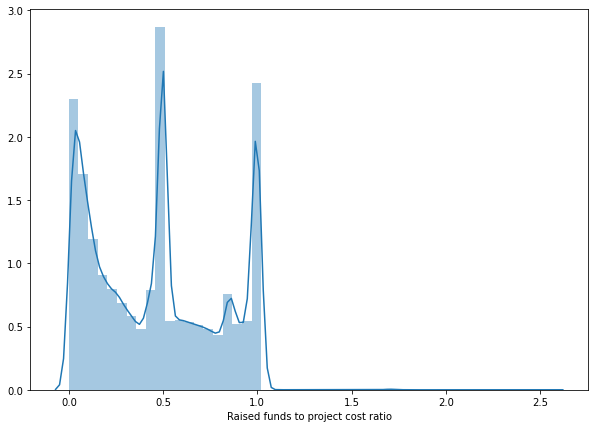

In [5]:
T=pd.Timedelta('30 days')
sub_var=["Number of dates since posted","Project ID","Donation Amount","Project Cost",
         "Project Posted Date","Project Expiration Date","Donation Received Date"]
sub_Data =Data.loc[:,sub_var]
sub_Data=sub_Data[sub_Data["Number of dates since posted"] < T]
sub_Data["Raised funds to project cost ratio"]=sub_Data["Donation Amount"]/sub_Data["Project Cost"]
Grouped_data=sub_Data.groupby(["Project ID"]).sum()
Grouped_data_Final = sub_Data.groupby(["Project ID"]).max()
Grouped_data_Final["Raised funds to project cost ratio"]=Grouped_data["Raised funds to project cost ratio"]

f, axes = plt.subplots(1, 1,figsize=(10,7))

y="Raised funds to project cost ratio"
q1 = Grouped_data_Final[y].quantile(0)
q3 = Grouped_data_Final[y].quantile(1)
mask = Grouped_data_Final[y].between(q1, q3, inclusive=True)
iqr = Grouped_data_Final.loc[mask, y]
sns.distplot(iqr, ax=axes,axlabel=y )
print(iqr.describe())


count    870802.000000
mean          0.555950
std           0.337268
min           0.000026
25%           0.255094
50%           0.500019
75%           0.889879
max           2.550013
Name: Raised funds to project cost ratio, dtype: float64


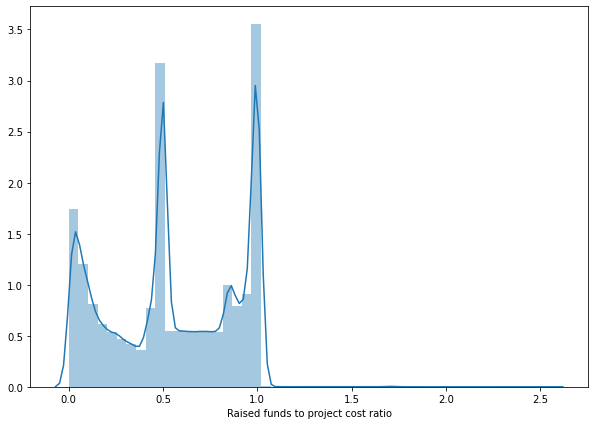

In [6]:
T=pd.Timedelta('120 days')
sub_var=["Number of dates since posted","Project ID","Donation Amount","Project Cost",
         "Project Posted Date","Project Expiration Date","Donation Received Date"]
sub_Data =Data.loc[:,sub_var]
sub_Data=sub_Data[sub_Data["Number of dates since posted"] < T]
sub_Data["Raised funds to project cost ratio"]=sub_Data["Donation Amount"]/sub_Data["Project Cost"]
Grouped_data=sub_Data.groupby(["Project ID"]).sum()
Grouped_data_Final = sub_Data.groupby(["Project ID"]).max()
Grouped_data_Final["Raised funds to project cost ratio"]=Grouped_data["Raised funds to project cost ratio"]

f, axes = plt.subplots(1, 1,figsize=(10,7))

y="Raised funds to project cost ratio"
q1 = Grouped_data_Final[y].quantile(0)
q3 = Grouped_data_Final[y].quantile(1)
mask = Grouped_data_Final[y].between(q1, q3, inclusive=True)
iqr = Grouped_data_Final.loc[mask, y]
sns.distplot(iqr, ax=axes,axlabel=y )
print(iqr.describe())

G120=Grouped_data_Final

In [7]:
#===============================================================================================
#                                  Model Training Funstion
#===============================================================================================

def Train_Model(Classifier,hyper_parameters, Model_variables_con,Model_variables_cat,Data,
                Time_period_indays=30,K=100,Fund_Ratio_treshold=0.142):
    # Time_period should be in days 
    # K is the Top-K value

    #=================================== Initiate the List Variables ================================
    
    Time_points = []
    Output=dict()
    
    
    Overall_Training_Accuracy_GS=[]
    Overall_Training_Precision_GS=[]
    Overall_Training_Recall_GS=[]

    Overall_Testing_Accuracy_GS=[]
    Overall_Testing_Precision_GS=[]
    Overall_Testing_Recall_GS=[]
    
    Overall_Top_K_Accuracy_GS=[]
    Overall_Top_K_Precision_GS=[]
    Overall_Top_K_Recall_GS=[]
    
    Classifier_models=[]
    
    #=================================== Initiate the Columns ======================================
    
    print("Initiatnig the Columns")
    Main_Variables = list(set(["Project ID","Project Posted Date","Project Expiration Date","Donation Received Date",
         "Project Cost","Donation Amount","Number of dates since posted"]+Model_variables_cat+Model_variables_con))
    Model_variables = Model_variables_con.copy()
    print("Variables considered in model training")
    for i in sub_var: print(">",i,i in Data.columns) # print all variables considered.
    print()
    Data["Number of dates since posted"]=Data.loc[:,"Donation Received Date"]-Data.loc[:,"Project Posted Date"]
    sub_Data = Data.loc[:,Main_Variables]
    sub_Data["Number of dates since posted"] = sub_Data["Number of dates since posted"]/ np.timedelta64(1, 'D')

    #================================= One-Hot-Encoding Columns to remove ==========================
    
    print("One-Hot-Encoding removing columns identification")
    Sub_Variables_to_remove=dict()
    for i in Model_variables_cat:
        sub_variables = Data[i].unique()
        Model_variables+=sorted([i+"_"+str(j) for j in Data[i].unique()])
        Model_variables.remove(i+"_"+str(sub_variables[0]))
        Sub_Variables_to_remove[i]=sub_variables[0]
        
    
    
    
    
    #======================================= Grid Search ===========================================
    keys=list(hyper_parameters.keys())
    vals=[]
    
    for i in keys:
        vals+=[hyper_parameters[i]]

    combinations=vals[0]
    for i in range (1,len(vals)):
        combinations = list(itertools.product(combinations,vals[i]))

    for i in range (len (combinations)): #tupples to single list
        try:
            p=list(combinations[i][0])
        except:
            p=[combinations[i][0]]
            
        for j in range (1,len(combinations[i])):
            p+=[combinations[i][j]]
        combinations[i]=p    


    for i in combinations:
        for j in range (len(keys)):
            setattr(Classifier, keys[j],i[j])
        print(Classifier)
        
        
        #=================================== Initiate Time Variables ====================================
    
        print("Initiate Time Variables")
        MaxT = pd.Timestamp("2018-05-01 00:00:00")  #max(Data["Project Posted Date"])
        MinT = pd.Timestamp("2013-01-01 00:00:00")  #min(Data["Project Posted Date"])
        Time_period = timedelta(days=Time_period_indays)  
        T_current = MinT- Time_period +timedelta(days=120) 
        

        #=================================== Loop over time frams =======================================
        
        Output["Overall_Training_Accuracy"], Output["Overall_Training_Precision"], Output["Overall_Training_Recall"] = list(),list(),list()
        Output["Overall_Testing_Accuracy"], Output["Overall_Testing_Precision"], Output["Overall_Testing_Recall"] = list(),list(),list()
        Output["Top_K_Accuracy"], Output["Top_K_Precision"], Output["Top_K_Recall"] = list(),list(),list()
        
        print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

        print("Time iteration is starting\n")
        while (T_current<MaxT-Time_period):

            T_current = T_current+ Time_period
            Time_points+=[T_current]
            T_Train_start = T_current-timedelta(days=120)  # Start of the data frame
            T_Train_end = T_current-Time_period  #End of the data frame
            print("As of Date:",T_current,"\n"+"="*85)

        #====================================== Extract the frams ======================================= 

            # Extracts projects posted before the Current(As of) date
            Data_in_TimeWindow = sub_Data[sub_Data["Project Posted Date"] < pd.to_datetime(T_current)]  

            # Extracts projects posted after the start date of the Time window
            Data_in_TimeWindow = Data_in_TimeWindow[Data_in_TimeWindow["Project Posted Date"] > pd.to_datetime(T_Train_start)]

            #Time period to be consided for the donations since posted (30days, as default)
            Data_in_TimeWindow = Data_in_TimeWindow[Data_in_TimeWindow["Number of dates since posted"]< Time_period_indays]

            #Express the donation amount as a ratio of to the Project cost
            Data_in_TimeWindow["Fund_Ratio"]=Data_in_TimeWindow["Donation Amount"]/Data_in_TimeWindow["Project Cost"]


        #=========================== Do One-Hot_Encoding for Categorical Variables ======================

            for var in Model_variables_cat:
                Sub_Dummied_Data=pd.get_dummies(Data_in_TimeWindow[var])  #create dummpy variables with one hot encoding 
                Sub_Dummied_Data_columns=sorted(Sub_Dummied_Data.columns)  #extract the column names of dummpy variables
                Sub_Dummied_Data_columns.remove(Sub_Variables_to_remove[var]) #remove a pre defined column from dummpy variables
                Data_in_TimeWindow=Data_in_TimeWindow.drop([var], axis=1) #remove main variable from the dataset
                #copy the columns to the main data set 
                for col in Sub_Dummied_Data_columns : Data_in_TimeWindow[var+"_"+col] = Sub_Dummied_Data[col]

            #Add the columns which have not been one-hot-encoded
            for i in Model_variables:
                if i not in Data_in_TimeWindow.columns:  Data_in_TimeWindow[i]=0


        #============================================ Imputing ==========================================
            Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


        #=================================== Training set Creation =====================================

            #extract the training set from the timewindow
            Train_Data = Data_in_TimeWindow[Data_in_TimeWindow["Project Posted Date"] < pd.to_datetime(T_Train_end)]

            #Group by Project ID
            Train_Data_CR=Train_Data.groupby(["Project ID"]).sum() 
            Train_Data_Final=Train_Data.groupby(["Project ID"]).max()
            Train_Data_Final["Fund_Ratio"]=Train_Data_CR["Fund_Ratio"]
            Train_Data_Final["Donation Amount"]=Train_Data_CR["Donation Amount"]

            # Define Fund_Ratio_Treshold
            Fund_Ratio_Treshold = Fund_Ratio_treshold
            Fund_Ratio_Treshold = Train_Data_Final["Fund_Ratio"].median()

            # Genarate the Label for the dataset 
            Train_Data_Final['Label'] = Train_Data_Final.apply(lambda x : 1  if x['Fund_Ratio'] < 
                                                               Fund_Ratio_Treshold  else 0, axis=1)

            X_train = Train_Data_Final.loc[:,Model_variables]
            Y_train = np.array(Train_Data_Final.loc[:,["Label"]])[:,0]


        #==================================== Testing set Creation =====================================

            #extract the training set from the timewindow
            Test_Data = Data_in_TimeWindow[Data_in_TimeWindow["Project Posted Date"] >= pd.to_datetime(T_Train_end)]

            #Group by Project ID
            Test_Data_CR=Test_Data.groupby(["Project ID"]).sum() 
            Test_Data_Final=Test_Data.groupby(["Project ID"]).max()
            Test_Data_Final["Fund_Ratio"]=Test_Data_CR["Fund_Ratio"]
            Test_Data_Final["Donation Amount"]=Test_Data_CR["Donation Amount"]

            # Genarate the Label for the dataset 
            Test_Data_Final['Label'] = Test_Data_Final.apply(lambda x : 1  if x['Fund_Ratio'] < 
                                                             Fund_Ratio_Treshold  else 0, axis=1)
            X_test = Test_Data_Final.loc[:,Model_variables]
            Y_test = np.array(Test_Data_Final.loc[:,["Label"]])[:,0]


        #===================================== Model Training =========================================

            Classifier.fit(X_train, Y_train)

            # Predict on training 
            Train_Data_Final["Y_pred_prob"] = Classifier.predict_proba(X_train)[:,1]
            Train_Data_Final["Y_pred"]= Classifier.predict(X_train)
            # Predict on testing 
            Test_Data_Final["Y_pred_prob"] = Classifier.predict_proba(X_test)[:,1]
            Test_Data_Final["Y_pred"] = Classifier.predict(X_test)


        #====================================== Evaluation Trainign  ============================================

            Training_CM= confusion_matrix(Y_train,Train_Data_Final["Y_pred"])
            Training_TN, Training_FP ,Training_FN, Training_TP =  Training_CM.ravel()

            Training_Accuracy=(Training_TP+Training_TN)/(Training_TN+ Training_FP +Training_FN+ Training_TP)
            Training_Precision=Training_TP/(Training_TP+Training_FP)
            Training_Recall=Training_TP/(Training_TP+Training_FN)

            print(Classifier.__class__.__name__,' Testing Accuracy = ',Training_Accuracy)
            print("\tTraining_TP:",Training_TP,"\tTraining_FP:",Training_FP,
                  "\n\tTraining_TN:",Training_TN,"\tTraining_FN:",Training_FN ,end="\n"*2)


        #====================================== Evaluation Testign  ============================================   

            Testing_CM= confusion_matrix(Y_test,Test_Data_Final["Y_pred"])
            Testing_TN, Testing_FP ,Testing_FN, Testing_TP =  Testing_CM.ravel()

            Testing_Accuracy=(Testing_TP+Testing_TN)/(Testing_TN+ Testing_FP +Testing_FN+ Testing_TP)
            Testing_Precision=Testing_TP/(Testing_TP+Testing_FP)
            Testing_Recall=Testing_TP/(Testing_TP+Testing_FN)

            print(Classifier.__class__.__name__,' Testing Accuracy = ',Testing_Accuracy)
            print("\tTesting_TP:",Testing_TP,"\tTesting_FP:",Testing_FP,
                  "\n\tTesting_TN:",Testing_TN,"\tTesting_FN:",Testing_FN ,end="\n"*2)

        #====================================== Evaluation Top K  ============================================        

            Test_Data_Final=Test_Data_Final.sort_values(by=['Y_pred_prob'], ascending=False)
            Top_K=Test_Data_Final.head(K)
            Y_test_Top_K =  Top_K.loc[:,["Label"]] 
            Y_pred_Top_K =  Top_K.loc[:,["Y_pred"]]
            Testing_Top_K_CM= confusion_matrix(Y_test_Top_K,Y_pred_Top_K)
            if len(Testing_Top_K_CM.ravel())==4:
                Testing_Top_K_TN, Testing_Top_K_FP ,Testing_Top_K_FN, Testing_Top_K_TP =  Testing_Top_K_CM.ravel()
            else:
                Testing_Top_K_TN, Testing_Top_K_FP ,Testing_Top_K_FN, Testing_Top_K_TP=0,0,0,K

            Testing_Top_K_Accuracy=(Testing_Top_K_TP+Testing_Top_K_TN)/(Testing_Top_K_TN
                                                                        + Testing_Top_K_FP +Testing_Top_K_FN+ Testing_Top_K_TP)
            Testing_Top_K_Precision=Testing_Top_K_TP/(Testing_TP+Testing_FP)
            Testing_Top_K_Recall=Testing_Top_K_TP/(Testing_TP+Testing_FN)

            print(Classifier.__class__.__name__,' Testing Accuracy = ',Testing_Top_K_Accuracy)
            print("\tTesting_Top_K_TP:",Testing_Top_K_TP,"\tTesting_Top_K_FP:",Testing_Top_K_FP,
                  "\n\tTesting_Top_K_TN:",Testing_Top_K_TN,"\tTesting_Top_K_FN:",Testing_Top_K_FN ,end="\n"*2)

         #====================================== save computed values  ============================================       
            Output["Overall_Training_Accuracy"] += [Training_Accuracy]
            Output["Overall_Training_Precision"] += [Training_Precision]
            Output["Overall_Training_Recall"] += [Training_Recall ]

            Output["Overall_Testing_Accuracy"] += [Testing_Accuracy]
            Output["Overall_Testing_Precision"] += [Testing_Precision]
            Output["Overall_Testing_Recall"] += [Testing_Recall]

            Output["Top_K_Accuracy"] += [Testing_Top_K_Accuracy] 
            Output["Top_K_Precision"] += [Testing_Top_K_Precision]  
            Output["Top_K_Recall"] += [Testing_Top_K_Recall] 
            
            
        Overall_Training_Accuracy_GS+=[sum(Output["Overall_Training_Accuracy"])/len(Output["Overall_Training_Accuracy"])]
        Overall_Training_Precision_GS+=[sum(Output["Overall_Training_Precision"])/len(Output["Overall_Training_Precision"])]
        Overall_Training_Recall_GS+=[sum(Output["Overall_Training_Recall"])/len(Output["Overall_Training_Recall"])]

        Overall_Testing_Accuracy_GS+=[sum(Output["Overall_Testing_Accuracy"])/len(Output["Overall_Testing_Accuracy"])]
        Overall_Testing_Precision_GS+=[sum(Output["Overall_Testing_Precision"])/len(Output["Overall_Testing_Precision"])]
        Overall_Testing_Recall_GS+=[sum(Output["Overall_Testing_Recall"])/len(Output["Overall_Testing_Recall"])]

        Overall_Top_K_Accuracy_GS+=[sum(Output["Top_K_Accuracy"])/len(Output["Top_K_Accuracy"])]
        Overall_Top_K_Precision_GS+=[sum(Output["Top_K_Precision"])/len(Output["Top_K_Precision"])]
        Overall_Top_K_Recall_GS+=[sum(Output["Top_K_Recall"])/len(Output["Top_K_Recall"])]
        
        Classifier_models+=[Classifier]
        
    
    
    Output["Overall_Training_Accuracy"] = Overall_Training_Accuracy_GS
    Output["Overall_Training_Precision"] =Overall_Training_Precision_GS
    Output["Overall_Training_Recall"] =Overall_Training_Precision_GS

    Output["Overall_Testing_Accuracy"] =Overall_Testing_Accuracy_GS
    Output["Overall_Testing_Precision"] =Overall_Testing_Precision_GS
    Output["Overall_Testing_Recall"] =Overall_Testing_Recall_GS

    Output["Top_K_Accuracy"] = Overall_Top_K_Accuracy_GS
    Output["Top_K_Precision"] = Overall_Top_K_Precision_GS
    Output["Top_K_Recall"] = Overall_Top_K_Recall_GS
    
    Output["Classifier"]=Classifier_models
    Output["Model_variables"]=Model_variables
    Output["Time_points"]=Time_points
    
    print(Overall_Training_Accuracy_GS)
    return Output,Test_Data_Final,Train_Data_Final
        

In [8]:
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler


clf = tree.DecisionTreeClassifier( criterion='entropy')

hyper_para=dict()
hyper_para["max_depth"]=[10,20,30,40]
hyper_para["min_samples_split"]=[3,9,12,18,25]
hyper_para["max_features"]=[5,10,20]
# hyper_para["criterion"]=["gini", "entropy"]

Model_variables_con= ["Project Cost","Number of dates since posted","School Percentage Free Lunch","Project Cost",
                      "Project Short Description_polarity","Project Short Description_subjectivity",
                      "Project Essay_polarity","Project Essay_subjectivity","Project Need Statement_polarity",
                      "Project Need Statement_subjectivity"]
Model_variables_cat= ["School Metro Type","Teacher Prefix","Project Grade Level Category"]

Output,Test_Data_Final,Train_Data_Final= Train_Model(clf, hyper_para,Model_variables_con,Model_variables_cat,
                                    Data,Time_period_indays=30,K=100,Fund_Ratio_treshold=0.03)

Initiatnig the Columns
Variables considered in model training
> Number of dates since posted True
> Project ID True
> Donation Amount True
> Project Cost True
> Project Posted Date True
> Project Expiration Date True
> Donation Received Date True

One-Hot-Encoding removing columns identification
DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=5,
                       min_samples_split=3)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6739018751605446
	Training_TP: 5100 	Training_FP: 2392 
	Training_TN: 5394 	Training_FN: 2686

DecisionTreeClassifier  Testing Accuracy =  0.6037919299951385
	Testing_TP: 1068 	Testing_FP: 786 
	Testing_TN: 1416 	Testing_FN: 844

DecisionTreeClassifier  Testing Accuracy =  0.53
	Testing_Top_K_TP: 53 	Testing_Top_K_FP: 47 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 

DecisionTreeClassifier  Testing Accuracy =  0.669795109054858
	Training_TP: 5127 	Training_FP: 2558 
	Training_TN: 5007 	Training_FN: 2438

DecisionTreeClassifier  Testing Accuracy =  0.6103578154425612
	Testing_TP: 1791 	Testing_FP: 1072 
	Testing_TN: 1450 	Testing_FN: 997

DecisionTreeClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6596138587675218
	Training_TP: 5176 	Training_FP: 2762 
	Training_TN: 4800 	Training_FN: 2386

DecisionTreeClassifier  Testing Accuracy =  0.573297342192691
	Testing_TP: 3841 	Testing_FP: 3246 
	Testing_TN: 4442 	Testing_FN: 2919

DecisionTreeClassifier  Testing Accuracy =  0.51
	Testing_Top_K_TP: 51 	Testing_Top_K_FP: 49 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6484123711340206
	Training_TP: 7262 	Training_FP: 3663 
	Trai

DecisionTreeClassifier  Testing Accuracy =  0.6579365429592692
	Training_TP: 14385 	Training_FP: 7227 
	Training_TN: 15434 	Training_FN: 8276

DecisionTreeClassifier  Testing Accuracy =  0.6249156951536757
	Testing_TP: 3069 	Testing_FP: 1844 
	Testing_TN: 3417 	Testing_FN: 2049

DecisionTreeClassifier  Testing Accuracy =  0.55
	Testing_Top_K_TP: 55 	Testing_Top_K_FP: 45 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.664633178364894
	Training_TP: 15665 	Training_FP: 8406 
	Training_TN: 13642 	Training_FN: 6382

DecisionTreeClassifier  Testing Accuracy =  0.6095729013254787
	Testing_TP: 4366 	Testing_FP: 3101 
	Testing_TN: 3912 	Testing_FN: 2201

DecisionTreeClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6592858513058014
	Training_TP: 12665 	Training_FP: 6853

DecisionTreeClassifier  Testing Accuracy =  0.6636995223621364
	Training_TP: 14270 	Training_FP: 7484 
	Training_TN: 13243 	Training_FN: 6457

DecisionTreeClassifier  Testing Accuracy =  0.621619602569849
	Testing_TP: 3826 	Testing_FP: 3028 
	Testing_TN: 4495 	Testing_FN: 2037

DecisionTreeClassifier  Testing Accuracy =  0.55
	Testing_Top_K_TP: 55 	Testing_Top_K_FP: 45 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6577084164339848
	Training_TP: 13329 	Training_FP: 7003 
	Training_TN: 13053 	Training_FN: 6727

DecisionTreeClassifier  Testing Accuracy =  0.601727115716753
	Testing_TP: 4071 	Testing_FP: 2585 
	Testing_TN: 4639 	Testing_FN: 3180

DecisionTreeClassifier  Testing Accuracy =  0.49
	Testing_Top_K_TP: 49 	Testing_Top_K_FP: 51 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6608065225951405
	Training_TP: 14326 	Training_FP: 7579 

DecisionTreeClassifier  Testing Accuracy =  0.6912642430819317
	Training_TP: 4685 	Training_FP: 1865 
	Training_TN: 5507 	Training_FN: 2687

DecisionTreeClassifier  Testing Accuracy =  0.5802288775261748
	Testing_TP: 1132 	Testing_FP: 729 
	Testing_TN: 1251 	Testing_FN: 995

DecisionTreeClassifier  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6889026947270327
	Training_TP: 4780 	Training_FP: 2348 
	Training_TN: 4091 	Training_FN: 1658

DecisionTreeClassifier  Testing Accuracy =  0.6048767697954903
	Testing_TP: 1620 	Testing_FP: 679 
	Testing_TN: 687 	Testing_FN: 828

DecisionTreeClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6973058637083994
	Training_TP: 4533 	Training_FP: 2168 
	Traini

DecisionTreeClassifier  Testing Accuracy =  0.6616907216494845
	Training_TP: 7569 	Training_FP: 3648 
	Training_TN: 8477 	Training_FN: 4556

DecisionTreeClassifier  Testing Accuracy =  0.6301902229494785
	Testing_TP: 7311 	Testing_FP: 2845 
	Testing_TN: 5013 	Testing_FN: 4387

DecisionTreeClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6799041598694943
	Training_TP: 13253 	Training_FP: 6195 
	Training_TN: 13421 	Training_FN: 6363

DecisionTreeClassifier  Testing Accuracy =  0.633359086616877
	Testing_TP: 4315 	Testing_FP: 1926 
	Testing_TN: 3063 	Testing_FN: 2345

DecisionTreeClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6801507870023368
	Training_TP: 15391 	Training_FP: 7219 
	

DecisionTreeClassifier  Testing Accuracy =  0.6758926858677482
	Training_TP: 11701 	Training_FP: 5283 
	Training_TN: 12963 	Training_FN: 6544

DecisionTreeClassifier  Testing Accuracy =  0.6257633367899528
	Testing_TP: 2248 	Testing_FP: 1452 
	Testing_TN: 3183 	Testing_FN: 1796

DecisionTreeClassifier  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.674670242290062
	Training_TP: 10967 	Training_FP: 5366 
	Training_TN: 10669 	Training_FN: 5067

DecisionTreeClassifier  Testing Accuracy =  0.6204520628518612
	Testing_TP: 3512 	Testing_FP: 2329 
	Testing_TN: 3872 	Testing_FN: 2188

DecisionTreeClassifier  Testing Accuracy =  0.47
	Testing_Top_K_TP: 47 	Testing_Top_K_FP: 53 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6634120362151606
	Training_TP: 11501 	Training_FP: 5978

DecisionTreeClassifier  Testing Accuracy =  0.6653695596785028
	Training_TP: 13618 	Training_FP: 6674 
	Training_TN: 15108 	Training_FN: 7773

DecisionTreeClassifier  Testing Accuracy =  0.6136643414033648
	Testing_TP: 2744 	Testing_FP: 1690 
	Testing_TN: 3238 	Testing_FN: 2076

DecisionTreeClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6556465690882235
	Training_TP: 11179 	Training_FP: 5650 
	Training_TN: 13234 	Training_FN: 7172

DecisionTreeClassifier  Testing Accuracy =  0.5957398595060049
	Testing_TP: 3004 	Testing_FP: 1135 
	Testing_TN: 2254 	Testing_FN: 2433

DecisionTreeClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.655058401829306
	Training_TP: 9791 	Training_FP: 4773 

DecisionTreeClassifier  Testing Accuracy =  0.706314121277838
	Training_TP: 4626 	Training_FP: 2153 
	Training_TN: 3842 	Training_FN: 1368

DecisionTreeClassifier  Testing Accuracy =  0.5720625528317836
	Testing_TP: 1469 	Testing_FP: 1302 
	Testing_TN: 1238 	Testing_FN: 723

DecisionTreeClassifier  Testing Accuracy =  0.53
	Testing_Top_K_TP: 53 	Testing_Top_K_FP: 47 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6880982769623485
	Training_TP: 4165 	Training_FP: 1807 
	Training_TN: 4461 	Training_FN: 2103

DecisionTreeClassifier  Testing Accuracy =  0.6099718954928698
	Testing_TP: 2560 	Testing_FP: 2162 
	Testing_TN: 3300 	Testing_FN: 1585

DecisionTreeClassifier  Testing Accuracy =  0.51
	Testing_Top_K_TP: 51 	Testing_Top_K_FP: 49 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6955005811057613
	Training_TP: 6231 	Training_FP: 2699 
	Tra

DecisionTreeClassifier  Testing Accuracy =  0.6865658480666638
	Training_TP: 14445 	Training_FP: 5982 
	Training_TN: 16699 	Training_FN: 8236

DecisionTreeClassifier  Testing Accuracy =  0.619378384742171
	Testing_TP: 2430 	Testing_FP: 1549 
	Testing_TN: 2831 	Testing_FN: 1684

DecisionTreeClassifier  Testing Accuracy =  0.55
	Testing_Top_K_TP: 55 	Testing_Top_K_FP: 45 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6977432778489117
	Training_TP: 12766 	Training_FP: 5353 
	Training_TN: 13391 	Training_FN: 5978

DecisionTreeClassifier  Testing Accuracy =  0.6285062407730506
	Testing_TP: 1711 	Testing_FP: 1651 
	Testing_TN: 2972 	Testing_FN: 1117

DecisionTreeClassifier  Testing Accuracy =  0.41
	Testing_Top_K_TP: 41 	Testing_Top_K_FP: 59 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.680208448016441
	Training_TP: 9412 	Training_FP: 4502 


DecisionTreeClassifier  Testing Accuracy =  0.6732942777679153
	Training_TP: 11522 	Training_FP: 5665 
	Training_TN: 11234 	Training_FN: 5377

DecisionTreeClassifier  Testing Accuracy =  0.6170771756978654
	Testing_TP: 4223 	Testing_FP: 3072 
	Testing_TN: 5172 	Testing_FN: 2758

DecisionTreeClassifier  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6622992392223161
	Training_TP: 10885 	Training_FP: 5125 
	Training_TN: 12620 	Training_FN: 6860

DecisionTreeClassifier  Testing Accuracy =  0.6072270889487871
	Testing_TP: 3444 	Testing_FP: 2041 
	Testing_TN: 3765 	Testing_FN: 2622

DecisionTreeClassifier  Testing Accuracy =  0.58
	Testing_Top_K_TP: 58 	Testing_Top_K_FP: 42 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.664567622897717
	Training_TP: 12369 	Training_FP: 6019

DecisionTreeClassifier  Testing Accuracy =  0.663494221617947
	Training_TP: 10237 	Training_FP: 4946 
	Training_TN: 11235 	Training_FN: 5944

DecisionTreeClassifier  Testing Accuracy =  0.6015545479781623
	Testing_TP: 3751 	Testing_FP: 1865 
	Testing_TN: 2750 	Testing_FN: 2441

DecisionTreeClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6772766545705893
	Training_TP: 9906 	Training_FP: 4777 
	Training_TN: 9691 	Training_FN: 4561

DecisionTreeClassifier  Testing Accuracy =  0.6078136349486355
	Testing_TP: 5343 	Testing_FP: 4365 
	Testing_TN: 6372 	Testing_FN: 3194

DecisionTreeClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6619893336094859
	Training_TP: 13550 	Training_FP: 7293 


DecisionTreeClassifier  Testing Accuracy =  0.6793403066024684
	Training_TP: 6354 	Training_FP: 3114 
	Training_TN: 5921 	Training_FN: 2680

DecisionTreeClassifier  Testing Accuracy =  0.6209883226355271
	Testing_TP: 4900 	Testing_FP: 2209 
	Testing_TN: 3130 	Testing_FN: 2692

DecisionTreeClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6634633019110149
	Training_TP: 8987 	Training_FP: 4531 
	Training_TN: 9101 	Training_FN: 4644

DecisionTreeClassifier  Testing Accuracy =  0.6134364427259545
	Testing_TP: 3232 	Testing_FP: 1871 
	Testing_TN: 3114 	Testing_FN: 2128

DecisionTreeClassifier  Testing Accuracy =  0.58
	Testing_Top_K_TP: 58 	Testing_Top_K_FP: 42 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6629785418190686
	Training_TP: 10646 	Training_FP: 5299 
	

DecisionTreeClassifier  Testing Accuracy =  0.6614921648500862
	Training_TP: 9263 	Training_FP: 4863 
	Training_TN: 8762 	Training_FN: 4361

DecisionTreeClassifier  Testing Accuracy =  0.617040829722988
	Testing_TP: 1803 	Testing_FP: 1559 
	Testing_TN: 2897 	Testing_FN: 1358

DecisionTreeClassifier  Testing Accuracy =  0.49
	Testing_Top_K_TP: 49 	Testing_Top_K_FP: 51 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6511096746390864
	Training_TP: 7539 	Training_FP: 4033 
	Training_TN: 7570 	Training_FN: 4063

DecisionTreeClassifier  Testing Accuracy =  0.6148413510747185
	Testing_TP: 2682 	Testing_FP: 1706 
	Testing_TN: 3325 	Testing_FN: 2057

DecisionTreeClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6561521889354092
	Training_TP: 8113 	Training_FP: 4272 
	Tr

DecisionTreeClassifier  Testing Accuracy =  0.6501593718417166
	Training_TP: 12096 	Training_FP: 6302 
	Training_TN: 12993 	Training_FN: 7198

DecisionTreeClassifier  Testing Accuracy =  0.6091319618665328
	Testing_TP: 2600 	Testing_FP: 1511 
	Testing_TN: 2256 	Testing_FN: 1605

DecisionTreeClassifier  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6539652229262506
	Training_TP: 11069 	Training_FP: 5748 
	Training_TN: 11534 	Training_FN: 6212

DecisionTreeClassifier  Testing Accuracy =  0.6163892078071183
	Testing_TP: 2559 	Testing_FP: 1024 
	Testing_TN: 1736 	Testing_FN: 1649

DecisionTreeClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6643745537895014
	Training_TP: 8390 	Training_FP: 4016 


DecisionTreeClassifier  Testing Accuracy =  0.6464557551908041
	Training_TP: 12511 	Training_FP: 6854 
	Training_TN: 12459 	Training_FN: 6802

DecisionTreeClassifier  Testing Accuracy =  0.604101903101069
	Testing_TP: 7686 	Testing_FP: 5439 
	Testing_TN: 8249 	Testing_FN: 5004

DecisionTreeClassifier  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6458777920045525
	Training_TP: 17636 	Training_FP: 9433 
	Training_TN: 18683 	Training_FN: 10480

DecisionTreeClassifier  Testing Accuracy =  0.606867193712869
	Testing_TP: 6494 	Testing_FP: 3676 
	Testing_TN: 6479 	Testing_FN: 4728

DecisionTreeClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6401102605204416
	Training_TP: 20297 	Training_FP: 10945

DecisionTreeClassifier  Testing Accuracy =  0.6702023896610583
	Training_TP: 10765 	Training_FP: 5181 
	Training_TN: 11223 	Training_FN: 5639

DecisionTreeClassifier  Testing Accuracy =  0.6512120046171604
	Testing_TP: 3603 	Testing_FP: 1839 
	Testing_TN: 3167 	Testing_FN: 1787

DecisionTreeClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6881529962771706
	Training_TP: 11357 	Training_FP: 5090 
	Training_TN: 11564 	Training_FN: 5297

DecisionTreeClassifier  Testing Accuracy =  0.6459592410400562
	Testing_TP: 1620 	Testing_FP: 1592 
	Testing_TN: 2976 	Testing_FN: 927

DecisionTreeClassifier  Testing Accuracy =  0.51
	Testing_Top_K_TP: 51 	Testing_Top_K_FP: 49 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6944474825914179
	Training_TP: 9728 	Training_FP: 4395 


DecisionTreeClassifier  Testing Accuracy =  0.6681029226454209
	Training_TP: 8486 	Training_FP: 4351 
	Training_TN: 7950 	Training_FN: 3814

DecisionTreeClassifier  Testing Accuracy =  0.6534537351940893
	Testing_TP: 3324 	Testing_FP: 1447 
	Testing_TN: 2248 	Testing_FN: 1508

DecisionTreeClassifier  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6958369065252982
	Training_TP: 8514 	Training_FP: 3490 
	Training_TN: 9337 	Training_FN: 4313

DecisionTreeClassifier  Testing Accuracy =  0.6388888888888888
	Testing_TP: 2168 	Testing_FP: 1228 
	Testing_TN: 2501 	Testing_FN: 1411

DecisionTreeClassifier  Testing Accuracy =  0.58
	Testing_Top_K_TP: 58 	Testing_Top_K_FP: 42 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7066079987428302
	Training_TP: 8482 	Training_FP: 3223 
	T

DecisionTreeClassifier  Testing Accuracy =  0.673129673467854
	Training_TP: 8642 	Training_FP: 4035 
	Training_TN: 9272 	Training_FN: 4664

DecisionTreeClassifier  Testing Accuracy =  0.6120529801324504
	Testing_TP: 2384 	Testing_FP: 1342 
	Testing_TN: 2237 	Testing_FN: 1587

DecisionTreeClassifier  Testing Accuracy =  0.62
	Testing_Top_K_TP: 62 	Testing_Top_K_FP: 38 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6682240891324858
	Training_TP: 7501 	Training_FP: 3757 
	Training_TN: 7373 	Training_FN: 3628

DecisionTreeClassifier  Testing Accuracy =  0.6388184226844805
	Testing_TP: 5898 	Testing_FP: 3711 
	Testing_TN: 5434 	Testing_FN: 2696

DecisionTreeClassifier  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6796704325572686
	Training_TP: 10139 	Training_FP: 4382 
	T

DecisionTreeClassifier  Testing Accuracy =  0.6491288520022171
	Training_TP: 20811 	Training_FP: 10857 
	Training_TN: 22519 	Training_FN: 12564

DecisionTreeClassifier  Testing Accuracy =  0.6046339006415354
	Testing_TP: 5380 	Testing_FP: 3177 
	Testing_TN: 6024 	Testing_FN: 4280

DecisionTreeClassifier  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6518236503464555
	Training_TP: 20594 	Training_FP: 10625 
	Training_TN: 22208 	Training_FN: 12238

DecisionTreeClassifier  Testing Accuracy =  0.6120595504972122
	Testing_TP: 5343 	Testing_FP: 3325 
	Testing_TN: 5305 	Testing_FN: 3424

DecisionTreeClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6492935800696791
	Training_TP: 18685 	Training_FP: 

DecisionTreeClassifier  Testing Accuracy =  0.6979838856684532
	Training_TP: 9462 	Training_FP: 4032 
	Training_TN: 9683 	Training_FN: 4252

DecisionTreeClassifier  Testing Accuracy =  0.619139993533786
	Testing_TP: 1600 	Testing_FP: 1104 
	Testing_TN: 2230 	Testing_FN: 1252

DecisionTreeClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6991312494676774
	Training_TP: 8055 	Training_FP: 3379 
	Training_TN: 8362 	Training_FN: 3686

DecisionTreeClassifier  Testing Accuracy =  0.6002066115702479
	Testing_TP: 1959 	Testing_FP: 1656 
	Testing_TN: 2689 	Testing_FN: 1440

DecisionTreeClassifier  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6794921123509042
	Training_TP: 6663 	Training_FP: 2931 
	Tra

DecisionTreeClassifier  Testing Accuracy =  0.7148974620884734
	Training_TP: 9132 	Training_FP: 3662 
	Training_TN: 9065 	Training_FN: 3595

DecisionTreeClassifier  Testing Accuracy =  0.636250444681608
	Testing_TP: 1784 	Testing_FP: 976 
	Testing_TN: 1793 	Testing_FN: 1069

DecisionTreeClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7256641343839947
	Training_TP: 7853 	Training_FP: 3071 
	Training_TN: 7526 	Training_FN: 2743

DecisionTreeClassifier  Testing Accuracy =  0.6169975876786046
	Testing_TP: 1953 	Testing_FP: 920 
	Testing_TN: 1372 	Testing_FN: 1144

DecisionTreeClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7112562084937776
	Training_TP: 6495 	Training_FP: 2710 
	Trai

DecisionTreeClassifier  Testing Accuracy =  0.6854753136508333
	Training_TP: 11147 	Training_FP: 5204 
	Training_TN: 10817 	Training_FN: 4874

DecisionTreeClassifier  Testing Accuracy =  0.6448139775470324
	Testing_TP: 8853 	Testing_FP: 5133 
	Testing_TN: 7976 	Testing_FN: 4137

DecisionTreeClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6872053674471373
	Training_TP: 17160 	Training_FP: 7590 
	Training_TN: 17972 	Training_FN: 8401

DecisionTreeClassifier  Testing Accuracy =  0.6252864532180973
	Testing_TP: 4744 	Testing_FP: 2616 
	Testing_TN: 4806 	Testing_FN: 3107

DecisionTreeClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6881066104604715
	Training_TP: 19187 	Training_FP: 812

DecisionTreeClassifier  Testing Accuracy =  0.6488033754092334
	Training_TP: 16832 	Training_FP: 8333 
	Training_TN: 20227 	Training_FN: 11727

DecisionTreeClassifier  Testing Accuracy =  0.6352852285606346
	Testing_TP: 3200 	Testing_FP: 2429 
	Testing_TN: 5208 	Testing_FN: 2398

DecisionTreeClassifier  Testing Accuracy =  0.5
	Testing_Top_K_TP: 50 	Testing_Top_K_FP: 50 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6603337559818397
	Training_TP: 15893 	Training_FP: 8053 
	Training_TN: 16396 	Training_FN: 8556

DecisionTreeClassifier  Testing Accuracy =  0.6173000699463744
	Testing_TP: 5645 	Testing_FP: 3953 
	Testing_TN: 7593 	Testing_FN: 4254

DecisionTreeClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6432681688721834
	Training_TP: 15609 	Training_FP: 821

DecisionTreeClassifier  Testing Accuracy =  0.6647268180069258
	Training_TP: 6749 	Training_FP: 3324 
	Training_TN: 7072 	Training_FN: 3647

DecisionTreeClassifier  Testing Accuracy =  0.5929475801680274
	Testing_TP: 2468 	Testing_FP: 1612 
	Testing_TN: 2543 	Testing_FN: 1828

DecisionTreeClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6422800920702261
	Training_TP: 7536 	Training_FP: 4384 
	Training_TN: 6695 	Training_FN: 3542

DecisionTreeClassifier  Testing Accuracy =  0.5976555455365193
	Testing_TP: 1720 	Testing_FP: 1278 
	Testing_TN: 1594 	Testing_FN: 953

DecisionTreeClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.646765007935767
	Training_TP: 7479 	Training_FP: 4335 
	Tra

DecisionTreeClassifier  Testing Accuracy =  0.6889335342374017
	Training_TP: 6120 	Training_FP: 2735 
	Training_TN: 6225 	Training_FN: 2839

DecisionTreeClassifier  Testing Accuracy =  0.6096235152003221
	Testing_TP: 1427 	Testing_FP: 955 
	Testing_TN: 1601 	Testing_FN: 984

DecisionTreeClassifier  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6774540168130965
	Training_TP: 5185 	Training_FP: 2378 
	Training_TN: 5533 	Training_FN: 2725

DecisionTreeClassifier  Testing Accuracy =  0.6122504537205081
	Testing_TP: 2682 	Testing_FP: 2666 
	Testing_TN: 4065 	Testing_FN: 1607

DecisionTreeClassifier  Testing Accuracy =  0.5
	Testing_Top_K_TP: 50 	Testing_Top_K_FP: 50 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6584160745376688
	Training_TP: 7758 	Training_FP: 4392 
	Trai

DecisionTreeClassifier  Testing Accuracy =  0.6793357243630059
	Training_TP: 19136 	Training_FP: 8586 
	Training_TN: 20830 	Training_FN: 10279

DecisionTreeClassifier  Testing Accuracy =  0.6288554440728353
	Testing_TP: 3032 	Testing_FP: 1826 
	Testing_TN: 3737 	Testing_FN: 2169

DecisionTreeClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6636138178835752
	Training_TP: 17463 	Training_FP: 9085 
	Training_TN: 16520 	Training_FN: 8141

DecisionTreeClassifier  Testing Accuracy =  0.625378456570006
	Testing_TP: 3987 	Testing_FP: 3038 
	Testing_TN: 5308 	Testing_FN: 2530

DecisionTreeClassifier  Testing Accuracy =  0.5
	Testing_Top_K_TP: 50 	Testing_Top_K_FP: 50 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6585040071237755
	Training_TP: 13013 	Training_FP: 6605

DecisionTreeClassifier  Testing Accuracy =  0.638986301900684
	Training_TP: 15987 	Training_FP: 8814 
	Training_TN: 16993 	Training_FN: 9819

DecisionTreeClassifier  Testing Accuracy =  0.6015366987935566
	Testing_TP: 3933 	Testing_FP: 2775 
	Testing_TN: 4992 	Testing_FN: 3137

DecisionTreeClassifier  Testing Accuracy =  0.62
	Testing_Top_K_TP: 62 	Testing_Top_K_FP: 38 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6354925886495782
	Training_TP: 14385 	Training_FP: 7940 
	Training_TN: 16655 	Training_FN: 9864

DecisionTreeClassifier  Testing Accuracy =  0.6080241587575496
	Testing_TP: 8915 	Testing_FP: 3086 
	Testing_TN: 5179 	Testing_FN: 6000

DecisionTreeClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=10,
                       min_samples_split=12)
Initiate Time 

DecisionTreeClassifier  Testing Accuracy =  0.6704789468770423
	Training_TP: 7465 	Training_FP: 3813 
	Training_TN: 6898 	Training_FN: 3246

DecisionTreeClassifier  Testing Accuracy =  0.5828755446107218
	Testing_TP: 1714 	Testing_FP: 1178 
	Testing_TN: 1363 	Testing_FN: 1024

DecisionTreeClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6697026800670016
	Training_TP: 6203 	Training_FP: 2961 
	Training_TN: 6591 	Training_FN: 3349

DecisionTreeClassifier  Testing Accuracy =  0.5986585893552575
	Testing_TP: 1553 	Testing_FP: 810 
	Testing_TN: 1214 	Testing_FN: 1045

DecisionTreeClassifier  Testing Accuracy =  0.62
	Testing_Top_K_TP: 62 	Testing_Top_K_FP: 38 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6793787177792465
	Training_TP: 5006 	Training_FP: 2292 
	Tr

DecisionTreeClassifier  Testing Accuracy =  0.6817090960425392
	Training_TP: 7780 	Training_FP: 3919 
	Training_TN: 6707 	Training_FN: 2845

DecisionTreeClassifier  Testing Accuracy =  0.6212142102118664
	Testing_TP: 7300 	Testing_FP: 4493 
	Testing_TN: 6217 	Testing_FN: 3749

DecisionTreeClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6717397078353253
	Training_TP: 11829 	Training_FP: 5363 
	Training_TN: 13462 	Training_FN: 6996

DecisionTreeClassifier  Testing Accuracy =  0.6215045293422607
	Testing_TP: 3748 	Testing_FP: 1914 
	Testing_TN: 4142 	Testing_FN: 2891

DecisionTreeClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6738228674815763
	Training_TP: 14923 	Training_FP: 7045 

DecisionTreeClassifier  Testing Accuracy =  0.6740377955872168
	Training_TP: 14449 	Training_FP: 7413 
	Training_TN: 12801 	Training_FN: 5765

DecisionTreeClassifier  Testing Accuracy =  0.628188890899222
	Testing_TP: 2967 	Testing_FP: 2431 
	Testing_TN: 3977 	Testing_FN: 1679

DecisionTreeClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6772684752104771
	Training_TP: 12717 	Training_FP: 6274 
	Training_TN: 11899 	Training_FN: 5456

DecisionTreeClassifier  Testing Accuracy =  0.6220032634617798
	Testing_TP: 4848 	Testing_FP: 3378 
	Testing_TN: 5063 	Testing_FN: 2645

DecisionTreeClassifier  Testing Accuracy =  0.49
	Testing_Top_K_TP: 49 	Testing_Top_K_FP: 51 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6724079702803107
	Training_TP: 14025 	Training_FP: 6878

DecisionTreeClassifier  Testing Accuracy =  0.6823786283072181
	Training_TP: 5163 	Training_FP: 2323 
	Training_TN: 5463 	Training_FN: 2623

DecisionTreeClassifier  Testing Accuracy =  0.5972289742343219
	Testing_TP: 1085 	Testing_FP: 830 
	Testing_TN: 1372 	Testing_FN: 827

DecisionTreeClassifier  Testing Accuracy =  0.58
	Testing_Top_K_TP: 58 	Testing_Top_K_FP: 42 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6884834508952794
	Training_TP: 5379 	Training_FP: 2600 
	Training_TN: 4772 	Training_FN: 1993

DecisionTreeClassifier  Testing Accuracy =  0.5943511078646214
	Testing_TP: 1357 	Testing_FP: 896 
	Testing_TN: 1084 	Testing_FN: 770

DecisionTreeClassifier  Testing Accuracy =  0.58
	Testing_Top_K_TP: 58 	Testing_Top_K_FP: 42 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6965908208433641
	Training_TP: 4677 	Training_FP: 2146 
	Train

DecisionTreeClassifier  Testing Accuracy =  0.6775985189103412
	Training_TP: 5479 	Training_FP: 2793 
	Training_TN: 4769 	Training_FN: 2083

DecisionTreeClassifier  Testing Accuracy =  0.5652685492801772
	Testing_TP: 3995 	Testing_FP: 3516 
	Testing_TN: 4172 	Testing_FN: 2765

DecisionTreeClassifier  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6602886597938145
	Training_TP: 8230 	Training_FP: 4343 
	Training_TN: 7782 	Training_FN: 3895

DecisionTreeClassifier  Testing Accuracy =  0.6365821231335651
	Testing_TP: 7983 	Testing_FP: 3392 
	Testing_TN: 4466 	Testing_FN: 3715

DecisionTreeClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6810766721044046
	Training_TP: 13214 	Training_FP: 6110 
	

DecisionTreeClassifier  Testing Accuracy =  0.6783081982084137
	Training_TP: 14367 	Training_FP: 6505 
	Training_TN: 15543 	Training_FN: 7680

DecisionTreeClassifier  Testing Accuracy =  0.6229013254786451
	Testing_TP: 3961 	Testing_FP: 2515 
	Testing_TN: 4498 	Testing_FN: 2606

DecisionTreeClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6814282973883972
	Training_TP: 12406 	Training_FP: 5786 
	Training_TN: 12460 	Training_FN: 5839

DecisionTreeClassifier  Testing Accuracy =  0.6114759764949879
	Testing_TP: 2350 	Testing_FP: 1678 
	Testing_TN: 2957 	Testing_FN: 1694

DecisionTreeClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6774766908852786
	Training_TP: 10496 	Training_FP: 480

DecisionTreeClassifier  Testing Accuracy =  0.6783007578779418
	Training_TP: 13711 	Training_FP: 6559 
	Training_TN: 13497 	Training_FN: 6345

DecisionTreeClassifier  Testing Accuracy =  0.5972366148531951
	Testing_TP: 3949 	Testing_FP: 2528 
	Testing_TN: 4696 	Testing_FN: 3302

DecisionTreeClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6667593171658213
	Training_TP: 13696 	Training_FP: 6692 
	Training_TN: 15090 	Training_FN: 7695

DecisionTreeClassifier  Testing Accuracy =  0.6179729175215429
	Testing_TP: 2762 	Testing_FP: 1666 
	Testing_TN: 3262 	Testing_FN: 2058

DecisionTreeClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6553511481133343
	Training_TP: 10917 	Training_FP: 539

DecisionTreeClassifier  Testing Accuracy =  0.6777199658305506
	Training_TP: 4898 	Training_FP: 2610 
	Training_TN: 3829 	Training_FN: 1540

DecisionTreeClassifier  Testing Accuracy =  0.6211326691137913
	Testing_TP: 1709 	Testing_FP: 706 
	Testing_TN: 660 	Testing_FN: 739

DecisionTreeClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6705313203770122
	Training_TP: 4336 	Training_FP: 2292 
	Training_TN: 3703 	Training_FN: 1658

DecisionTreeClassifier  Testing Accuracy =  0.5739644970414202
	Testing_TP: 1399 	Testing_FP: 1223 
	Testing_TN: 1317 	Testing_FN: 793

DecisionTreeClassifier  Testing Accuracy =  0.53
	Testing_Top_K_TP: 53 	Testing_Top_K_FP: 47 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6597000638162093
	Training_TP: 4464 	Training_FP: 2462 
	Train

DecisionTreeClassifier  Testing Accuracy =  0.6593597063621534
	Training_TP: 11292 	Training_FP: 5040 
	Training_TN: 14576 	Training_FN: 8324

DecisionTreeClassifier  Testing Accuracy =  0.6091510000858443
	Testing_TP: 3681 	Testing_FP: 1574 
	Testing_TN: 3415 	Testing_FN: 2979

DecisionTreeClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6639477977161501
	Training_TP: 14312 	Training_FP: 6875 
	Training_TN: 15806 	Training_FN: 8369

DecisionTreeClassifier  Testing Accuracy =  0.6144337179185307
	Testing_TP: 2552 	Testing_FP: 1713 
	Testing_TN: 2667 	Testing_FN: 1562

DecisionTreeClassifier  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6569035424669227
	Training_TP: 12032 	Training_FP: 6150

DecisionTreeClassifier  Testing Accuracy =  0.6545885434531791
	Training_TP: 10599 	Training_FP: 5642 
	Training_TN: 10393 	Training_FN: 5435

DecisionTreeClassifier  Testing Accuracy =  0.6129736996891018
	Testing_TP: 3375 	Testing_FP: 2281 
	Testing_TN: 3920 	Testing_FN: 2325

DecisionTreeClassifier  Testing Accuracy =  0.62
	Testing_Top_K_TP: 62 	Testing_Top_K_FP: 38 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6500088762648677
	Training_TP: 10325 	Training_FP: 5255 
	Training_TN: 11644 	Training_FN: 6574

DecisionTreeClassifier  Testing Accuracy =  0.6176026272577997
	Testing_TP: 3788 	Testing_FP: 2629 
	Testing_TN: 5615 	Testing_FN: 3193

DecisionTreeClassifier  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6459002535925613
	Training_TP: 11612 	Training_FP: 643

DecisionTreeClassifier  Testing Accuracy =  0.6486907479521955
	Training_TP: 11249 	Training_FP: 5979 
	Training_TN: 12905 	Training_FN: 7102

DecisionTreeClassifier  Testing Accuracy =  0.5967595739859506
	Testing_TP: 3054 	Testing_FP: 1176 
	Testing_TN: 2213 	Testing_FN: 2383

DecisionTreeClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6494963228477845
	Training_TP: 9933 	Training_FP: 5095 
	Training_TN: 11086 	Training_FN: 6248

DecisionTreeClassifier  Testing Accuracy =  0.5924863514388822
	Testing_TP: 3641 	Testing_FP: 1853 
	Testing_TN: 2762 	Testing_FN: 2551

DecisionTreeClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6594090202177294
	Training_TP: 10185 	Training_FP: 5573

DecisionTreeClassifier  Testing Accuracy =  0.677409061901723
	Training_TP: 4583 	Training_FP: 2359 
	Training_TN: 3909 	Training_FN: 1685

DecisionTreeClassifier  Testing Accuracy =  0.6036223586967836
	Testing_TP: 2838 	Testing_FP: 2501 
	Testing_TN: 2961 	Testing_FN: 1307

DecisionTreeClassifier  Testing Accuracy =  0.47
	Testing_Top_K_TP: 47 	Testing_Top_K_FP: 53 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6803364879074658
	Training_TP: 6141 	Training_FP: 2883 
	Training_TN: 6152 	Training_FN: 2893

DecisionTreeClassifier  Testing Accuracy =  0.6090789575438867
	Testing_TP: 4665 	Testing_FP: 2128 
	Testing_TN: 3211 	Testing_FN: 2927

DecisionTreeClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6681949895462715
	Training_TP: 8516 	Training_FP: 3931 
	Tra

DecisionTreeClassifier  Testing Accuracy =  0.6809912505335041
	Training_TP: 12838 	Training_FP: 6053 
	Training_TN: 12691 	Training_FN: 5906

DecisionTreeClassifier  Testing Accuracy =  0.6216615219433633
	Testing_TP: 1765 	Testing_FP: 1756 
	Testing_TN: 2867 	Testing_FN: 1063

DecisionTreeClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6676208301222063
	Training_TP: 8951 	Training_FP: 4384 
	Training_TN: 9241 	Training_FN: 4673

DecisionTreeClassifier  Testing Accuracy =  0.6137586976499935
	Testing_TP: 1762 	Testing_FP: 1543 
	Testing_TN: 2913 	Testing_FN: 1399

DecisionTreeClassifier  Testing Accuracy =  0.51
	Testing_Top_K_TP: 51 	Testing_Top_K_FP: 49 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6706744236156
	Training_TP: 8376 	Training_FP: 4416 
	Tr

DecisionTreeClassifier  Testing Accuracy =  0.6527754296985067
	Training_TP: 10787 	Training_FP: 5365 
	Training_TN: 12380 	Training_FN: 6958

DecisionTreeClassifier  Testing Accuracy =  0.6090801886792453
	Testing_TP: 3511 	Testing_FP: 2086 
	Testing_TN: 3720 	Testing_FN: 2555

DecisionTreeClassifier  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.657544896213947
	Training_TP: 12084 	Training_FP: 6005 
	Training_TN: 13290 	Training_FN: 7210

DecisionTreeClassifier  Testing Accuracy =  0.6120170597089815
	Testing_TP: 2576 	Testing_FP: 1464 
	Testing_TN: 2303 	Testing_FN: 1629

DecisionTreeClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6639759280155079
	Training_TP: 10808 	Training_FP: 5141

DecisionTreeClassifier  Testing Accuracy =  0.6707447727665458
	Training_TP: 9444 	Training_FP: 4504 
	Training_TN: 9964 	Training_FN: 5023

DecisionTreeClassifier  Testing Accuracy =  0.6069316177233579
	Testing_TP: 5076 	Testing_FP: 4115 
	Testing_TN: 6622 	Testing_FN: 3461

DecisionTreeClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6551545591052659
	Training_TP: 12696 	Training_FP: 6703 
	Training_TN: 12610 	Training_FN: 6617

DecisionTreeClassifier  Testing Accuracy =  0.6178254606111153
	Testing_TP: 7843 	Testing_FP: 5234 
	Testing_TN: 8454 	Testing_FN: 4847

DecisionTreeClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6539337032294779
	Training_TP: 17464 	Training_FP: 8808 


DecisionTreeClassifier  Testing Accuracy =  0.6767046913399112
	Training_TP: 9203 	Training_FP: 4386 
	Training_TN: 9246 	Training_FN: 4428

DecisionTreeClassifier  Testing Accuracy =  0.6041565973900435
	Testing_TP: 3209 	Testing_FP: 1944 
	Testing_TN: 3041 	Testing_FN: 2151

DecisionTreeClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6759631797122653
	Training_TP: 11083 	Training_FP: 5310 
	Training_TN: 11094 	Training_FN: 5321

DecisionTreeClassifier  Testing Accuracy =  0.6393805309734514
	Testing_TP: 3542 	Testing_FP: 1901 
	Testing_TN: 3105 	Testing_FN: 1848

DecisionTreeClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6887834754413354
	Training_TP: 11594 	Training_FP: 5306 

DecisionTreeClassifier  Testing Accuracy =  0.6708898944193061
	Training_TP: 8144 	Training_FP: 4179 
	Training_TN: 7424 	Training_FN: 3458

DecisionTreeClassifier  Testing Accuracy =  0.6157625383828045
	Testing_TP: 2874 	Testing_FP: 1889 
	Testing_TN: 3142 	Testing_FN: 1865

DecisionTreeClassifier  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6729401243851876
	Training_TP: 8325 	Training_FP: 4071 
	Training_TN: 8230 	Training_FN: 3975

DecisionTreeClassifier  Testing Accuracy =  0.6402017122082796
	Testing_TP: 3146 	Testing_FP: 1382 
	Testing_TN: 2313 	Testing_FN: 1686

DecisionTreeClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7018398690262727
	Training_TP: 8632 	Training_FP: 3454 
	T

DecisionTreeClassifier  Testing Accuracy =  0.6617481121430432
	Training_TP: 11867 	Training_FP: 6277 
	Training_TN: 11005 	Training_FN: 5414

DecisionTreeClassifier  Testing Accuracy =  0.6244259471871412
	Testing_TP: 2764 	Testing_FP: 1173 
	Testing_TN: 1587 	Testing_FN: 1444

DecisionTreeClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6820726712508924
	Training_TP: 9028 	Training_FP: 4183 
	Training_TN: 9124 	Training_FN: 4278

DecisionTreeClassifier  Testing Accuracy =  0.6160264900662251
	Testing_TP: 2497 	Testing_FP: 1425 
	Testing_TN: 2154 	Testing_FN: 1474

DecisionTreeClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6684487173727481
	Training_TP: 7172 	Training_FP: 3423 


DecisionTreeClassifier  Testing Accuracy =  0.6583262199459382
	Training_TP: 18872 	Training_FP: 9969 
	Training_TN: 18147 	Training_FN: 9244

DecisionTreeClassifier  Testing Accuracy =  0.606867193712869
	Testing_TP: 6852 	Testing_FP: 4034 
	Testing_TN: 6121 	Testing_FN: 4370

DecisionTreeClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6474659555662088
	Training_TP: 20504 	Training_FP: 10661 
	Training_TN: 22715 	Training_FN: 12871

DecisionTreeClassifier  Testing Accuracy =  0.6084513016276973
	Testing_TP: 5351 	Testing_FP: 3076 
	Testing_TN: 6125 	Testing_FN: 4309

DecisionTreeClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6582958958349197
	Training_TP: 20801 	Training_FP: 10

DecisionTreeClassifier  Testing Accuracy =  0.66878827909211
	Training_TP: 11410 	Training_FP: 5788 
	Training_TN: 10866 	Training_FN: 5244

DecisionTreeClassifier  Testing Accuracy =  0.635418130709768
	Testing_TP: 1651 	Testing_FP: 1698 
	Testing_TN: 2870 	Testing_FN: 896

DecisionTreeClassifier  Testing Accuracy =  0.51
	Testing_Top_K_TP: 51 	Testing_Top_K_FP: 49 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6698020343432134
	Training_TP: 9268 	Training_FP: 4611 
	Training_TN: 9104 	Training_FN: 4446

DecisionTreeClassifier  Testing Accuracy =  0.6183317167798255
	Testing_TP: 1621 	Testing_FP: 1130 
	Testing_TN: 2204 	Testing_FN: 1231

DecisionTreeClassifier  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6744740652414616
	Training_TP: 7959 	Training_FP: 3862 
	Tra

DecisionTreeClassifier  Testing Accuracy =  0.6638340999454276
	Training_TP: 7818 	Training_FP: 3615 
	Training_TN: 9212 	Training_FN: 5009

DecisionTreeClassifier  Testing Accuracy =  0.6305418719211823
	Testing_TP: 2043 	Testing_FP: 1164 
	Testing_TN: 2565 	Testing_FN: 1536

DecisionTreeClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6930934234305021
	Training_TP: 8791 	Training_FP: 3876 
	Training_TN: 8851 	Training_FN: 3936

DecisionTreeClassifier  Testing Accuracy =  0.6316257559587335
	Testing_TP: 1760 	Testing_FP: 978 
	Testing_TN: 1791 	Testing_FN: 1093

DecisionTreeClassifier  Testing Accuracy =  0.55
	Testing_Top_K_TP: 55 	Testing_Top_K_FP: 45 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6933893266644647
	Training_TP: 7084 	Training_FP: 2986 
	Tr

DecisionTreeClassifier  Testing Accuracy =  0.660182398131093
	Training_TP: 7471 	Training_FP: 3906 
	Training_TN: 7224 	Training_FN: 3658

DecisionTreeClassifier  Testing Accuracy =  0.6411860871526016
	Testing_TP: 5944 	Testing_FP: 3715 
	Testing_TN: 5430 	Testing_FN: 2650

DecisionTreeClassifier  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6728980712814431
	Training_TP: 10511 	Training_FP: 4971 
	Training_TN: 11050 	Training_FN: 5510

DecisionTreeClassifier  Testing Accuracy =  0.6423617763132687
	Testing_TP: 8521 	Testing_FP: 4865 
	Testing_TN: 8244 	Testing_FN: 4469

DecisionTreeClassifier  Testing Accuracy =  0.53
	Testing_Top_K_TP: 53 	Testing_Top_K_FP: 47 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6770338203939519
	Training_TP: 16876 	Training_FP: 7826 


DecisionTreeClassifier  Testing Accuracy =  0.6445442777735475
	Training_TP: 20094 	Training_FP: 10603 
	Training_TN: 22230 	Training_FN: 12738

DecisionTreeClassifier  Testing Accuracy =  0.6124619187216187
	Testing_TP: 5249 	Testing_FP: 3224 
	Testing_TN: 5406 	Testing_FN: 3518

DecisionTreeClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6425707732978518
	Training_TP: 17762 	Training_FP: 9619 
	Training_TN: 18941 	Training_FN: 10797

DecisionTreeClassifier  Testing Accuracy =  0.6265961465810351
	Testing_TP: 3391 	Testing_FP: 2735 
	Testing_TN: 4902 	Testing_FN: 2207

DecisionTreeClassifier  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6514581373471308
	Training_TP: 16289 	Training_FP: 

DecisionTreeClassifier  Testing Accuracy =  0.6807341793714334
	Training_TP: 8154 	Training_FP: 3910 
	Training_TN: 7831 	Training_FN: 3587

DecisionTreeClassifier  Testing Accuracy =  0.593620867768595
	Testing_TP: 1993 	Testing_FP: 1741 
	Testing_TN: 2604 	Testing_FN: 1406

DecisionTreeClassifier  Testing Accuracy =  0.5
	Testing_Top_K_TP: 50 	Testing_Top_K_FP: 50 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6701135051943055
	Training_TP: 6691 	Training_FP: 3154 
	Training_TN: 7242 	Training_FN: 3705

DecisionTreeClassifier  Testing Accuracy =  0.5946041888533902
	Testing_TP: 2392 	Testing_FP: 1522 
	Testing_TN: 2633 	Testing_FN: 1904

DecisionTreeClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6652525161348558
	Training_TP: 7430 	Training_FP: 3769 
	Tra

DecisionTreeClassifier  Testing Accuracy =  0.7100457698296607
	Training_TP: 7543 	Training_FP: 3092 
	Training_TN: 7505 	Training_FN: 3053

DecisionTreeClassifier  Testing Accuracy =  0.6151419558359621
	Testing_TP: 1918 	Testing_FP: 895 
	Testing_TN: 1397 	Testing_FN: 1179

DecisionTreeClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7010435850214856
	Training_TP: 6243 	Training_FP: 2641 
	Training_TN: 6319 	Training_FN: 2716

DecisionTreeClassifier  Testing Accuracy =  0.6049929534930542
	Testing_TP: 1450 	Testing_FP: 1001 
	Testing_TN: 1555 	Testing_FN: 961

DecisionTreeClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.679982302003666
	Training_TP: 5598 	Training_FP: 2751 
	Trai

DecisionTreeClassifier  Testing Accuracy =  0.6784617491148798
	Training_TP: 16268 	Training_FP: 7145 
	Training_TN: 18417 	Training_FN: 9293

DecisionTreeClassifier  Testing Accuracy =  0.635696981601519
	Testing_TP: 4669 	Testing_FP: 2382 
	Testing_TN: 5040 	Testing_FN: 3182

DecisionTreeClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.684605055157995
	Training_TP: 20387 	Training_FP: 9527 
	Training_TN: 19889 	Training_FN: 9028

DecisionTreeClassifier  Testing Accuracy =  0.6300631735414344
	Testing_TP: 3200 	Testing_FP: 1981 
	Testing_TN: 3582 	Testing_FN: 2001

DecisionTreeClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6779472358374504
	Training_TP: 17560 	Training_FP: 8448 

DecisionTreeClassifier  Testing Accuracy =  0.6552619739048632
	Training_TP: 16322 	Training_FP: 8730 
	Training_TN: 15719 	Training_FN: 8127

DecisionTreeClassifier  Testing Accuracy =  0.6097924924224761
	Testing_TP: 5846 	Testing_FP: 4315 
	Testing_TN: 7231 	Testing_FN: 4053

DecisionTreeClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6397419254838898
	Training_TP: 16396 	Training_FP: 9184 
	Training_TN: 16623 	Training_FN: 9410

DecisionTreeClassifier  Testing Accuracy =  0.599379928556986
	Testing_TP: 4012 	Testing_FP: 2886 
	Testing_TN: 4881 	Testing_FN: 3058

DecisionTreeClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6441732863811318
	Training_TP: 15032 	Training_FP: 8163 

DecisionTreeClassifier  Testing Accuracy =  0.6703976170059124
	Training_TP: 7653 	Training_FP: 3878 
	Training_TN: 7201 	Training_FN: 3425

DecisionTreeClassifier  Testing Accuracy =  0.605770964833183
	Testing_TP: 1704 	Testing_FP: 1217 
	Testing_TN: 1655 	Testing_FN: 969

DecisionTreeClassifier  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.672299505181589
	Training_TP: 7290 	Training_FP: 3599 
	Training_TN: 7112 	Training_FN: 3421

DecisionTreeClassifier  Testing Accuracy =  0.5927258950558818
	Testing_TP: 1666 	Testing_FP: 1078 
	Testing_TN: 1463 	Testing_FN: 1072

DecisionTreeClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.671534757118928
	Training_TP: 6263 	Training_FP: 2986 
	Train

DecisionTreeClassifier  Testing Accuracy =  0.6806143733013084
	Training_TP: 5576 	Training_FP: 2719 
	Training_TN: 5192 	Training_FN: 2334

DecisionTreeClassifier  Testing Accuracy =  0.6038112522686025
	Testing_TP: 2882 	Testing_FP: 2959 
	Testing_TN: 3772 	Testing_FN: 1407

DecisionTreeClassifier  Testing Accuracy =  0.52
	Testing_Top_K_TP: 52 	Testing_Top_K_FP: 48 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6834972471883676
	Training_TP: 7529 	Training_FP: 3630 
	Training_TN: 6996 	Training_FN: 3096

DecisionTreeClassifier  Testing Accuracy =  0.6246610597913507
	Testing_TP: 7070 	Testing_FP: 4188 
	Testing_TN: 6522 	Testing_FN: 3979

DecisionTreeClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6711288180610889
	Training_TP: 11836 	Training_FP: 5393 
	

DecisionTreeClassifier  Testing Accuracy =  0.679470405592767
	Training_TP: 17863 	Training_FP: 8673 
	Training_TN: 16932 	Training_FN: 7741

DecisionTreeClassifier  Testing Accuracy =  0.6349323824261589
	Testing_TP: 4112 	Testing_FP: 3021 
	Testing_TN: 5325 	Testing_FN: 2405

DecisionTreeClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.677104976748788
	Training_TP: 14062 	Training_FP: 6902 
	Training_TN: 13312 	Training_FN: 6152

DecisionTreeClassifier  Testing Accuracy =  0.6332549303419577
	Testing_TP: 2856 	Testing_FP: 2264 
	Testing_TN: 4144 	Testing_FN: 1790

DecisionTreeClassifier  Testing Accuracy =  0.45
	Testing_Top_K_TP: 45 	Testing_Top_K_FP: 55 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.6765531282672096
	Training_TP: 12170 	Training_FP: 5753 

DecisionTreeClassifier  Testing Accuracy =  0.6474490213741708
	Training_TP: 15961 	Training_FP: 8932 
	Training_TN: 15663 	Training_FN: 8288

DecisionTreeClassifier  Testing Accuracy =  0.6324849007765315
	Testing_TP: 9837 	Testing_FP: 3441 
	Testing_TN: 4824 	Testing_FN: 5078

DecisionTreeClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features=5,
                       min_samples_split=3)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8569868995633187
	Training_TP: 6557 	Training_FP: 998 
	Training_TN: 6788 	Training_FN: 1229

DecisionTreeClassifier  Testing Accuracy =  0.5753524550315994
	Testing_TP: 1028 	Testing_FP: 863 
	Testing_TN: 1339 	Testing_FN: 884

DecisionTreeCla

DecisionTreeClassifier  Testing Accuracy =  0.8485657453936348
	Training_TP: 7947 	Training_FP: 1288 
	Training_TN: 8264 	Training_FN: 1605

DecisionTreeClassifier  Testing Accuracy =  0.556901774123756
	Testing_TP: 1394 	Testing_FP: 844 
	Testing_TN: 1180 	Testing_FN: 1204

DecisionTreeClassifier  Testing Accuracy =  0.55
	Testing_Top_K_TP: 55 	Testing_Top_K_FP: 45 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.858757435558493
	Training_TP: 6539 	Training_FP: 1111 
	Training_TN: 6454 	Training_FN: 1026

DecisionTreeClassifier  Testing Accuracy =  0.5768361581920904
	Testing_TP: 1687 	Testing_FP: 1146 
	Testing_TN: 1376 	Testing_FN: 1101

DecisionTreeClassifier  Testing Accuracy =  0.62
	Testing_Top_K_TP: 62 	Testing_Top_K_FP: 38 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8352287754562285
	Training_TP: 6358 	Training_FP: 1288 
	Trai

DecisionTreeClassifier  Testing Accuracy =  0.850066401062417
	Training_TP: 15546 	Training_FP: 2366 
	Training_TN: 16459 	Training_FN: 3279

DecisionTreeClassifier  Testing Accuracy =  0.5740055139818826
	Testing_TP: 3578 	Testing_FP: 2347 
	Testing_TN: 3709 	Testing_FN: 3061

DecisionTreeClassifier  Testing Accuracy =  0.54
	Testing_Top_K_TP: 54 	Testing_Top_K_FP: 46 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8444905343983055
	Training_TP: 19125 	Training_FP: 3512 
	Training_TN: 19149 	Training_FN: 3536

DecisionTreeClassifier  Testing Accuracy =  0.5811735234608344
	Testing_TP: 2996 	Testing_FP: 2225 
	Testing_TN: 3036 	Testing_FN: 2122

DecisionTreeClassifier  Testing Accuracy =  0.62
	Testing_Top_K_TP: 62 	Testing_Top_K_FP: 38 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8253770268737952
	Training_TP: 17848 	Training_FP: 3501

DecisionTreeClassifier  Testing Accuracy =  0.8476861277719694
	Training_TP: 15258 	Training_FP: 2621 
	Training_TN: 15552 	Training_FN: 2915

DecisionTreeClassifier  Testing Accuracy =  0.5753106564578888
	Testing_TP: 4297 	Testing_FP: 3571 
	Testing_TN: 4870 	Testing_FN: 3196

DecisionTreeClassifier  Testing Accuracy =  0.42
	Testing_Top_K_TP: 42 	Testing_Top_K_FP: 58 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.837386018237082
	Training_TP: 17022 	Training_FP: 3036 
	Training_TN: 17691 	Training_FN: 3705

DecisionTreeClassifier  Testing Accuracy =  0.5897206036157179
	Testing_TP: 3262 	Testing_FP: 2891 
	Testing_TN: 4632 	Testing_FN: 2601

DecisionTreeClassifier  Testing Accuracy =  0.48
	Testing_Top_K_TP: 48 	Testing_Top_K_FP: 52 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8473025528520144
	Training_TP: 16633 	Training_FP: 2702

DecisionTreeClassifier  Testing Accuracy =  0.8946827639352685
	Training_TP: 6917 	Training_FP: 771 
	Training_TN: 7015 	Training_FN: 869

DecisionTreeClassifier  Testing Accuracy =  0.570977151191055
	Testing_TP: 1022 	Testing_FP: 875 
	Testing_TN: 1327 	Testing_FN: 890

DecisionTreeClassifier  Testing Accuracy =  0.52
	Testing_Top_K_TP: 52 	Testing_Top_K_FP: 48 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8976532826912642
	Training_TP: 6584 	Training_FP: 721 
	Training_TN: 6651 	Training_FN: 788

DecisionTreeClassifier  Testing Accuracy =  0.5592890187484783
	Testing_TP: 1202 	Testing_FP: 885 
	Testing_TN: 1095 	Testing_FN: 925

DecisionTreeClassifier  Testing Accuracy =  0.53
	Testing_Top_K_TP: 53 	Testing_Top_K_FP: 47 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.913100877533587
	Training_TP: 5816 	Training_FP: 497 
	Training_TN:

DecisionTreeClassifier  Testing Accuracy =  0.8594948426342237
	Training_TP: 6544 	Training_FP: 1107 
	Training_TN: 6455 	Training_FN: 1018

DecisionTreeClassifier  Testing Accuracy =  0.5446428571428571
	Testing_TP: 3572 	Testing_FP: 3391 
	Testing_TN: 4297 	Testing_FN: 3188

DecisionTreeClassifier  Testing Accuracy =  0.52
	Testing_Top_K_TP: 52 	Testing_Top_K_FP: 48 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8618969072164948
	Training_TP: 10156 	Training_FP: 1380 
	Training_TN: 10745 	Training_FN: 1969

DecisionTreeClassifier  Testing Accuracy =  0.5776232358355492
	Testing_TP: 6850 	Testing_FP: 3412 
	Testing_TN: 4446 	Testing_FN: 4848

DecisionTreeClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8423990619902121
	Training_TP: 16461 	Training_FP: 3028 

DecisionTreeClassifier  Testing Accuracy =  0.8547227576822769
	Training_TP: 18527 	Training_FP: 2886 
	Training_TN: 19162 	Training_FN: 3520

DecisionTreeClassifier  Testing Accuracy =  0.5621502209131075
	Testing_TP: 3685 	Testing_FP: 3064 
	Testing_TN: 3949 	Testing_FN: 2882

DecisionTreeClassifier  Testing Accuracy =  0.55
	Testing_Top_K_TP: 55 	Testing_Top_K_FP: 45 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8558000602888384
	Training_TP: 15172 	Training_FP: 2189 
	Training_TN: 16057 	Training_FN: 3073

DecisionTreeClassifier  Testing Accuracy =  0.5873948611591198
	Testing_TP: 2183 	Testing_FP: 1720 
	Testing_TN: 2915 	Testing_FN: 1861

DecisionTreeClassifier  Testing Accuracy =  0.55
	Testing_Top_K_TP: 55 	Testing_Top_K_FP: 45 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8557797249680377
	Training_TP: 13457 	Training_FP: 204

DecisionTreeClassifier  Testing Accuracy =  0.8326934583167132
	Training_TP: 16506 	Training_FP: 3161 
	Training_TN: 16895 	Training_FN: 3550

DecisionTreeClassifier  Testing Accuracy =  0.5682210708117443
	Testing_TP: 3826 	Testing_FP: 2825 
	Testing_TN: 4399 	Testing_FN: 3425

DecisionTreeClassifier  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8266972413313877
	Training_TP: 18200 	Training_FP: 4291 
	Training_TN: 17491 	Training_FN: 3191

DecisionTreeClassifier  Testing Accuracy =  0.5711940910956094
	Testing_TP: 2780 	Testing_FP: 2140 
	Testing_TN: 2788 	Testing_FN: 2040

DecisionTreeClassifier  Testing Accuracy =  0.49
	Testing_Top_K_TP: 49 	Testing_Top_K_FP: 51 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8258359070766752
	Training_TP: 14296 	Training_FP: 2430

DecisionTreeClassifier  Testing Accuracy =  0.9142657451269706
	Training_TP: 5928 	Training_FP: 594 
	Training_TN: 5845 	Training_FN: 510

DecisionTreeClassifier  Testing Accuracy =  0.5374934452018878
	Testing_TP: 1338 	Testing_FP: 654 
	Testing_TN: 712 	Testing_FN: 1110

DecisionTreeClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9212611560597214
	Training_TP: 5624 	Training_FP: 574 
	Training_TN: 5421 	Training_FN: 370

DecisionTreeClassifier  Testing Accuracy =  0.5456466610312765
	Testing_TP: 1282 	Testing_FP: 1240 
	Testing_TN: 1300 	Testing_FN: 910

DecisionTreeClassifier  Testing Accuracy =  0.49
	Testing_Top_K_TP: 49 	Testing_Top_K_FP: 51 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8926292278238672
	Training_TP: 5764 	Training_FP: 842 
	Training_T

DecisionTreeClassifier  Testing Accuracy =  0.8641670065252854
	Training_TP: 16789 	Training_FP: 2502 
	Training_TN: 17114 	Training_FN: 2827

DecisionTreeClassifier  Testing Accuracy =  0.5793630354536871
	Testing_TP: 3859 	Testing_FP: 2099 
	Testing_TN: 2890 	Testing_FN: 2801

DecisionTreeClassifier  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8717428684802258
	Training_TP: 19173 	Training_FP: 2310 
	Training_TN: 20371 	Training_FN: 3508

DecisionTreeClassifier  Testing Accuracy =  0.5787614786908406
	Testing_TP: 2332 	Testing_FP: 1796 
	Testing_TN: 2584 	Testing_FN: 1782

DecisionTreeClassifier  Testing Accuracy =  0.48
	Testing_Top_K_TP: 48 	Testing_Top_K_FP: 52 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8935659411011524
	Training_TP: 16924 	Training_FP: 217

DecisionTreeClassifier  Testing Accuracy =  0.8565592940222645
	Training_TP: 13403 	Training_FP: 1969 
	Training_TN: 14066 	Training_FN: 2631

DecisionTreeClassifier  Testing Accuracy =  0.5782707335518024
	Testing_TP: 3117 	Testing_FP: 2436 
	Testing_TN: 3765 	Testing_FN: 2583

DecisionTreeClassifier  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8661755133439849
	Training_TP: 14554 	Training_FP: 2178 
	Training_TN: 14721 	Training_FN: 2345

DecisionTreeClassifier  Testing Accuracy =  0.5676847290640394
	Testing_TP: 3793 	Testing_FP: 3394 
	Testing_TN: 4850 	Testing_FN: 3188

DecisionTreeClassifier  Testing Accuracy =  0.47
	Testing_Top_K_TP: 47 	Testing_Top_K_FP: 53 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8523527754296986
	Training_TP: 14824 	Training_FP: 231

DecisionTreeClassifier  Testing Accuracy =  0.8417617832684302
	Training_TP: 15676 	Training_FP: 3217 
	Training_TN: 15667 	Training_FN: 2675

DecisionTreeClassifier  Testing Accuracy =  0.5701336958984817
	Testing_TP: 3134 	Testing_FP: 1491 
	Testing_TN: 1898 	Testing_FN: 2303

DecisionTreeClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8388851121685927
	Training_TP: 13387 	Training_FP: 2420 
	Training_TN: 13761 	Training_FN: 2794

DecisionTreeClassifier  Testing Accuracy =  0.5600074026094198
	Testing_TP: 3492 	Testing_FP: 2055 
	Testing_TN: 2560 	Testing_FN: 2700

DecisionTreeClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8762744081562122
	Training_TP: 12503 	Training_FP: 161

DecisionTreeClassifier  Testing Accuracy =  0.8289725590299937
	Training_TP: 5146 	Training_FP: 1022 
	Training_TN: 5246 	Training_FN: 1122

DecisionTreeClassifier  Testing Accuracy =  0.5633392318101385
	Testing_TP: 2408 	Testing_FP: 2458 
	Testing_TN: 3004 	Testing_FN: 1737

DecisionTreeClassifier  Testing Accuracy =  0.4
	Testing_Top_K_TP: 40 	Testing_Top_K_FP: 60 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.825446898002103
	Training_TP: 7336 	Training_FP: 1456 
	Training_TN: 7579 	Training_FN: 1698

DecisionTreeClassifier  Testing Accuracy =  0.5623694996519991
	Testing_TP: 4150 	Testing_FP: 2217 
	Testing_TN: 3122 	Testing_FN: 3442

DecisionTreeClassifier  Testing Accuracy =  0.58
	Testing_Top_K_TP: 58 	Testing_Top_K_FP: 42 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8180684444118402
	Training_TP: 10517 	Training_FP: 1846 
	Tr

DecisionTreeClassifier  Testing Accuracy =  0.7966015791720017
	Training_TP: 15186 	Training_FP: 4067 
	Training_TN: 14677 	Training_FN: 3558

DecisionTreeClassifier  Testing Accuracy =  0.5910616024694672
	Testing_TP: 1680 	Testing_FP: 1899 
	Testing_TN: 2724 	Testing_FN: 1148

DecisionTreeClassifier  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8196631069030056
	Training_TP: 11057 	Training_FP: 2347 
	Training_TN: 11278 	Training_FN: 2567

DecisionTreeClassifier  Testing Accuracy =  0.5773926742812131
	Testing_TP: 1721 	Testing_FP: 1779 
	Testing_TN: 2677 	Testing_FN: 1440

DecisionTreeClassifier  Testing Accuracy =  0.49
	Testing_Top_K_TP: 49 	Testing_Top_K_FP: 51 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8205128205128205
	Training_TP: 9317 	Training_FP: 1880

DecisionTreeClassifier  Testing Accuracy =  0.7766131304592843
	Training_TP: 13145 	Training_FP: 3328 
	Training_TN: 14417 	Training_FN: 4600

DecisionTreeClassifier  Testing Accuracy =  0.5671327493261455
	Testing_TP: 3262 	Testing_FP: 2335 
	Testing_TN: 3471 	Testing_FN: 2804

DecisionTreeClassifier  Testing Accuracy =  0.58
	Testing_Top_K_TP: 58 	Testing_Top_K_FP: 42 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8129259633574335
	Training_TP: 15211 	Training_FP: 3136 
	Training_TN: 16159 	Training_FN: 4083

DecisionTreeClassifier  Testing Accuracy =  0.5663572503763171
	Testing_TP: 2332 	Testing_FP: 1584 
	Testing_TN: 2183 	Testing_FN: 1873

DecisionTreeClassifier  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7992940427624917
	Training_TP: 13291 	Training_FP: 294

DecisionTreeClassifier  Testing Accuracy =  0.8122688785208225
	Training_TP: 11294 	Training_FP: 2259 
	Training_TN: 12209 	Training_FN: 3173

DecisionTreeClassifier  Testing Accuracy =  0.566722008923939
	Testing_TP: 4581 	Testing_FP: 4395 
	Testing_TN: 6342 	Testing_FN: 3956

DecisionTreeClassifier  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8009371925645938
	Training_TP: 15264 	Training_FP: 3640 
	Training_TN: 15673 	Training_FN: 4049

DecisionTreeClassifier  Testing Accuracy =  0.5664189855182349
	Testing_TP: 7003 	Testing_FP: 5750 
	Testing_TN: 7938 	Testing_FN: 5687

DecisionTreeClassifier  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7641912078531797
	Training_TP: 20759 	Training_FP: 5903 

DecisionTreeClassifier  Testing Accuracy =  0.8292190881414371
	Training_TP: 10931 	Training_FP: 1956 
	Training_TN: 11676 	Training_FN: 2700

DecisionTreeClassifier  Testing Accuracy =  0.5714838086031899
	Testing_TP: 2928 	Testing_FP: 2001 
	Testing_TN: 2984 	Testing_FN: 2432

DecisionTreeClassifier  Testing Accuracy =  0.54
	Testing_Top_K_TP: 54 	Testing_Top_K_FP: 46 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8244330651060717
	Training_TP: 13337 	Training_FP: 2693 
	Training_TN: 13711 	Training_FN: 3067

DecisionTreeClassifier  Testing Accuracy =  0.6023470565602155
	Testing_TP: 3402 	Testing_FP: 2146 
	Testing_TN: 2860 	Testing_FN: 1988

DecisionTreeClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8317821544373724
	Training_TP: 13196 	Training_FP: 214

DecisionTreeClassifier  Testing Accuracy =  0.8276233570351217
	Training_TP: 9870 	Training_FP: 2268 
	Training_TN: 9335 	Training_FN: 1732

DecisionTreeClassifier  Testing Accuracy =  0.5537359263050153
	Testing_TP: 2644 	Testing_FP: 2265 
	Testing_TN: 2766 	Testing_FN: 2095

DecisionTreeClassifier  Testing Accuracy =  0.48
	Testing_Top_K_TP: 48 	Testing_Top_K_FP: 52 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8229746758261859
	Training_TP: 9734 	Training_FP: 1789 
	Training_TN: 10512 	Training_FN: 2566

DecisionTreeClassifier  Testing Accuracy =  0.6046675266799578
	Testing_TP: 2886 	Testing_FP: 1425 
	Testing_TN: 2270 	Testing_FN: 1946

DecisionTreeClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8531613003820067
	Training_TP: 10561 	Training_FP: 1501 


DecisionTreeClassifier  Testing Accuracy =  0.8152070132800973
	Training_TP: 13541 	Training_FP: 2647 
	Training_TN: 14635 	Training_FN: 3740

DecisionTreeClassifier  Testing Accuracy =  0.5779276693455798
	Testing_TP: 2364 	Testing_FP: 1097 
	Testing_TN: 1663 	Testing_FN: 1844

DecisionTreeClassifier  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8385375568331267
	Training_TP: 10913 	Training_FP: 1904 
	Training_TN: 11403 	Training_FN: 2393

DecisionTreeClassifier  Testing Accuracy =  0.5679470198675497
	Testing_TP: 2238 	Testing_FP: 1529 
	Testing_TN: 2050 	Testing_FN: 1733

DecisionTreeClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8258232625005616
	Training_TP: 9266 	Training_FP: 2014

DecisionTreeClassifier  Testing Accuracy =  0.7783112818324086
	Training_TP: 20730 	Training_FP: 5080 
	Training_TN: 23036 	Training_FN: 7386

DecisionTreeClassifier  Testing Accuracy =  0.5666838190578659
	Testing_TP: 5907 	Testing_FP: 3948 
	Testing_TN: 6207 	Testing_FN: 5315

DecisionTreeClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7719135293853275
	Training_TP: 25145 	Training_FP: 6995 
	Training_TN: 26381 	Training_FN: 8230

DecisionTreeClassifier  Testing Accuracy =  0.5697470971846668
	Testing_TP: 5218 	Testing_FP: 3673 
	Testing_TN: 5528 	Testing_FN: 4442

DecisionTreeClassifier  Testing Accuracy =  0.55
	Testing_Top_K_TP: 55 	Testing_Top_K_FP: 45 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7849691616538491
	Training_TP: 25253 	Training_FP: 654

DecisionTreeClassifier  Testing Accuracy =  0.8424702774108322
	Training_TP: 13910 	Training_FP: 2503 
	Training_TN: 14151 	Training_FN: 2744

DecisionTreeClassifier  Testing Accuracy =  0.5984539704848911
	Testing_TP: 1514 	Testing_FP: 1824 
	Testing_TN: 2744 	Testing_FN: 1033

DecisionTreeClassifier  Testing Accuracy =  0.43
	Testing_Top_K_TP: 43 	Testing_Top_K_FP: 57 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8570855663713588
	Training_TP: 11289 	Training_FP: 1495 
	Training_TN: 12220 	Training_FN: 2425

DecisionTreeClassifier  Testing Accuracy =  0.5822825735531846
	Testing_TP: 1466 	Testing_FP: 1198 
	Testing_TN: 2136 	Testing_FN: 1386

DecisionTreeClassifier  Testing Accuracy =  0.51
	Testing_Top_K_TP: 51 	Testing_Top_K_FP: 49 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.868835703943446
	Training_TP: 9860 	Training_FP: 1199 

DecisionTreeClassifier  Testing Accuracy =  0.869922819053559
	Training_TP: 10795 	Training_FP: 1305 
	Training_TN: 11522 	Training_FN: 2032

DecisionTreeClassifier  Testing Accuracy =  0.5732074438970991
	Testing_TP: 1919 	Testing_FP: 1459 
	Testing_TN: 2270 	Testing_FN: 1660

DecisionTreeClassifier  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8734187161153454
	Training_TP: 10874 	Training_FP: 1369 
	Training_TN: 11358 	Training_FN: 1853

DecisionTreeClassifier  Testing Accuracy =  0.5793311988616151
	Testing_TP: 1555 	Testing_FP: 1067 
	Testing_TN: 1702 	Testing_FN: 1298

DecisionTreeClassifier  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.881989336101543
	Training_TP: 9093 	Training_FP: 998 
	T

DecisionTreeClassifier  Testing Accuracy =  0.8495440046722674
	Training_TP: 9110 	Training_FP: 1330 
	Training_TN: 9800 	Training_FN: 2019

DecisionTreeClassifier  Testing Accuracy =  0.5768645357686454
	Testing_TP: 4902 	Testing_FP: 3814 
	Testing_TN: 5331 	Testing_FN: 3692

DecisionTreeClassifier  Testing Accuracy =  0.53
	Testing_Top_K_TP: 53 	Testing_Top_K_FP: 47 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.849010673491043
	Training_TP: 13505 	Training_FP: 2322 
	Training_TN: 13699 	Training_FN: 2516

DecisionTreeClassifier  Testing Accuracy =  0.5911337599141729
	Testing_TP: 7823 	Testing_FP: 5504 
	Testing_TN: 7605 	Testing_FN: 5167

DecisionTreeClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8358860004303347
	Training_TP: 20582 	Training_FP: 3411 


DecisionTreeClassifier  Testing Accuracy =  0.7980963983857459
	Training_TP: 25782 	Training_FP: 6208 
	Training_TN: 26625 	Training_FN: 7050

DecisionTreeClassifier  Testing Accuracy =  0.5704431798585963
	Testing_TP: 4988 	Testing_FP: 3694 
	Testing_TN: 4936 	Testing_FN: 3779

DecisionTreeClassifier  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7962149197289868
	Training_TP: 22638 	Training_FP: 5719 
	Training_TN: 22841 	Training_FN: 5921

DecisionTreeClassifier  Testing Accuracy =  0.5739327540612014
	Testing_TP: 3261 	Testing_FP: 3302 
	Testing_TN: 4335 	Testing_FN: 2337

DecisionTreeClassifier  Testing Accuracy =  0.55
	Testing_Top_K_TP: 55 	Testing_Top_K_FP: 45 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8099104257842856
	Training_TP: 19413 	Training_FP: 4259

DecisionTreeClassifier  Testing Accuracy =  0.8088322970786134
	Training_TP: 9138 	Training_FP: 1886 
	Training_TN: 9855 	Training_FN: 2603

DecisionTreeClassifier  Testing Accuracy =  0.5730888429752066
	Testing_TP: 1768 	Testing_FP: 1675 
	Testing_TN: 2670 	Testing_FN: 1631

DecisionTreeClassifier  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8116102347056561
	Training_TP: 8351 	Training_FP: 1872 
	Training_TN: 8524 	Training_FN: 2045

DecisionTreeClassifier  Testing Accuracy =  0.5547272512128743
	Testing_TP: 2329 	Testing_FP: 1796 
	Testing_TN: 2359 	Testing_FN: 1967

DecisionTreeClassifier  Testing Accuracy =  0.5
	Testing_Top_K_TP: 50 	Testing_Top_K_FP: 50 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7915782822584285
	Training_TP: 8739 	Training_FP: 2279 
	Tr

DecisionTreeClassifier  Testing Accuracy =  0.8336714953050536
	Training_TP: 8561 	Training_FP: 1490 
	Training_TN: 9107 	Training_FN: 2035

DecisionTreeClassifier  Testing Accuracy =  0.5739469289293004
	Testing_TP: 1700 	Testing_FP: 899 
	Testing_TN: 1393 	Testing_FN: 1397

DecisionTreeClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8273341146269323
	Training_TP: 7175 	Training_FP: 1310 
	Training_TN: 7650 	Training_FN: 1784

DecisionTreeClassifier  Testing Accuracy =  0.576806925709684
	Testing_TP: 1324 	Testing_FP: 1015 
	Testing_TN: 1541 	Testing_FN: 1087

DecisionTreeClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8154351810884267
	Training_TP: 6437 	Training_FP: 1447 
	Tra

DecisionTreeClassifier  Testing Accuracy =  0.7984468830076482
	Training_TP: 19884 	Training_FP: 4627 
	Training_TN: 20935 	Training_FN: 5677

DecisionTreeClassifier  Testing Accuracy =  0.584430039939763
	Testing_TP: 4308 	Testing_FP: 2804 
	Testing_TN: 4618 	Testing_FN: 3543

DecisionTreeClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7898726861688565
	Training_TP: 22806 	Training_FP: 5753 
	Training_TN: 23663 	Training_FN: 6609

DecisionTreeClassifier  Testing Accuracy =  0.5869565217391305
	Testing_TP: 2883 	Testing_FP: 2128 
	Testing_TN: 3435 	Testing_FN: 2318

DecisionTreeClassifier  Testing Accuracy =  0.54
	Testing_Top_K_TP: 54 	Testing_Top_K_FP: 46 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8087640844382823
	Training_TP: 20524 	Training_FP: 4713

DecisionTreeClassifier  Testing Accuracy =  0.782956358133257
	Training_TP: 19165 	Training_FP: 5329 
	Training_TN: 19120 	Training_FN: 5284

DecisionTreeClassifier  Testing Accuracy =  0.5664257402657962
	Testing_TP: 5376 	Testing_FP: 4775 
	Testing_TN: 6771 	Testing_FN: 4523

DecisionTreeClassifier  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7619979462538508
	Training_TP: 19041 	Training_FP: 5519 
	Training_TN: 20288 	Training_FN: 6765

DecisionTreeClassifier  Testing Accuracy =  0.5670283750084248
	Testing_TP: 3712 	Testing_FP: 3066 
	Testing_TN: 4701 	Testing_FN: 3358

DecisionTreeClassifier  Testing Accuracy =  0.55
	Testing_Top_K_TP: 55 	Testing_Top_K_FP: 45 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7680984358365408
	Training_TP: 18570 	Training_FP: 5648

DecisionTreeClassifier  Testing Accuracy =  0.8134223947285282
	Training_TP: 8993 	Training_FP: 2049 
	Training_TN: 9030 	Training_FN: 2085

DecisionTreeClassifier  Testing Accuracy =  0.5727682596934175
	Testing_TP: 1552 	Testing_FP: 1248 
	Testing_TN: 1624 	Testing_FN: 1121

DecisionTreeClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8231724395481281
	Training_TP: 8530 	Training_FP: 1607 
	Training_TN: 9104 	Training_FN: 2181

DecisionTreeClassifier  Testing Accuracy =  0.5504830460314454
	Testing_TP: 1450 	Testing_FP: 1085 
	Testing_TN: 1456 	Testing_FN: 1288

DecisionTreeClassifier  Testing Accuracy =  0.53
	Testing_Top_K_TP: 53 	Testing_Top_K_FP: 47 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8170540201005025
	Training_TP: 7555 	Training_FP: 1498 
	T

DecisionTreeClassifier  Testing Accuracy =  0.8231464509196638
	Training_TP: 6609 	Training_FP: 1497 
	Training_TN: 6414 	Training_FN: 1301

DecisionTreeClassifier  Testing Accuracy =  0.5606170598911071
	Testing_TP: 2586 	Testing_FP: 3139 
	Testing_TN: 3592 	Testing_FN: 1703

DecisionTreeClassifier  Testing Accuracy =  0.46
	Testing_Top_K_TP: 46 	Testing_Top_K_FP: 54 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8333254905651499
	Training_TP: 8991 	Training_FP: 1908 
	Training_TN: 8718 	Training_FN: 1634

DecisionTreeClassifier  Testing Accuracy =  0.5780596534767223
	Testing_TP: 6463 	Testing_FP: 4595 
	Testing_TN: 6115 	Testing_FN: 4586

DecisionTreeClassifier  Testing Accuracy =  0.54
	Testing_Top_K_TP: 54 	Testing_Top_K_FP: 46 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8053120849933599
	Training_TP: 14956 	Training_FP: 3461 
	

DecisionTreeClassifier  Testing Accuracy =  0.8154425979808236
	Training_TP: 20576 	Training_FP: 4423 
	Training_TN: 21182 	Training_FN: 5028

DecisionTreeClassifier  Testing Accuracy =  0.5829240395613268
	Testing_TP: 3667 	Testing_FP: 3349 
	Testing_TN: 4997 	Testing_FN: 2850

DecisionTreeClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8053576728999703
	Training_TP: 16368 	Training_FP: 4023 
	Training_TN: 16191 	Training_FN: 3846

DecisionTreeClassifier  Testing Accuracy =  0.5871177854170436
	Testing_TP: 2645 	Testing_FP: 2563 
	Testing_TN: 3845 	Testing_FN: 2001

DecisionTreeClassifier  Testing Accuracy =  0.51
	Testing_Top_K_TP: 51 	Testing_Top_K_FP: 49 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8072415121333847
	Training_TP: 14684 	Training_FP: 351

DecisionTreeClassifier  Testing Accuracy =  0.7736057652935877
	Training_TP: 18165 	Training_FP: 4974 
	Training_TN: 19621 	Training_FN: 6084

DecisionTreeClassifier  Testing Accuracy =  0.5697152717860224
	Testing_TP: 8380 	Testing_FP: 3439 
	Testing_TN: 4826 	Testing_FN: 6535

DecisionTreeClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features=20,
                       min_samples_split=12)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8404187002311841
	Training_TP: 6378 	Training_FP: 1077 
	Training_TN: 6709 	Training_FN: 1408

DecisionTreeClassifier  Testing Accuracy =  0.5685464268351968
	Testing_TP: 1041 	Testing_FP: 904 
	Testing_TN: 1298 	Testing_FN: 871

DecisionTree

DecisionTreeClassifier  Testing Accuracy =  0.8344325795644891
	Training_TP: 7645 	Training_FP: 1256 
	Training_TN: 8296 	Training_FN: 1907

DecisionTreeClassifier  Testing Accuracy =  0.5391605365642579
	Testing_TP: 1375 	Testing_FP: 907 
	Testing_TN: 1117 	Testing_FN: 1223

DecisionTreeClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8243886318572373
	Training_TP: 6164 	Training_FP: 1256 
	Training_TN: 6309 	Training_FN: 1401

DecisionTreeClassifier  Testing Accuracy =  0.5789077212806026
	Testing_TP: 1631 	Testing_FP: 1079 
	Testing_TN: 1443 	Testing_FN: 1157

DecisionTreeClassifier  Testing Accuracy =  0.52
	Testing_Top_K_TP: 52 	Testing_Top_K_FP: 48 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8252446442740016
	Training_TP: 6245 	Training_FP: 1326 
	Tr

DecisionTreeClassifier  Testing Accuracy =  0.8099867197875166
	Training_TP: 15055 	Training_FP: 3384 
	Training_TN: 15441 	Training_FN: 3770

DecisionTreeClassifier  Testing Accuracy =  0.5851122489168964
	Testing_TP: 3761 	Testing_FP: 2389 
	Testing_TN: 3667 	Testing_FN: 2878

DecisionTreeClassifier  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8025241604518777
	Training_TP: 17368 	Training_FP: 3657 
	Training_TN: 19004 	Training_FN: 5293

DecisionTreeClassifier  Testing Accuracy =  0.5734656517968976
	Testing_TP: 2812 	Testing_FP: 2121 
	Testing_TN: 3140 	Testing_FN: 2306

DecisionTreeClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8206599387685679
	Training_TP: 17333 	Training_FP: 319

DecisionTreeClassifier  Testing Accuracy =  0.8331590821548451
	Training_TP: 15076 	Training_FP: 2967 
	Training_TN: 15206 	Training_FN: 3097

DecisionTreeClassifier  Testing Accuracy =  0.5731768545249153
	Testing_TP: 4261 	Testing_FP: 3569 
	Testing_TN: 4872 	Testing_FN: 3232

DecisionTreeClassifier  Testing Accuracy =  0.51
	Testing_Top_K_TP: 51 	Testing_Top_K_FP: 49 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8049162927582381
	Training_TP: 16380 	Training_FP: 3740 
	Training_TN: 16987 	Training_FN: 4347

DecisionTreeClassifier  Testing Accuracy =  0.5777678171223667
	Testing_TP: 3282 	Testing_FP: 3071 
	Testing_TN: 4452 	Testing_FN: 2581

DecisionTreeClassifier  Testing Accuracy =  0.49
	Testing_Top_K_TP: 49 	Testing_Top_K_FP: 51 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.820976266453929
	Training_TP: 16494 	Training_FP: 3619

DecisionTreeClassifier  Testing Accuracy =  0.7908425378885179
	Training_TP: 6203 	Training_FP: 1674 
	Training_TN: 6112 	Training_FN: 1583

DecisionTreeClassifier  Testing Accuracy =  0.5532328633932913
	Testing_TP: 1025 	Testing_FP: 951 
	Testing_TN: 1251 	Testing_FN: 887

DecisionTreeClassifier  Testing Accuracy =  0.49
	Testing_Top_K_TP: 49 	Testing_Top_K_FP: 51 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7882528486163863
	Training_TP: 5652 	Training_FP: 1402 
	Training_TN: 5970 	Training_FN: 1720

DecisionTreeClassifier  Testing Accuracy =  0.5707328950572194
	Testing_TP: 1166 	Testing_FP: 802 
	Testing_TN: 1178 	Testing_FN: 961

DecisionTreeClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7996427739380291
	Training_TP: 5171 	Training_FP: 1313 
	Train

DecisionTreeClassifier  Testing Accuracy =  0.7723485850304153
	Training_TP: 5903 	Training_FP: 1784 
	Training_TN: 5778 	Training_FN: 1659

DecisionTreeClassifier  Testing Accuracy =  0.5408361018826136
	Testing_TP: 3573 	Testing_FP: 3447 
	Testing_TN: 4241 	Testing_FN: 3187

DecisionTreeClassifier  Testing Accuracy =  0.47
	Testing_Top_K_TP: 47 	Testing_Top_K_FP: 53 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7665154639175258
	Training_TP: 9081 	Training_FP: 2618 
	Training_TN: 9507 	Training_FN: 3044

DecisionTreeClassifier  Testing Accuracy =  0.5800265903047658
	Testing_TP: 6864 	Testing_FP: 3379 
	Testing_TN: 4479 	Testing_FN: 4834

DecisionTreeClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.763458401305057
	Training_TP: 14649 	Training_FP: 4313 
	Tr

DecisionTreeClassifier  Testing Accuracy =  0.7846694636580112
	Training_TP: 17287 	Training_FP: 4735 
	Training_TN: 17313 	Training_FN: 4760

DecisionTreeClassifier  Testing Accuracy =  0.5688512518409425
	Testing_TP: 3746 	Testing_FP: 3034 
	Testing_TN: 3979 	Testing_FN: 2821

DecisionTreeClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7817818092132307
	Training_TP: 13866 	Training_FP: 3584 
	Training_TN: 14662 	Training_FN: 4379

DecisionTreeClassifier  Testing Accuracy =  0.5737988247493951
	Testing_TP: 2125 	Testing_FP: 1780 
	Testing_TN: 2855 	Testing_FN: 1919

DecisionTreeClassifier  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7649443387695282
	Training_TP: 12157 	Training_FP: 366

DecisionTreeClassifier  Testing Accuracy =  0.7745562425209414
	Training_TP: 15579 	Training_FP: 4566 
	Training_TN: 15490 	Training_FN: 4477

DecisionTreeClassifier  Testing Accuracy =  0.5716062176165803
	Testing_TP: 3837 	Testing_FP: 2787 
	Testing_TN: 4437 	Testing_FN: 3414

DecisionTreeClassifier  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7613554768026313
	Training_TP: 16140 	Training_FP: 5052 
	Training_TN: 16730 	Training_FN: 5251

DecisionTreeClassifier  Testing Accuracy =  0.5732457940090275
	Testing_TP: 2686 	Testing_FP: 2026 
	Testing_TN: 2902 	Testing_FN: 2134

DecisionTreeClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7635826507318383
	Training_TP: 13599 	Training_FP: 405

DecisionTreeClassifier  Testing Accuracy =  0.8164168672827522
	Training_TP: 5343 	Training_FP: 1269 
	Training_TN: 5170 	Training_FN: 1095

DecisionTreeClassifier  Testing Accuracy =  0.5673833245936025
	Testing_TP: 1422 	Testing_FP: 624 
	Testing_TN: 742 	Testing_FN: 1026

DecisionTreeClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8147468512803403
	Training_TP: 4895 	Training_FP: 1122 
	Training_TN: 4873 	Training_FN: 1099

DecisionTreeClassifier  Testing Accuracy =  0.5460693153000845
	Testing_TP: 1186 	Testing_FP: 1142 
	Testing_TN: 1398 	Testing_FN: 1006

DecisionTreeClassifier  Testing Accuracy =  0.52
	Testing_Top_K_TP: 52 	Testing_Top_K_FP: 48 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8021697511167837
	Training_TP: 5207 	Training_FP: 1419 
	Tra

DecisionTreeClassifier  Testing Accuracy =  0.8028904975530179
	Training_TP: 15494 	Training_FP: 3611 
	Training_TN: 16005 	Training_FN: 4122

DecisionTreeClassifier  Testing Accuracy =  0.5806506996308696
	Testing_TP: 3855 	Testing_FP: 2080 
	Testing_TN: 2909 	Testing_FN: 2805

DecisionTreeClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7914113134341519
	Training_TP: 17452 	Training_FP: 4233 
	Training_TN: 18448 	Training_FN: 5229

DecisionTreeClassifier  Testing Accuracy =  0.5812338121026607
	Testing_TP: 2387 	Testing_FP: 1830 
	Testing_TN: 2550 	Testing_FN: 1727

DecisionTreeClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8080185659411011
	Training_TP: 14956 	Training_FP: 340

DecisionTreeClassifier  Testing Accuracy =  0.7918862452836072
	Training_TP: 12821 	Training_FP: 3461 
	Training_TN: 12574 	Training_FN: 3213

DecisionTreeClassifier  Testing Accuracy =  0.5727249810940257
	Testing_TP: 3287 	Testing_FP: 2672 
	Testing_TN: 3529 	Testing_FN: 2413

DecisionTreeClassifier  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7884194331025505
	Training_TP: 13383 	Training_FP: 3635 
	Training_TN: 13264 	Training_FN: 3516

DecisionTreeClassifier  Testing Accuracy =  0.572807881773399
	Testing_TP: 4032 	Testing_FP: 3555 
	Testing_TN: 4689 	Testing_FN: 2949

DecisionTreeClassifier  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7564384333615103
	Training_TP: 12838 	Training_FP: 3737 

DecisionTreeClassifier  Testing Accuracy =  0.7735732509735463
	Training_TP: 13647 	Training_FP: 3727 
	Training_TN: 15157 	Training_FN: 4704

DecisionTreeClassifier  Testing Accuracy =  0.5648085202809879
	Testing_TP: 2890 	Testing_FP: 1294 
	Testing_TN: 2095 	Testing_FN: 2547

DecisionTreeClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7750139051974538
	Training_TP: 12023 	Training_FP: 3123 
	Training_TN: 13058 	Training_FN: 4158

DecisionTreeClassifier  Testing Accuracy =  0.5618580549643749
	Testing_TP: 3407 	Testing_FP: 1950 
	Testing_TN: 2665 	Testing_FN: 2785

DecisionTreeClassifier  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7956799723518231
	Training_TP: 11476 	Training_FP: 2921

DecisionTreeClassifier  Testing Accuracy =  0.812141033822591
	Training_TP: 5134 	Training_FP: 1221 
	Training_TN: 5047 	Training_FN: 1134

DecisionTreeClassifier  Testing Accuracy =  0.5591756011241803
	Testing_TP: 2418 	Testing_FP: 2508 
	Testing_TN: 2954 	Testing_FN: 1727

DecisionTreeClassifier  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.815208367922962
	Training_TP: 7316 	Training_FP: 1621 
	Training_TN: 7414 	Training_FN: 1718

DecisionTreeClassifier  Testing Accuracy =  0.5672415126440337
	Testing_TP: 4290 	Testing_FP: 2294 
	Testing_TN: 3045 	Testing_FN: 3302

DecisionTreeClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8006822433334556
	Training_TP: 11060 	Training_FP: 2863 
	Trai

DecisionTreeClassifier  Testing Accuracy =  0.8148740930431071
	Training_TP: 15269 	Training_FP: 3465 
	Training_TN: 15279 	Training_FN: 3475

DecisionTreeClassifier  Testing Accuracy =  0.5834116226009931
	Testing_TP: 1632 	Testing_FP: 1908 
	Testing_TN: 2715 	Testing_FN: 1196

DecisionTreeClassifier  Testing Accuracy =  0.55
	Testing_Top_K_TP: 55 	Testing_Top_K_FP: 45 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8155895629197402
	Training_TP: 10929 	Training_FP: 2330 
	Training_TN: 11295 	Training_FN: 2695

DecisionTreeClassifier  Testing Accuracy =  0.579887094656689
	Testing_TP: 1695 	Testing_FP: 1734 
	Testing_TN: 2722 	Testing_FN: 1466

DecisionTreeClassifier  Testing Accuracy =  0.49
	Testing_Top_K_TP: 49 	Testing_Top_K_FP: 51 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8031027795733678
	Training_TP: 9411 	Training_FP: 2378 

DecisionTreeClassifier  Testing Accuracy =  0.7789799943646097
	Training_TP: 13485 	Training_FP: 3584 
	Training_TN: 14161 	Training_FN: 4260

DecisionTreeClassifier  Testing Accuracy =  0.5702493261455526
	Testing_TP: 3453 	Testing_FP: 2489 
	Testing_TN: 3317 	Testing_FN: 2613

DecisionTreeClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7730182176267848
	Training_TP: 14462 	Training_FP: 3927 
	Training_TN: 15368 	Training_FN: 4832

DecisionTreeClassifier  Testing Accuracy =  0.5712493728048169
	Testing_TP: 2387 	Testing_FP: 1600 
	Testing_TN: 2167 	Testing_FN: 1818

DecisionTreeClassifier  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7926395278187657
	Training_TP: 12978 	Training_FP: 2864

DecisionTreeClassifier  Testing Accuracy =  0.8003456022118541
	Training_TP: 11212 	Training_FP: 2522 
	Training_TN: 11946 	Training_FN: 3255

DecisionTreeClassifier  Testing Accuracy =  0.5665663588253605
	Testing_TP: 4621 	Testing_FP: 4438 
	Testing_TN: 6299 	Testing_FN: 3916

DecisionTreeClassifier  Testing Accuracy =  0.47
	Testing_Top_K_TP: 47 	Testing_Top_K_FP: 53 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7831253559778387
	Training_TP: 14683 	Training_FP: 3747 
	Training_TN: 15566 	Training_FN: 4630

DecisionTreeClassifier  Testing Accuracy =  0.579081052392145
	Testing_TP: 7087 	Testing_FP: 5500 
	Testing_TN: 8188 	Testing_FN: 5603

DecisionTreeClassifier  Testing Accuracy =  0.55
	Testing_Top_K_TP: 55 	Testing_Top_K_FP: 45 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7689393939393939
	Training_TP: 20730 	Training_FP: 5607

DecisionTreeClassifier  Testing Accuracy =  0.7562630671606206
	Training_TP: 10213 	Training_FP: 3227 
	Training_TN: 10405 	Training_FN: 3418

DecisionTreeClassifier  Testing Accuracy =  0.5739971000483325
	Testing_TP: 3033 	Testing_FP: 2080 
	Testing_TN: 2905 	Testing_FN: 2327

DecisionTreeClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7638685686417946
	Training_TP: 12354 	Training_FP: 3697 
	Training_TN: 12707 	Training_FN: 4050

DecisionTreeClassifier  Testing Accuracy =  0.606483262793382
	Testing_TP: 3320 	Testing_FP: 2021 
	Testing_TN: 2985 	Testing_FN: 2070

DecisionTreeClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7683739642128017
	Training_TP: 12614 	Training_FP: 3675

DecisionTreeClassifier  Testing Accuracy =  0.757422969187675
	Training_TP: 8886 	Training_FP: 2913 
	Training_TN: 8690 	Training_FN: 2716

DecisionTreeClassifier  Testing Accuracy =  0.5714431934493347
	Testing_TP: 2653 	Testing_FP: 2101 
	Testing_TN: 2930 	Testing_FN: 2086

DecisionTreeClassifier  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7565139628470388
	Training_TP: 9231 	Training_FP: 2921 
	Training_TN: 9380 	Training_FN: 3069

DecisionTreeClassifier  Testing Accuracy =  0.5853172276298816
	Testing_TP: 2897 	Testing_FP: 1601 
	Testing_TN: 2094 	Testing_FN: 1935

DecisionTreeClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7715366024791456
	Training_TP: 9852 	Training_FP: 2886 
	Tr

DecisionTreeClassifier  Testing Accuracy =  0.7490379886005266
	Training_TP: 12454 	Training_FP: 3847 
	Training_TN: 13435 	Training_FN: 4827

DecisionTreeClassifier  Testing Accuracy =  0.5697474167623421
	Testing_TP: 2321 	Testing_FP: 1111 
	Testing_TN: 1649 	Testing_FN: 1887

DecisionTreeClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7617329876376208
	Training_TP: 10019 	Training_FP: 3054 
	Training_TN: 10253 	Training_FN: 3287

DecisionTreeClassifier  Testing Accuracy =  0.5797350993377484
	Testing_TP: 2331 	Testing_FP: 1533 
	Testing_TN: 2046 	Testing_FN: 1640

DecisionTreeClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7631070578193091
	Training_TP: 8293 	Training_FP: 2437

DecisionTreeClassifier  Testing Accuracy =  0.7341371461089771
	Training_TP: 19619 	Training_FP: 6453 
	Training_TN: 21663 	Training_FN: 8497

DecisionTreeClassifier  Testing Accuracy =  0.5683210927632503
	Testing_TP: 6052 	Testing_FP: 4058 
	Testing_TN: 6097 	Testing_FN: 5170

DecisionTreeClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.727794340159698
	Training_TP: 23711 	Training_FP: 8506 
	Training_TN: 24870 	Training_FN: 9664

DecisionTreeClassifier  Testing Accuracy =  0.5784422883198134
	Testing_TP: 5310 	Testing_FP: 3601 
	Testing_TN: 5600 	Testing_FN: 4350

DecisionTreeClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7399680194928805
	Training_TP: 24033 	Training_FP: 8276

DecisionTreeClassifier  Testing Accuracy =  0.784165966134262
	Training_TP: 12387 	Training_FP: 2922 
	Training_TN: 13732 	Training_FN: 4267

DecisionTreeClassifier  Testing Accuracy =  0.6157413914265636
	Testing_TP: 1433 	Testing_FP: 1620 
	Testing_TN: 2948 	Testing_FN: 1114

DecisionTreeClassifier  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7920084582011739
	Training_TP: 10837 	Training_FP: 2828 
	Training_TN: 10887 	Training_FN: 2877

DecisionTreeClassifier  Testing Accuracy =  0.5916585838991271
	Testing_TP: 1601 	Testing_FP: 1275 
	Testing_TN: 2059 	Testing_FN: 1251

DecisionTreeClassifier  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7923941742611362
	Training_TP: 9042 	Training_FP: 2176 

DecisionTreeClassifier  Testing Accuracy =  0.7888828252904031
	Training_TP: 9811 	Training_FP: 2400 
	Training_TN: 10427 	Training_FN: 3016

DecisionTreeClassifier  Testing Accuracy =  0.6113847837985769
	Testing_TP: 2108 	Testing_FP: 1369 
	Testing_TN: 2360 	Testing_FN: 1471

DecisionTreeClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8104423666221419
	Training_TP: 10295 	Training_FP: 2393 
	Training_TN: 10334 	Training_FN: 2432

DecisionTreeClassifier  Testing Accuracy =  0.5896478121664888
	Testing_TP: 1628 	Testing_FP: 1082 
	Testing_TN: 1687 	Testing_FN: 1225

DecisionTreeClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8073420469022791
	Training_TP: 8422 	Training_FP: 1909 

DecisionTreeClassifier  Testing Accuracy =  0.7662069275349297
	Training_TP: 8343 	Training_FP: 2418 
	Training_TN: 8712 	Training_FN: 2786

DecisionTreeClassifier  Testing Accuracy =  0.5834601725012684
	Testing_TP: 4942 	Testing_FP: 3737 
	Testing_TN: 5408 	Testing_FN: 3652

DecisionTreeClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7858123712627176
	Training_TP: 12212 	Training_FP: 3054 
	Training_TN: 12967 	Training_FN: 3809

DecisionTreeClassifier  Testing Accuracy =  0.5991034139239051
	Testing_TP: 7651 	Testing_FP: 5124 
	Testing_TN: 7985 	Testing_FN: 5339

DecisionTreeClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7749740821156818
	Training_TP: 19542 	Training_FP: 5485 

DecisionTreeClassifier  Testing Accuracy =  0.7478413157694358
	Training_TP: 24205 	Training_FP: 7931 
	Training_TN: 24902 	Training_FN: 8627

DecisionTreeClassifier  Testing Accuracy =  0.5761338161752027
	Testing_TP: 5094 	Testing_FP: 3701 
	Testing_TN: 4929 	Testing_FN: 3673

DecisionTreeClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7574712442444721
	Training_TP: 21588 	Training_FP: 6882 
	Training_TN: 21678 	Training_FN: 6971

DecisionTreeClassifier  Testing Accuracy =  0.581941820929354
	Testing_TP: 3278 	Testing_FP: 3213 
	Testing_TN: 4424 	Testing_FN: 2320

DecisionTreeClassifier  Testing Accuracy =  0.54
	Testing_Top_K_TP: 54 	Testing_Top_K_FP: 46 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7584768293181725
	Training_TP: 17836 	Training_FP: 5197

DecisionTreeClassifier  Testing Accuracy =  0.8008261647219147
	Training_TP: 9268 	Training_FP: 2204 
	Training_TN: 9537 	Training_FN: 2473

DecisionTreeClassifier  Testing Accuracy =  0.5737345041322314
	Testing_TP: 1875 	Testing_FP: 1777 
	Testing_TN: 2568 	Testing_FN: 1524

DecisionTreeClassifier  Testing Accuracy =  0.55
	Testing_Top_K_TP: 55 	Testing_Top_K_FP: 45 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7787610619469026
	Training_TP: 7636 	Training_FP: 1840 
	Training_TN: 8556 	Training_FN: 2760

DecisionTreeClassifier  Testing Accuracy =  0.5567388474736717
	Testing_TP: 2141 	Testing_FP: 1591 
	Testing_TN: 2564 	Testing_FN: 2155

DecisionTreeClassifier  Testing Accuracy =  0.58
	Testing_Top_K_TP: 58 	Testing_Top_K_FP: 42 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7793925170375051
	Training_TP: 8573 	Training_FP: 2383 
	T

DecisionTreeClassifier  Testing Accuracy =  0.8133345916104374
	Training_TP: 8338 	Training_FP: 1698 
	Training_TN: 8899 	Training_FN: 2258

DecisionTreeClassifier  Testing Accuracy =  0.5702356652440156
	Testing_TP: 1639 	Testing_FP: 858 
	Testing_TN: 1434 	Testing_FN: 1458

DecisionTreeClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8065182208828617
	Training_TP: 7291 	Training_FP: 1799 
	Training_TN: 7161 	Training_FN: 1668

DecisionTreeClassifier  Testing Accuracy =  0.5850614052748138
	Testing_TP: 1427 	Testing_FP: 1077 
	Testing_TN: 1479 	Testing_FN: 984

DecisionTreeClassifier  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7881929081600405
	Training_TP: 6286 	Training_FP: 1727 
	Tra

DecisionTreeClassifier  Testing Accuracy =  0.7801185376445045
	Training_TP: 19125 	Training_FP: 4805 
	Training_TN: 20757 	Training_FN: 6436

DecisionTreeClassifier  Testing Accuracy =  0.5850193151312775
	Testing_TP: 4269 	Testing_FP: 2756 
	Testing_TN: 4666 	Testing_FN: 3582

DecisionTreeClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7828185820400809
	Training_TP: 22203 	Training_FP: 5565 
	Training_TN: 23851 	Training_FN: 7212

DecisionTreeClassifier  Testing Accuracy =  0.5841694537346711
	Testing_TP: 2835 	Testing_FP: 2110 
	Testing_TN: 3453 	Testing_FN: 2366

DecisionTreeClassifier  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7848425081528637
	Training_TP: 19851 	Training_FP: 5265

DecisionTreeClassifier  Testing Accuracy =  0.758906294735981
	Training_TP: 18795 	Training_FP: 6135 
	Training_TN: 18314 	Training_FN: 5654

DecisionTreeClassifier  Testing Accuracy =  0.5704826299836792
	Testing_TP: 5572 	Testing_FP: 4884 
	Testing_TN: 6662 	Testing_FN: 4327

DecisionTreeClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.745897351442466
	Training_TP: 18024 	Training_FP: 5333 
	Training_TN: 20474 	Training_FN: 7782

DecisionTreeClassifier  Testing Accuracy =  0.5772730336321359
	Testing_TP: 3625 	Testing_FP: 2827 
	Testing_TN: 4940 	Testing_FN: 3445

DecisionTreeClassifier  Testing Accuracy =  0.62
	Testing_Top_K_TP: 62 	Testing_Top_K_FP: 38 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7583735975759561
	Training_TP: 18032 	Training_FP: 5585 

DecisionTreeClassifier  Testing Accuracy =  0.9608250214379203
	Training_TP: 10453 	Training_FP: 243 
	Training_TN: 10836 	Training_FN: 625

DecisionTreeClassifier  Testing Accuracy =  0.5426510369702434
	Testing_TP: 1407 	Testing_FP: 1270 
	Testing_TN: 1602 	Testing_FN: 1266

DecisionTreeClassifier  Testing Accuracy =  0.46
	Testing_Top_K_TP: 46 	Testing_Top_K_FP: 54 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9702642143590701
	Training_TP: 10180 	Training_FP: 106 
	Training_TN: 10605 	Training_FN: 531

DecisionTreeClassifier  Testing Accuracy =  0.537412388709983
	Testing_TP: 1429 	Testing_FP: 1133 
	Testing_TN: 1408 	Testing_FN: 1309

DecisionTreeClassifier  Testing Accuracy =  0.62
	Testing_Top_K_TP: 62 	Testing_Top_K_FP: 38 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9683835845896147
	Training_TP: 9093 	Training_FP: 145 
	Tra

DecisionTreeClassifier  Testing Accuracy =  0.9713671702168004
	Training_TP: 7510 	Training_FP: 53 
	Training_TN: 7858 	Training_FN: 400

DecisionTreeClassifier  Testing Accuracy =  0.5572595281306715
	Testing_TP: 2251 	Testing_FP: 2841 
	Testing_TN: 3890 	Testing_FN: 2038

DecisionTreeClassifier  Testing Accuracy =  0.43
	Testing_Top_K_TP: 43 	Testing_Top_K_FP: 57 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9711542986212414
	Training_TP: 10091 	Training_FP: 79 
	Training_TN: 10547 	Training_FN: 534

DecisionTreeClassifier  Testing Accuracy =  0.5552644882577324
	Testing_TP: 5926 	Testing_FP: 4554 
	Testing_TN: 6156 	Testing_FN: 5123

DecisionTreeClassifier  Testing Accuracy =  0.55
	Testing_Top_K_TP: 55 	Testing_Top_K_FP: 45 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9572908366533864
	Training_TP: 17613 	Training_FP: 396 
	Train

DecisionTreeClassifier  Testing Accuracy =  0.9625261184557402
	Training_TP: 24173 	Training_FP: 488 
	Training_TN: 25117 	Training_FN: 1431

DecisionTreeClassifier  Testing Accuracy =  0.5597120366009554
	Testing_TP: 3463 	Testing_FP: 3490 
	Testing_TN: 4856 	Testing_FN: 3054

DecisionTreeClassifier  Testing Accuracy =  0.52
	Testing_Top_K_TP: 52 	Testing_Top_K_FP: 48 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9575046997130702
	Training_TP: 19093 	Training_FP: 597 
	Training_TN: 19617 	Training_FN: 1121

DecisionTreeClassifier  Testing Accuracy =  0.5795187262529401
	Testing_TP: 2575 	Testing_FP: 2577 
	Testing_TN: 3831 	Testing_FN: 2071

DecisionTreeClassifier  Testing Accuracy =  0.4
	Testing_Top_K_TP: 40 	Testing_Top_K_FP: 60 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9624167721344852
	Training_TP: 17197 	Training_FP: 390 
	

DecisionTreeClassifier  Testing Accuracy =  0.9502497747932193
	Training_TP: 22683 	Training_FP: 864 
	Training_TN: 23731 	Training_FN: 1566

DecisionTreeClassifier  Testing Accuracy =  0.5470664365832615
	Testing_TP: 8082 	Testing_FP: 3666 
	Testing_TN: 4599 	Testing_FN: 6833

DecisionTreeClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

DecisionTreeClassifier(criterion='entropy', max_depth=30, max_features=10,
                       min_samples_split=3)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9804135628050347
	Training_TP: 7544 	Training_FP: 63 
	Training_TN: 7723 	Training_FN: 242

DecisionTreeClassifier  Testing Accuracy =  0.5639280505590666
	Testing_TP: 1036 	Testing_FP: 918 
	Testing_TN: 1284 	Testing_FN: 876

DecisionTreeClass

DecisionTreeClassifier  Testing Accuracy =  0.9795330820770519
	Training_TP: 9216 	Training_FP: 55 
	Training_TN: 9497 	Training_FN: 336

DecisionTreeClassifier  Testing Accuracy =  0.5471657291215923
	Testing_TP: 1399 	Testing_FP: 894 
	Testing_TN: 1130 	Testing_FN: 1199

DecisionTreeClassifier  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9740251156642432
	Training_TP: 7289 	Training_FP: 117 
	Training_TN: 7448 	Training_FN: 276

DecisionTreeClassifier  Testing Accuracy =  0.5493408662900189
	Testing_TP: 1538 	Testing_FP: 1143 
	Testing_TN: 1379 	Testing_FN: 1250

DecisionTreeClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9689896852684475
	Training_TP: 7220 	Training_FP: 127 
	Training

DecisionTreeClassifier  Testing Accuracy =  0.9704382470119521
	Training_TP: 17931 	Training_FP: 219 
	Training_TN: 18606 	Training_FN: 894

DecisionTreeClassifier  Testing Accuracy =  0.5602993304450571
	Testing_TP: 3531 	Testing_FP: 2474 
	Testing_TN: 3582 	Testing_FN: 3108

DecisionTreeClassifier  Testing Accuracy =  0.62
	Testing_Top_K_TP: 62 	Testing_Top_K_FP: 38 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9610123119015048
	Training_TP: 21431 	Training_FP: 537 
	Training_TN: 22124 	Training_FN: 1230

DecisionTreeClassifier  Testing Accuracy =  0.5677810964447442
	Testing_TP: 2854 	Testing_FP: 2222 
	Testing_TN: 3039 	Testing_FN: 2264

DecisionTreeClassifier  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9658918244698945
	Training_TP: 21157 	Training_FP: 614 
	

DecisionTreeClassifier  Testing Accuracy =  0.9765861442799758
	Training_TP: 17712 	Training_FP: 390 
	Training_TN: 17783 	Training_FN: 461

DecisionTreeClassifier  Testing Accuracy =  0.5628843981423372
	Testing_TP: 4207 	Testing_FP: 3679 
	Testing_TN: 4762 	Testing_FN: 3286

DecisionTreeClassifier  Testing Accuracy =  0.51
	Testing_Top_K_TP: 51 	Testing_Top_K_FP: 49 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9669995657837603
	Training_TP: 19926 	Training_FP: 567 
	Training_TN: 20160 	Training_FN: 801

DecisionTreeClassifier  Testing Accuracy =  0.5630509487524279
	Testing_TP: 3267 	Testing_FP: 3253 
	Testing_TN: 4270 	Testing_FN: 2596

DecisionTreeClassifier  Testing Accuracy =  0.42
	Testing_Top_K_TP: 42 	Testing_Top_K_FP: 58 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9613831272437176
	Training_TP: 19179 	Training_FP: 672 
	T

DecisionTreeClassifier  Testing Accuracy =  0.9861289493963524
	Training_TP: 7626 	Training_FP: 56 
	Training_TN: 7730 	Training_FN: 160

DecisionTreeClassifier  Testing Accuracy =  0.54229460379193
	Testing_TP: 1023 	Testing_FP: 994 
	Testing_TN: 1208 	Testing_FN: 889

DecisionTreeClassifier  Testing Accuracy =  0.55
	Testing_Top_K_TP: 55 	Testing_Top_K_FP: 45 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9798562126966902
	Training_TP: 7248 	Training_FP: 173 
	Training_TN: 7199 	Training_FN: 124

DecisionTreeClassifier  Testing Accuracy =  0.5626978329681033
	Testing_TP: 1220 	Testing_FP: 889 
	Testing_TN: 1091 	Testing_FN: 907

DecisionTreeClassifier  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9881183505474878
	Training_TP: 6331 	Training_FP: 46 
	Training_TN: 6

DecisionTreeClassifier  Testing Accuracy =  0.9795688971171648
	Training_TP: 7395 	Training_FP: 142 
	Training_TN: 7420 	Training_FN: 167

DecisionTreeClassifier  Testing Accuracy =  0.5293466223698782
	Testing_TP: 3467 	Testing_FP: 3507 
	Testing_TN: 4181 	Testing_FN: 3293

DecisionTreeClassifier  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9859381443298969
	Training_TP: 11835 	Training_FP: 51 
	Training_TN: 12074 	Training_FN: 290

DecisionTreeClassifier  Testing Accuracy =  0.5552260175905093
	Testing_TP: 6538 	Testing_FP: 3538 
	Testing_TN: 4320 	Testing_FN: 5160

DecisionTreeClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9759634991843393
	Training_TP: 18879 	Training_FP: 206 
	Trai

DecisionTreeClassifier  Testing Accuracy =  0.9785009638280984
	Training_TP: 21417 	Training_FP: 318 
	Training_TN: 21730 	Training_FN: 630

DecisionTreeClassifier  Testing Accuracy =  0.5516936671575847
	Testing_TP: 3666 	Testing_FP: 3187 
	Testing_TN: 3826 	Testing_FN: 2901

DecisionTreeClassifier  Testing Accuracy =  0.54
	Testing_Top_K_TP: 54 	Testing_Top_K_FP: 46 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9759940807322354
	Training_TP: 17620 	Training_FP: 251 
	Training_TN: 17995 	Training_FN: 625

DecisionTreeClassifier  Testing Accuracy =  0.5606636709298306
	Testing_TP: 2181 	Testing_FP: 1950 
	Testing_TN: 2685 	Testing_FN: 1863

DecisionTreeClassifier  Testing Accuracy =  0.53
	Testing_Top_K_TP: 53 	Testing_Top_K_FP: 47 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9785150768655088
	Training_TP: 15602 	Training_FP: 257 
	T

DecisionTreeClassifier  Testing Accuracy =  0.9665686078978859
	Training_TP: 19364 	Training_FP: 649 
	Training_TN: 19407 	Training_FN: 692

DecisionTreeClassifier  Testing Accuracy =  0.5465284974093264
	Testing_TP: 3775 	Testing_FP: 3088 
	Testing_TN: 4136 	Testing_FN: 3476

DecisionTreeClassifier  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9703750028953281
	Training_TP: 20851 	Training_FP: 739 
	Training_TN: 21043 	Training_FN: 540

DecisionTreeClassifier  Testing Accuracy =  0.5611407468198605
	Testing_TP: 2646 	Testing_FP: 2104 
	Testing_TN: 2824 	Testing_FN: 2174

DecisionTreeClassifier  Testing Accuracy =  0.54
	Testing_Top_K_TP: 54 	Testing_Top_K_FP: 46 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9526520746609373
	Training_TP: 17633 	Training_FP: 1045 
	

DecisionTreeClassifier  Testing Accuracy =  0.8975693096218064
	Training_TP: 5599 	Training_FP: 480 
	Training_TN: 5959 	Training_FN: 839

DecisionTreeClassifier  Testing Accuracy =  0.5332983744100682
	Testing_TP: 1240 	Testing_FP: 572 
	Testing_TN: 794 	Testing_FN: 1208

DecisionTreeClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8833931103511552
	Training_TP: 5233 	Training_FP: 637 
	Training_TN: 5358 	Training_FN: 761

DecisionTreeClassifier  Testing Accuracy =  0.544167371090448
	Testing_TP: 1174 	Testing_FP: 1139 
	Testing_TN: 1401 	Testing_FN: 1018

DecisionTreeClassifier  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8876834716017868
	Training_TP: 5374 	Training_FP: 514 
	Training_

DecisionTreeClassifier  Testing Accuracy =  0.8846604812398042
	Training_TP: 16931 	Training_FP: 1840 
	Training_TN: 17776 	Training_FN: 2685

DecisionTreeClassifier  Testing Accuracy =  0.5680315906944802
	Testing_TP: 3696 	Testing_FP: 2068 
	Testing_TN: 2921 	Testing_FN: 2964

DecisionTreeClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8888496979850976
	Training_TP: 19644 	Training_FP: 2005 
	Training_TN: 20676 	Training_FN: 3037

DecisionTreeClassifier  Testing Accuracy =  0.5568636684718625
	Testing_TP: 2219 	Testing_FP: 1869 
	Testing_TN: 2511 	Testing_FN: 1895

DecisionTreeClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.890978446436193
	Training_TP: 16353 	Training_FP: 1696

DecisionTreeClassifier  Testing Accuracy =  0.8767969066699929
	Training_TP: 13675 	Training_FP: 1592 
	Training_TN: 14443 	Training_FN: 2359

DecisionTreeClassifier  Testing Accuracy =  0.5559196706159146
	Testing_TP: 2926 	Testing_FP: 2511 
	Testing_TN: 3690 	Testing_FN: 2774

DecisionTreeClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8867684478371501
	Training_TP: 14659 	Training_FP: 1587 
	Training_TN: 15312 	Training_FN: 2240

DecisionTreeClassifier  Testing Accuracy =  0.5549425287356322
	Testing_TP: 3643 	Testing_FP: 3438 
	Testing_TN: 4806 	Testing_FN: 3338

DecisionTreeClassifier  Testing Accuracy =  0.48
	Testing_Top_K_TP: 48 	Testing_Top_K_FP: 52 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8680191603268527
	Training_TP: 15060 	Training_FP: 199

DecisionTreeClassifier  Testing Accuracy =  0.8822613132805156
	Training_TP: 15831 	Training_FP: 1864 
	Training_TN: 17020 	Training_FN: 2520

DecisionTreeClassifier  Testing Accuracy =  0.5437344210287786
	Testing_TP: 2850 	Testing_FP: 1440 
	Testing_TN: 1949 	Testing_FN: 2587

DecisionTreeClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.882022124714171
	Training_TP: 13806 	Training_FP: 1443 
	Training_TN: 14738 	Training_FN: 2375

DecisionTreeClassifier  Testing Accuracy =  0.5390950309984269
	Testing_TP: 3278 	Testing_FP: 2067 
	Testing_TN: 2548 	Testing_FN: 2914

DecisionTreeClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8814584413340245
	Training_TP: 12308 	Training_FP: 1271

DecisionTreeClassifier  Testing Accuracy =  0.8954211869814933
	Training_TP: 5547 	Training_FP: 590 
	Training_TN: 5678 	Training_FN: 721

DecisionTreeClassifier  Testing Accuracy =  0.5634433225772874
	Testing_TP: 2356 	Testing_FP: 2405 
	Testing_TN: 3057 	Testing_FN: 1789

DecisionTreeClassifier  Testing Accuracy =  0.5
	Testing_Top_K_TP: 50 	Testing_Top_K_FP: 50 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9099562787093918
	Training_TP: 8058 	Training_FP: 651 
	Training_TN: 8384 	Training_FN: 976

DecisionTreeClassifier  Testing Accuracy =  0.5557961487897302
	Testing_TP: 4146 	Testing_FP: 2298 
	Testing_TN: 3041 	Testing_FN: 3446

DecisionTreeClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.909951215933683
	Training_TP: 12113 	Training_FP: 937 
	Trainin

DecisionTreeClassifier  Testing Accuracy =  0.910024541186513
	Training_TP: 16619 	Training_FP: 1248 
	Training_TN: 17496 	Training_FN: 2125

DecisionTreeClassifier  Testing Accuracy =  0.5754932223862569
	Testing_TP: 1517 	Testing_FP: 1852 
	Testing_TN: 2771 	Testing_FN: 1311

DecisionTreeClassifier  Testing Accuracy =  0.44
	Testing_Top_K_TP: 44 	Testing_Top_K_FP: 56 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9028588205071746
	Training_TP: 12116 	Training_FP: 1139 
	Training_TN: 12486 	Training_FN: 1508

DecisionTreeClassifier  Testing Accuracy =  0.5608507286333202
	Testing_TP: 1643 	Testing_FP: 1827 
	Testing_TN: 2629 	Testing_FN: 1518

DecisionTreeClassifier  Testing Accuracy =  0.5
	Testing_Top_K_TP: 50 	Testing_Top_K_FP: 50 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9009696186166775
	Training_TP: 10216 	Training_FP: 912 


DecisionTreeClassifier  Testing Accuracy =  0.8929275852352775
	Training_TP: 15283 	Training_FP: 1338 
	Training_TN: 16407 	Training_FN: 2462

DecisionTreeClassifier  Testing Accuracy =  0.5505390835579514
	Testing_TP: 3182 	Testing_FP: 2452 
	Testing_TN: 3354 	Testing_FN: 2884

DecisionTreeClassifier  Testing Accuracy =  0.62
	Testing_Top_K_TP: 62 	Testing_Top_K_FP: 38 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8952810386379538
	Training_TP: 16645 	Training_FP: 1392 
	Training_TN: 17903 	Training_FN: 2649

DecisionTreeClassifier  Testing Accuracy =  0.564977420973407
	Testing_TP: 2292 	Testing_FP: 1555 
	Testing_TN: 2212 	Testing_FN: 1913

DecisionTreeClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9011949194225038
	Training_TP: 15073 	Training_FP: 1207

DecisionTreeClassifier  Testing Accuracy =  0.9042336270952134
	Training_TP: 12836 	Training_FP: 1140 
	Training_TN: 13328 	Training_FN: 1631

DecisionTreeClassifier  Testing Accuracy =  0.5516758327280274
	Testing_TP: 4622 	Testing_FP: 4726 
	Testing_TN: 6011 	Testing_FN: 3915

DecisionTreeClassifier  Testing Accuracy =  0.5
	Testing_Top_K_TP: 50 	Testing_Top_K_FP: 50 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8954331279449076
	Training_TP: 16970 	Training_FP: 1696 
	Training_TN: 17617 	Training_FN: 2343

DecisionTreeClassifier  Testing Accuracy =  0.5575858670103875
	Testing_TP: 6808 	Testing_FP: 5788 
	Testing_TN: 7900 	Testing_FN: 5882

DecisionTreeClassifier  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8810463792858159
	Training_TP: 24051 	Training_FP: 2624

DecisionTreeClassifier  Testing Accuracy =  0.921542016652606
	Training_TP: 12296 	Training_FP: 804 
	Training_TN: 12828 	Training_FN: 1335

DecisionTreeClassifier  Testing Accuracy =  0.5534074432092798
	Testing_TP: 2875 	Testing_FP: 2135 
	Testing_TN: 2850 	Testing_FN: 2485

DecisionTreeClassifier  Testing Accuracy =  0.62
	Testing_Top_K_TP: 62 	Testing_Top_K_FP: 38 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9201414289197757
	Training_TP: 14795 	Training_FP: 1011 
	Training_TN: 15393 	Training_FN: 1609

DecisionTreeClassifier  Testing Accuracy =  0.5761831473643709
	Testing_TP: 3082 	Testing_FP: 2098 
	Testing_TN: 2908 	Testing_FN: 2308

DecisionTreeClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9186982106400865
	Training_TP: 15012 	Training_FP: 1066 

DecisionTreeClassifier  Testing Accuracy =  0.9183365653953889
	Training_TP: 10411 	Training_FP: 704 
	Training_TN: 10899 	Training_FN: 1191

DecisionTreeClassifier  Testing Accuracy =  0.5590583418628454
	Testing_TP: 2471 	Testing_FP: 2040 
	Testing_TN: 2991 	Testing_FN: 2268

DecisionTreeClassifier  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9181740579651234
	Training_TP: 11102 	Training_FP: 815 
	Training_TN: 11486 	Training_FN: 1198

DecisionTreeClassifier  Testing Accuracy =  0.5730034009616513
	Testing_TP: 2819 	Testing_FP: 1628 
	Testing_TN: 2067 	Testing_FN: 2013

DecisionTreeClassifier  Testing Accuracy =  0.62
	Testing_Top_K_TP: 62 	Testing_Top_K_FP: 38 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9210649411397833
	Training_TP: 11491 	Training_FP: 689 


DecisionTreeClassifier  Testing Accuracy =  0.9063449353354743
	Training_TP: 15403 	Training_FP: 1359 
	Training_TN: 15923 	Training_FN: 1878

DecisionTreeClassifier  Testing Accuracy =  0.5535304247990815
	Testing_TP: 2280 	Testing_FP: 1183 
	Testing_TN: 1577 	Testing_FN: 1928

DecisionTreeClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9073385187690226
	Training_TP: 11840 	Training_FP: 1000 
	Training_TN: 12307 	Training_FN: 1466

DecisionTreeClassifier  Testing Accuracy =  0.5540397350993378
	Testing_TP: 2169 	Testing_FP: 1565 
	Testing_TN: 2014 	Testing_FN: 1802

DecisionTreeClassifier  Testing Accuracy =  0.55
	Testing_Top_K_TP: 55 	Testing_Top_K_FP: 45 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.92061637989128
	Training_TP: 10094 	Training_FP: 732 


DecisionTreeClassifier  Testing Accuracy =  0.9022087067861716
	Training_TP: 24626 	Training_FP: 2009 
	Training_TN: 26107 	Training_FN: 3490

DecisionTreeClassifier  Testing Accuracy =  0.5470365345932544
	Testing_TP: 5837 	Testing_FP: 4298 
	Testing_TN: 5857 	Testing_FN: 5385

DecisionTreeClassifier  Testing Accuracy =  0.58
	Testing_Top_K_TP: 58 	Testing_Top_K_FP: 42 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.893200101871133
	Training_TP: 29113 	Training_FP: 2867 
	Training_TN: 30509 	Training_FN: 4262

DecisionTreeClassifier  Testing Accuracy =  0.5438736016117915
	Testing_TP: 4991 	Testing_FP: 3934 
	Testing_TN: 5267 	Testing_FN: 4669

DecisionTreeClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8994746059544658
	Training_TP: 28985 	Training_FP: 2754

DecisionTreeClassifier  Testing Accuracy =  0.8576918458028101
	Training_TP: 13842 	Training_FP: 1928 
	Training_TN: 14726 	Training_FN: 2812

DecisionTreeClassifier  Testing Accuracy =  0.580744905130007
	Testing_TP: 1389 	Testing_FP: 1825 
	Testing_TN: 2743 	Testing_FN: 1158

DecisionTreeClassifier  Testing Accuracy =  0.49
	Testing_Top_K_TP: 49 	Testing_Top_K_FP: 51 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8625906886871559
	Training_TP: 11567 	Training_FP: 1622 
	Training_TN: 12093 	Training_FN: 2147

DecisionTreeClassifier  Testing Accuracy =  0.5688651794374394
	Testing_TP: 1513 	Testing_FP: 1328 
	Testing_TN: 2006 	Testing_FN: 1339

DecisionTreeClassifier  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8696448343411975
	Training_TP: 10070 	Training_FP: 1390 

DecisionTreeClassifier  Testing Accuracy =  0.870936306229048
	Training_TP: 11005 	Training_FP: 1489 
	Training_TN: 11338 	Training_FN: 1822

DecisionTreeClassifier  Testing Accuracy =  0.5707443897099069
	Testing_TP: 1987 	Testing_FP: 1545 
	Testing_TN: 2184 	Testing_FN: 1592

DecisionTreeClassifier  Testing Accuracy =  0.58
	Testing_Top_K_TP: 58 	Testing_Top_K_FP: 42 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8766009271627249
	Training_TP: 10939 	Training_FP: 1353 
	Training_TN: 11374 	Training_FN: 1788

DecisionTreeClassifier  Testing Accuracy =  0.5734614016364283
	Testing_TP: 1495 	Testing_FP: 1040 
	Testing_TN: 1729 	Testing_FN: 1358

DecisionTreeClassifier  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8734487802576323
	Training_TP: 9084 	Training_FP: 1170 

DecisionTreeClassifier  Testing Accuracy =  0.8550249337346691
	Training_TP: 9456 	Training_FP: 1554 
	Training_TN: 9576 	Training_FN: 1673

DecisionTreeClassifier  Testing Accuracy =  0.558599695585997
	Testing_TP: 4859 	Testing_FP: 4095 
	Testing_TN: 5050 	Testing_FN: 3735

DecisionTreeClassifier  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8658323450471257
	Training_TP: 13664 	Training_FP: 1942 
	Training_TN: 14079 	Training_FN: 2357

DecisionTreeClassifier  Testing Accuracy =  0.5711713092455649
	Testing_TP: 7393 	Testing_FP: 5595 
	Testing_TN: 7514 	Testing_FN: 5597

DecisionTreeClassifier  Testing Accuracy =  0.52
	Testing_Top_K_TP: 52 	Testing_Top_K_FP: 48 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8647771061948634
	Training_TP: 21868 	Training_FP: 3220 


DecisionTreeClassifier  Testing Accuracy =  0.8565141247239778
	Training_TP: 27676 	Training_FP: 4266 
	Training_TN: 28567 	Training_FN: 5156

DecisionTreeClassifier  Testing Accuracy =  0.5538311203080991
	Testing_TP: 4893 	Testing_FP: 3888 
	Testing_TN: 4742 	Testing_FN: 3874

DecisionTreeClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8500849104501129
	Training_TP: 23835 	Training_FP: 3839 
	Training_TN: 24721 	Training_FN: 4724

DecisionTreeClassifier  Testing Accuracy =  0.5681904042312051
	Testing_TP: 3140 	Testing_FP: 3257 
	Testing_TN: 4380 	Testing_FN: 2458

DecisionTreeClassifier  Testing Accuracy =  0.54
	Testing_Top_K_TP: 54 	Testing_Top_K_FP: 46 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8606282465540512
	Training_TP: 20702 	Training_FP: 306

DecisionTreeClassifier  Testing Accuracy =  0.8840814240695001
	Training_TP: 10184 	Training_FP: 1165 
	Training_TN: 10576 	Training_FN: 1557

DecisionTreeClassifier  Testing Accuracy =  0.5511363636363636
	Testing_TP: 1793 	Testing_FP: 1870 
	Testing_TN: 2475 	Testing_FN: 1606

DecisionTreeClassifier  Testing Accuracy =  0.5
	Testing_Top_K_TP: 50 	Testing_Top_K_FP: 50 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8782704886494805
	Training_TP: 8934 	Training_FP: 1069 
	Training_TN: 9327 	Training_FN: 1462

DecisionTreeClassifier  Testing Accuracy =  0.5465625369778725
	Testing_TP: 2265 	Testing_FP: 1801 
	Testing_TN: 2354 	Testing_FN: 2031

DecisionTreeClassifier  Testing Accuracy =  0.51
	Testing_Top_K_TP: 51 	Testing_Top_K_FP: 49 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8744866182244889
	Training_TP: 9568 	Training_FP: 1271 
	

DecisionTreeClassifier  Testing Accuracy =  0.8928891615155947
	Training_TP: 9309 	Training_FP: 983 
	Training_TN: 9614 	Training_FN: 1287

DecisionTreeClassifier  Testing Accuracy =  0.553720541844498
	Testing_TP: 1605 	Testing_FP: 913 
	Testing_TN: 1379 	Testing_FN: 1492

DecisionTreeClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8854846810647916
	Training_TP: 7690 	Training_FP: 783 
	Training_TN: 8177 	Training_FN: 1269

DecisionTreeClassifier  Testing Accuracy =  0.5484195691564324
	Testing_TP: 1244 	Testing_FP: 1076 
	Testing_TN: 1480 	Testing_FN: 1167

DecisionTreeClassifier  Testing Accuracy =  0.51
	Testing_Top_K_TP: 51 	Testing_Top_K_FP: 49 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8872384805006005
	Training_TP: 6913 	Training_FP: 787 
	Traini

DecisionTreeClassifier  Testing Accuracy =  0.8830467695557772
	Training_TP: 22081 	Training_FP: 2499 
	Training_TN: 23063 	Training_FN: 3480

DecisionTreeClassifier  Testing Accuracy =  0.5655077587900216
	Testing_TP: 4196 	Testing_FP: 2981 
	Testing_TN: 4441 	Testing_FN: 3655

DecisionTreeClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8854005541296255
	Training_TP: 25475 	Training_FP: 2802 
	Training_TN: 26614 	Training_FN: 3940

DecisionTreeClassifier  Testing Accuracy =  0.571256038647343
	Testing_TP: 2794 	Testing_FP: 2208 
	Testing_TN: 3355 	Testing_FN: 2407

DecisionTreeClassifier  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8811732312679412
	Training_TP: 22215 	Training_FP: 2696

DecisionTreeClassifier  Testing Accuracy =  0.8709149658472739
	Training_TP: 21171 	Training_FP: 3034 
	Training_TN: 21415 	Training_FN: 3278

DecisionTreeClassifier  Testing Accuracy =  0.5540219165306598
	Testing_TP: 5300 	Testing_FP: 4965 
	Testing_TN: 6581 	Testing_FN: 4599

DecisionTreeClassifier  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8677658729389882
	Training_TP: 21913 	Training_FP: 2932 
	Training_TN: 22875 	Training_FN: 3893

DecisionTreeClassifier  Testing Accuracy =  0.5494372177663949
	Testing_TP: 3666 	Testing_FP: 3281 
	Testing_TN: 4486 	Testing_FN: 3404

DecisionTreeClassifier  Testing Accuracy =  0.58
	Testing_Top_K_TP: 58 	Testing_Top_K_FP: 42 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.86708705265744
	Training_TP: 20681 	Training_FP: 2924 

DecisionTreeClassifier  Testing Accuracy =  0.8870334431556619
	Training_TP: 9701 	Training_FP: 1126 
	Training_TN: 9953 	Training_FN: 1377

DecisionTreeClassifier  Testing Accuracy =  0.564111812443643
	Testing_TP: 1496 	Testing_FP: 1240 
	Testing_TN: 1632 	Testing_FN: 1177

DecisionTreeClassifier  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8935206796751004
	Training_TP: 9360 	Training_FP: 930 
	Training_TN: 9781 	Training_FN: 1351

DecisionTreeClassifier  Testing Accuracy =  0.5501041863989392
	Testing_TP: 1474 	Testing_FP: 1111 
	Testing_TN: 1430 	Testing_FN: 1264

DecisionTreeClassifier  Testing Accuracy =  0.58
	Testing_Top_K_TP: 58 	Testing_Top_K_FP: 42 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8886097152428811
	Training_TP: 8397 	Training_FP: 973 
	Trai

DecisionTreeClassifier  Testing Accuracy =  0.8896403514316414
	Training_TP: 6865 	Training_FP: 701 
	Training_TN: 7210 	Training_FN: 1045

DecisionTreeClassifier  Testing Accuracy =  0.552540834845735
	Testing_TP: 2302 	Testing_FP: 2944 
	Testing_TN: 3787 	Testing_FN: 1987

DecisionTreeClassifier  Testing Accuracy =  0.45
	Testing_Top_K_TP: 45 	Testing_Top_K_FP: 55 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8948755352689285
	Training_TP: 9349 	Training_FP: 958 
	Training_TN: 9668 	Training_FN: 1276

DecisionTreeClassifier  Testing Accuracy =  0.5530585045268624
	Testing_TP: 5906 	Testing_FP: 4582 
	Testing_TN: 6128 	Testing_FN: 5143

DecisionTreeClassifier  Testing Accuracy =  0.58
	Testing_Top_K_TP: 58 	Testing_Top_K_FP: 42 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8835059760956175
	Training_TP: 16272 	Training_FP: 1833 
	Tra

DecisionTreeClassifier  Testing Accuracy =  0.8905075279735984
	Training_TP: 22336 	Training_FP: 2339 
	Training_TN: 23266 	Training_FN: 3268

DecisionTreeClassifier  Testing Accuracy =  0.5678530579290857
	Testing_TP: 3533 	Testing_FP: 3439 
	Testing_TN: 4907 	Testing_FN: 2984

DecisionTreeClassifier  Testing Accuracy =  0.53
	Testing_Top_K_TP: 53 	Testing_Top_K_FP: 47 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8931186306520233
	Training_TP: 17786 	Training_FP: 1893 
	Training_TN: 18321 	Training_FN: 2428

DecisionTreeClassifier  Testing Accuracy =  0.5769857065315723
	Testing_TP: 2503 	Testing_FP: 2533 
	Testing_TN: 3875 	Testing_FN: 2143

DecisionTreeClassifier  Testing Accuracy =  0.43
	Testing_Top_K_TP: 43 	Testing_Top_K_FP: 57 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8947339459637924
	Training_TP: 16013 	Training_FP: 166

DecisionTreeClassifier  Testing Accuracy =  0.8809475063467366
	Training_TP: 20786 	Training_FP: 2352 
	Training_TN: 22243 	Training_FN: 3463

DecisionTreeClassifier  Testing Accuracy =  0.5506902502157032
	Testing_TP: 8053 	Testing_FP: 3553 
	Testing_TN: 4712 	Testing_FN: 6862

DecisionTreeClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

DecisionTreeClassifier(criterion='entropy', max_depth=30, max_features=5,
                       min_samples_split=18)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8302080657590547
	Training_TP: 6375 	Training_FP: 1233 
	Training_TN: 6553 	Training_FN: 1411

DecisionTreeClassifier  Testing Accuracy =  0.5719494409333982
	Testing_TP: 1039 	Testing_FP: 888 
	Testing_TN: 1314 	Testing_FN: 873

DecisionTreeCl

DecisionTreeClassifier  Testing Accuracy =  0.8263714405360134
	Training_TP: 7822 	Training_FP: 1587 
	Training_TN: 7965 	Training_FN: 1730

DecisionTreeClassifier  Testing Accuracy =  0.542622241453916
	Testing_TP: 1435 	Testing_FP: 951 
	Testing_TN: 1073 	Testing_FN: 1163

DecisionTreeClassifier  Testing Accuracy =  0.49
	Testing_Top_K_TP: 49 	Testing_Top_K_FP: 51 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8230667547918044
	Training_TP: 6162 	Training_FP: 1274 
	Training_TN: 6291 	Training_FN: 1403

DecisionTreeClassifier  Testing Accuracy =  0.5542372881355933
	Testing_TP: 1559 	Testing_FP: 1138 
	Testing_TN: 1384 	Testing_FN: 1229

DecisionTreeClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8184342766463898
	Training_TP: 6065 	Training_FP: 1249 
	Tra

DecisionTreeClassifier  Testing Accuracy =  0.824515272244356
	Training_TP: 15353 	Training_FP: 3135 
	Training_TN: 15690 	Training_FN: 3472

DecisionTreeClassifier  Testing Accuracy =  0.559747932256794
	Testing_TP: 3604 	Testing_FP: 2554 
	Testing_TN: 3502 	Testing_FN: 3035

DecisionTreeClassifier  Testing Accuracy =  0.62
	Testing_Top_K_TP: 62 	Testing_Top_K_FP: 38 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8264860332730242
	Training_TP: 18588 	Training_FP: 3791 
	Training_TN: 18870 	Training_FN: 4073

DecisionTreeClassifier  Testing Accuracy =  0.573658348588496
	Testing_TP: 2881 	Testing_FP: 2188 
	Testing_TN: 3073 	Testing_FN: 2237

DecisionTreeClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8279169973919945
	Training_TP: 17940 	Training_FP: 3481 


DecisionTreeClassifier  Testing Accuracy =  0.8274913332966489
	Training_TP: 14840 	Training_FP: 2937 
	Training_TN: 15236 	Training_FN: 3333

DecisionTreeClassifier  Testing Accuracy =  0.5770679051085729
	Testing_TP: 4198 	Testing_FP: 3444 
	Testing_TN: 4997 	Testing_FN: 3295

DecisionTreeClassifier  Testing Accuracy =  0.62
	Testing_Top_K_TP: 62 	Testing_Top_K_FP: 38 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8242389154243258
	Training_TP: 16824 	Training_FP: 3383 
	Training_TN: 17344 	Training_FN: 3903

DecisionTreeClassifier  Testing Accuracy =  0.5661885552069326
	Testing_TP: 3225 	Testing_FP: 3169 
	Testing_TN: 4354 	Testing_FN: 2638

DecisionTreeClassifier  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8249401675309135
	Training_TP: 16107 	Training_FP: 307

DecisionTreeClassifier  Testing Accuracy =  0.8426021063447213
	Training_TP: 6495 	Training_FP: 1160 
	Training_TN: 6626 	Training_FN: 1291

DecisionTreeClassifier  Testing Accuracy =  0.5396208070004861
	Testing_TP: 991 	Testing_FP: 973 
	Testing_TN: 1229 	Testing_FN: 921

DecisionTreeClassifier  Testing Accuracy =  0.58
	Testing_Top_K_TP: 58 	Testing_Top_K_FP: 42 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8457677699403147
	Training_TP: 6143 	Training_FP: 1045 
	Training_TN: 6327 	Training_FN: 1229

DecisionTreeClassifier  Testing Accuracy =  0.5517409301193085
	Testing_TP: 1146 	Testing_FP: 860 
	Testing_TN: 1120 	Testing_FN: 981

DecisionTreeClassifier  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8451502679195465
	Training_TP: 5356 	Training_FP: 912 
	Trainin

DecisionTreeClassifier  Testing Accuracy =  0.8321872520497223
	Training_TP: 6100 	Training_FP: 1076 
	Training_TN: 6486 	Training_FN: 1462

DecisionTreeClassifier  Testing Accuracy =  0.5410437430786268
	Testing_TP: 3344 	Testing_FP: 3215 
	Testing_TN: 4473 	Testing_FN: 3416

DecisionTreeClassifier  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8411958762886598
	Training_TP: 10101 	Training_FP: 1827 
	Training_TN: 10298 	Training_FN: 2024

DecisionTreeClassifier  Testing Accuracy =  0.5655041930865208
	Testing_TP: 6802 	Testing_FP: 3601 
	Testing_TN: 4257 	Testing_FN: 4896

DecisionTreeClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8395187601957586
	Training_TP: 16078 	Training_FP: 2758 


DecisionTreeClassifier  Testing Accuracy =  0.8443134142192993
	Training_TP: 18478 	Training_FP: 3296 
	Training_TN: 18752 	Training_FN: 3569

DecisionTreeClassifier  Testing Accuracy =  0.5595729013254787
	Testing_TP: 3659 	Testing_FP: 3073 
	Testing_TN: 3940 	Testing_FN: 2908

DecisionTreeClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8386177413608835
	Training_TP: 15230 	Training_FP: 2874 
	Training_TN: 15372 	Training_FN: 3015

DecisionTreeClassifier  Testing Accuracy =  0.5637746284134116
	Testing_TP: 2136 	Testing_FP: 1878 
	Testing_TN: 2757 	Testing_FN: 1908

DecisionTreeClassifier  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8455517789765817
	Training_TP: 13493 	Training_FP: 241

DecisionTreeClassifier  Testing Accuracy =  0.8438621858795373
	Training_TP: 16576 	Training_FP: 2783 
	Training_TN: 17273 	Training_FN: 3480

DecisionTreeClassifier  Testing Accuracy =  0.5513644214162349
	Testing_TP: 3682 	Testing_FP: 2925 
	Testing_TN: 4299 	Testing_FN: 3569

DecisionTreeClassifier  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8436291200518843
	Training_TP: 17702 	Training_FP: 3062 
	Training_TN: 18720 	Training_FN: 3689

DecisionTreeClassifier  Testing Accuracy =  0.5559089043906442
	Testing_TP: 2556 	Testing_FP: 2065 
	Testing_TN: 2863 	Testing_FN: 2264

DecisionTreeClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8380287364039211
	Training_TP: 14966 	Training_FP: 264

DecisionTreeClassifier  Testing Accuracy =  0.8580414692863244
	Training_TP: 5482 	Training_FP: 872 
	Training_TN: 5567 	Training_FN: 956

DecisionTreeClassifier  Testing Accuracy =  0.5534871525957
	Testing_TP: 1381 	Testing_FP: 636 
	Testing_TN: 730 	Testing_FN: 1067

DecisionTreeClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8521978480273584
	Training_TP: 5069 	Training_FP: 847 
	Training_TN: 5148 	Training_FN: 925

DecisionTreeClassifier  Testing Accuracy =  0.5460693153000845
	Testing_TP: 1197 	Testing_FP: 1153 
	Testing_TN: 1387 	Testing_FN: 995

DecisionTreeClassifier  Testing Accuracy =  0.51
	Testing_Top_K_TP: 51 	Testing_Top_K_FP: 49 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8454850031908104
	Training_TP: 5362 	Training_FP: 1031 
	Training_TN

DecisionTreeClassifier  Testing Accuracy =  0.8528752039151712
	Training_TP: 16441 	Training_FP: 2597 
	Training_TN: 17019 	Training_FN: 3175

DecisionTreeClassifier  Testing Accuracy =  0.567602369302086
	Testing_TP: 3676 	Testing_FP: 2053 
	Testing_TN: 2936 	Testing_FN: 2984

DecisionTreeClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8568625721969931
	Training_TP: 19168 	Training_FP: 2980 
	Training_TN: 19701 	Training_FN: 3513

DecisionTreeClassifier  Testing Accuracy =  0.5669884624440782
	Testing_TP: 2361 	Testing_FP: 1925 
	Testing_TN: 2455 	Testing_FN: 1753

DecisionTreeClassifier  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8584080239009817
	Training_TP: 15874 	Training_FP: 2438 

DecisionTreeClassifier  Testing Accuracy =  0.8514141382643674
	Training_TP: 13430 	Training_FP: 2161 
	Training_TN: 13874 	Training_FN: 2604

DecisionTreeClassifier  Testing Accuracy =  0.5695319721031846
	Testing_TP: 3110 	Testing_FP: 2533 
	Testing_TN: 3668 	Testing_FN: 2590

DecisionTreeClassifier  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8475353571217232
	Training_TP: 14093 	Training_FP: 2347 
	Training_TN: 14552 	Training_FN: 2806

DecisionTreeClassifier  Testing Accuracy =  0.5603940886699508
	Testing_TP: 3782 	Testing_FP: 3494 
	Testing_TN: 4750 	Testing_FN: 3199

DecisionTreeClassifier  Testing Accuracy =  0.53
	Testing_Top_K_TP: 53 	Testing_Top_K_FP: 47 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8355874894336432
	Training_TP: 14525 	Training_FP: 261

DecisionTreeClassifier  Testing Accuracy =  0.8459782462736672
	Training_TP: 15299 	Training_FP: 2683 
	Training_TN: 16201 	Training_FN: 3052

DecisionTreeClassifier  Testing Accuracy =  0.5583503285746657
	Testing_TP: 2992 	Testing_FP: 1453 
	Testing_TN: 1936 	Testing_FN: 2445

DecisionTreeClassifier  Testing Accuracy =  0.62
	Testing_Top_K_TP: 62 	Testing_Top_K_FP: 38 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8477844385390273
	Training_TP: 13420 	Training_FP: 2165 
	Training_TN: 14016 	Training_FN: 2761

DecisionTreeClassifier  Testing Accuracy =  0.5532525215138336
	Testing_TP: 3371 	Testing_FP: 2007 
	Testing_TN: 2608 	Testing_FN: 2821

DecisionTreeClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8485571107655089
	Training_TP: 12121 	Training_FP: 203

DecisionTreeClassifier  Testing Accuracy =  0.7933950223356733
	Training_TP: 4890 	Training_FP: 1212 
	Training_TN: 5056 	Training_FN: 1378

DecisionTreeClassifier  Testing Accuracy =  0.5552201519725201
	Testing_TP: 2276 	Testing_FP: 2404 
	Testing_TN: 3058 	Testing_FN: 1869

DecisionTreeClassifier  Testing Accuracy =  0.58
	Testing_Top_K_TP: 58 	Testing_Top_K_FP: 42 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7979965687088384
	Training_TP: 7183 	Training_FP: 1799 
	Training_TN: 7236 	Training_FN: 1851

DecisionTreeClassifier  Testing Accuracy =  0.5638388369035651
	Testing_TP: 4256 	Testing_FP: 2304 
	Testing_TN: 3035 	Testing_FN: 3336

DecisionTreeClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7967941899277409
	Training_TP: 10634 	Training_FP: 2543 
	

DecisionTreeClassifier  Testing Accuracy =  0.7980420401195049
	Training_TP: 14848 	Training_FP: 3675 
	Training_TN: 15069 	Training_FN: 3896

DecisionTreeClassifier  Testing Accuracy =  0.5720037578848477
	Testing_TP: 1567 	Testing_FP: 1928 
	Testing_TN: 2695 	Testing_FN: 1261

DecisionTreeClassifier  Testing Accuracy =  0.49
	Testing_Top_K_TP: 49 	Testing_Top_K_FP: 51 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7967998825644977
	Training_TP: 10804 	Training_FP: 2717 
	Training_TN: 10908 	Training_FN: 2820

DecisionTreeClassifier  Testing Accuracy =  0.5689904161743469
	Testing_TP: 1681 	Testing_FP: 1803 
	Testing_TN: 2653 	Testing_FN: 1480

DecisionTreeClassifier  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7953889248006895
	Training_TP: 9108 	Training_FP: 2254

DecisionTreeClassifier  Testing Accuracy =  0.7911242603550296
	Training_TP: 13787 	Training_FP: 3455 
	Training_TN: 14290 	Training_FN: 3958

DecisionTreeClassifier  Testing Accuracy =  0.5454851752021563
	Testing_TP: 3308 	Testing_FP: 2638 
	Testing_TN: 3168 	Testing_FN: 2758

DecisionTreeClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7874782969239938
	Training_TP: 14961 	Training_FP: 3868 
	Training_TN: 15427 	Training_FN: 4333

DecisionTreeClassifier  Testing Accuracy =  0.5598344204716508
	Testing_TP: 2313 	Testing_FP: 1617 
	Testing_TN: 2150 	Testing_FN: 1892

DecisionTreeClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7896015970835865
	Training_TP: 13511 	Training_FP: 350

DecisionTreeClassifier  Testing Accuracy =  0.7916709866943148
	Training_TP: 11275 	Training_FP: 2836 
	Training_TN: 11632 	Training_FN: 3192

DecisionTreeClassifier  Testing Accuracy =  0.5631420566566359
	Testing_TP: 4730 	Testing_FP: 4613 
	Testing_TN: 6124 	Testing_FN: 3807

DecisionTreeClassifier  Testing Accuracy =  0.53
	Testing_Top_K_TP: 53 	Testing_Top_K_FP: 47 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7876559830166209
	Training_TP: 15008 	Training_FP: 3897 
	Training_TN: 15416 	Training_FN: 4305

DecisionTreeClassifier  Testing Accuracy =  0.5644097353855486
	Testing_TP: 7110 	Testing_FP: 5910 
	Testing_TN: 7778 	Testing_FN: 5580

DecisionTreeClassifier  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7873097168871817
	Training_TP: 21468 	Training_FP: 531

DecisionTreeClassifier  Testing Accuracy =  0.8168946924403037
	Training_TP: 11028 	Training_FP: 2389 
	Training_TN: 11243 	Training_FN: 2603

DecisionTreeClassifier  Testing Accuracy =  0.5588206863218946
	Testing_TP: 2948 	Testing_FP: 2152 
	Testing_TN: 2833 	Testing_FN: 2412

DecisionTreeClassifier  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8101987320165813
	Training_TP: 13157 	Training_FP: 2980 
	Training_TN: 13424 	Training_FN: 3247

DecisionTreeClassifier  Testing Accuracy =  0.5842631781454406
	Testing_TP: 3150 	Testing_FP: 2082 
	Testing_TN: 2924 	Testing_FN: 2240

DecisionTreeClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.820673712021136
	Training_TP: 13532 	Training_FP: 2851 

DecisionTreeClassifier  Testing Accuracy =  0.8135315664727429
	Training_TP: 9421 	Training_FP: 2146 
	Training_TN: 9457 	Training_FN: 2181

DecisionTreeClassifier  Testing Accuracy =  0.5657113613101331
	Testing_TP: 2573 	Testing_FP: 2077 
	Testing_TN: 2954 	Testing_FN: 2166

DecisionTreeClassifier  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8098451282468192
	Training_TP: 9732 	Training_FP: 2110 
	Training_TN: 10191 	Training_FN: 2568

DecisionTreeClassifier  Testing Accuracy =  0.5917673273132403
	Testing_TP: 2912 	Testing_FP: 1561 
	Testing_TN: 2134 	Testing_FN: 1920

DecisionTreeClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8237701722928198
	Training_TP: 10353 	Training_FP: 2047 


DecisionTreeClassifier  Testing Accuracy =  0.8119954865029078
	Training_TP: 13947 	Training_FP: 3164 
	Training_TN: 14118 	Training_FN: 3334

DecisionTreeClassifier  Testing Accuracy =  0.5552525832376579
	Testing_TP: 2361 	Testing_FP: 1252 
	Testing_TN: 1508 	Testing_FN: 1847

DecisionTreeClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8112576560327659
	Training_TP: 10571 	Training_FP: 2288 
	Training_TN: 11019 	Training_FN: 2735

DecisionTreeClassifier  Testing Accuracy =  0.56
	Testing_TP: 2210 	Testing_FP: 1561 
	Testing_TN: 2018 	Testing_FN: 1761

DecisionTreeClassifier  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8087515162406218
	Training_TP: 8931 	Training_FP: 2059 
	Training_TN

DecisionTreeClassifier  Testing Accuracy =  0.8077784891165173
	Training_TP: 22442 	Training_FP: 5135 
	Training_TN: 22981 	Training_FN: 5674

DecisionTreeClassifier  Testing Accuracy =  0.5616316601955372
	Testing_TP: 6211 	Testing_FP: 4360 
	Testing_TN: 5795 	Testing_FN: 5011

DecisionTreeClassifier  Testing Accuracy =  0.62
	Testing_Top_K_TP: 62 	Testing_Top_K_FP: 38 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.804692064538359
	Training_TP: 26293 	Training_FP: 5955 
	Training_TN: 27421 	Training_FN: 7082

DecisionTreeClassifier  Testing Accuracy =  0.5523036954562325
	Testing_TP: 5012 	Testing_FP: 3796 
	Testing_TN: 5405 	Testing_FN: 4648

DecisionTreeClassifier  Testing Accuracy =  0.51
	Testing_Top_K_TP: 51 	Testing_Top_K_FP: 49 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8097768978908094
	Training_TP: 26132 	Training_FP: 5791

DecisionTreeClassifier  Testing Accuracy =  0.8298907169448781
	Training_TP: 13528 	Training_FP: 2540 
	Training_TN: 14114 	Training_FN: 3126

DecisionTreeClassifier  Testing Accuracy =  0.5783555867884751
	Testing_TP: 1425 	Testing_FP: 1878 
	Testing_TN: 2690 	Testing_FN: 1122

DecisionTreeClassifier  Testing Accuracy =  0.44
	Testing_Top_K_TP: 44 	Testing_Top_K_FP: 56 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8252579386780415
	Training_TP: 11133 	Training_FP: 2212 
	Training_TN: 11503 	Training_FN: 2581

DecisionTreeClassifier  Testing Accuracy =  0.57274490785645
	Testing_TP: 1513 	Testing_FP: 1304 
	Testing_TN: 2030 	Testing_FN: 1339

DecisionTreeClassifier  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8283365982454646
	Training_TP: 9387 	Training_FP: 1677 


DecisionTreeClassifier  Testing Accuracy =  0.833359320183987
	Training_TP: 10579 	Training_FP: 2027 
	Training_TN: 10800 	Training_FN: 2248

DecisionTreeClassifier  Testing Accuracy =  0.5853858784893268
	Testing_TP: 2017 	Testing_FP: 1468 
	Testing_TN: 2261 	Testing_FN: 1562

DecisionTreeClassifier  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.839632277834525
	Training_TP: 10488 	Training_FP: 1843 
	Training_TN: 10884 	Training_FN: 2239

DecisionTreeClassifier  Testing Accuracy =  0.5864461045891142
	Testing_TP: 1565 	Testing_FP: 1037 
	Testing_TN: 1732 	Testing_FN: 1288

DecisionTreeClassifier  Testing Accuracy =  0.62
	Testing_Top_K_TP: 62 	Testing_Top_K_FP: 38 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8327749728684
	Training_TP: 8684 	Training_FP: 1632 
	Tr

DecisionTreeClassifier  Testing Accuracy =  0.8226335414888359
	Training_TP: 8943 	Training_FP: 1762 
	Training_TN: 9368 	Training_FN: 2186

DecisionTreeClassifier  Testing Accuracy =  0.5680703534584813
	Testing_TP: 4833 	Testing_FP: 3901 
	Testing_TN: 5244 	Testing_FN: 3761

DecisionTreeClassifier  Testing Accuracy =  0.58
	Testing_Top_K_TP: 58 	Testing_Top_K_FP: 42 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8270083016041445
	Training_TP: 12998 	Training_FP: 2520 
	Training_TN: 13501 	Training_FN: 3023

DecisionTreeClassifier  Testing Accuracy =  0.5805203264492892
	Testing_TP: 7496 	Testing_FP: 5454 
	Testing_TN: 7655 	Testing_FN: 5494

DecisionTreeClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8277683234551962
	Training_TP: 20524 	Training_FP: 3768 

DecisionTreeClassifier  Testing Accuracy =  0.8144064570166756
	Training_TP: 26077 	Training_FP: 5432 
	Training_TN: 27401 	Training_FN: 6755

DecisionTreeClassifier  Testing Accuracy =  0.5563602920043685
	Testing_TP: 4835 	Testing_FP: 3786 
	Testing_TN: 4844 	Testing_FN: 3932

DecisionTreeClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8027451460984961
	Training_TP: 22534 	Training_FP: 5242 
	Training_TN: 23318 	Training_FN: 6025

DecisionTreeClassifier  Testing Accuracy =  0.5704571212693615
	Testing_TP: 3163 	Testing_FP: 3250 
	Testing_TN: 4387 	Testing_FN: 2435

DecisionTreeClassifier  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8078858031003313
	Training_TP: 19591 	Training_FP: 4536

DecisionTreeClassifier  Testing Accuracy =  0.9805382846435567
	Training_TP: 11284 	Training_FP: 0 
	Training_TN: 11741 	Training_FN: 457

DecisionTreeClassifier  Testing Accuracy =  0.5547520661157025
	Testing_TP: 1835 	Testing_FP: 1884 
	Testing_TN: 2461 	Testing_FN: 1564

DecisionTreeClassifier  Testing Accuracy =  0.48
	Testing_Top_K_TP: 48 	Testing_Top_K_FP: 52 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9810023085802232
	Training_TP: 10001 	Training_FP: 0 
	Training_TN: 10396 	Training_FN: 395

DecisionTreeClassifier  Testing Accuracy =  0.5449059282925097
	Testing_TP: 2247 	Testing_FP: 1797 
	Testing_TN: 2358 	Testing_FN: 2049

DecisionTreeClassifier  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9805027756465226
	Training_TP: 10650 	Training_FP: 4 
	Trainin

DecisionTreeClassifier  Testing Accuracy =  0.9814089557872883
	Training_TP: 10205 	Training_FP: 3 
	Training_TN: 10594 	Training_FN: 391

DecisionTreeClassifier  Testing Accuracy =  0.5633698274262386
	Testing_TP: 1651 	Testing_FP: 907 
	Testing_TN: 1385 	Testing_FN: 1446

DecisionTreeClassifier  Testing Accuracy =  0.62
	Testing_Top_K_TP: 62 	Testing_Top_K_FP: 38 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9806908867682348
	Training_TP: 8613 	Training_FP: 0 
	Training_TN: 8960 	Training_FN: 346

DecisionTreeClassifier  Testing Accuracy =  0.5415743909804711
	Testing_TP: 1244 	Testing_FP: 1110 
	Testing_TN: 1446 	Testing_FN: 1167

DecisionTreeClassifier  Testing Accuracy =  0.53
	Testing_Top_K_TP: 53 	Testing_Top_K_FP: 47 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9787624043992162
	Training_TP: 7614 	Training_FP: 40 
	Training_T

DecisionTreeClassifier  Testing Accuracy =  0.9790114038691
	Training_TP: 24534 	Training_FP: 46 
	Training_TN: 25516 	Training_FN: 1027

DecisionTreeClassifier  Testing Accuracy =  0.5612518824068617
	Testing_TP: 4192 	Testing_FP: 3042 
	Testing_TN: 4380 	Testing_FN: 3659

DecisionTreeClassifier  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9818293076779249
	Training_TP: 28356 	Training_FP: 10 
	Training_TN: 29406 	Training_FN: 1059

DecisionTreeClassifier  Testing Accuracy =  0.5732998885172799
	Testing_TP: 2822 	Testing_FP: 2214 
	Testing_TN: 3349 	Testing_FN: 2379

DecisionTreeClassifier  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9812337675018064
	Training_TP: 24646 	Training_FP: 3 
	Traini

DecisionTreeClassifier  Testing Accuracy =  0.9785676305779377
	Training_TP: 23459 	Training_FP: 58 
	Training_TN: 24391 	Training_FN: 990

DecisionTreeClassifier  Testing Accuracy =  0.5516437397994871
	Testing_TP: 5167 	Testing_FP: 4883 
	Testing_TN: 6663 	Testing_FN: 4732

DecisionTreeClassifier  Testing Accuracy =  0.55
	Testing_Top_K_TP: 55 	Testing_Top_K_FP: 45 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9787262898882064
	Training_TP: 24747 	Training_FP: 39 
	Training_TN: 25768 	Training_FN: 1059

DecisionTreeClassifier  Testing Accuracy =  0.5427647098470041
	Testing_TP: 3595 	Testing_FP: 3309 
	Testing_TN: 4458 	Testing_FN: 3475

DecisionTreeClassifier  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9784415690770617
	Training_TP: 23262 	Training_FP: 66 
	Tra

DecisionTreeClassifier  Testing Accuracy =  0.9886266191271381
	Training_TP: 10826 	Training_FP: 0 
	Training_TN: 11079 	Training_FN: 252

DecisionTreeClassifier  Testing Accuracy =  0.5556357078449053
	Testing_TP: 1455 	Testing_FP: 1246 
	Testing_TN: 1626 	Testing_FN: 1218

DecisionTreeClassifier  Testing Accuracy =  0.55
	Testing_Top_K_TP: 55 	Testing_Top_K_FP: 45 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9887965642797124
	Training_TP: 10478 	Training_FP: 7 
	Training_TN: 10704 	Training_FN: 233

DecisionTreeClassifier  Testing Accuracy =  0.544800151543853
	Testing_TP: 1517 	Testing_FP: 1182 
	Testing_TN: 1359 	Testing_FN: 1221

DecisionTreeClassifier  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9887458123953099
	Training_TP: 9347 	Training_FP: 10 
	Training

DecisionTreeClassifier  Testing Accuracy =  0.9905821376651286
	Training_TP: 7766 	Training_FP: 5 
	Training_TN: 7906 	Training_FN: 144

DecisionTreeClassifier  Testing Accuracy =  0.5428312159709618
	Testing_TP: 2345 	Testing_FP: 3094 
	Testing_TN: 3637 	Testing_FN: 1944

DecisionTreeClassifier  Testing Accuracy =  0.44
	Testing_Top_K_TP: 44 	Testing_Top_K_FP: 56 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9893181497341301
	Training_TP: 10399 	Training_FP: 1 
	Training_TN: 10625 	Training_FN: 226

DecisionTreeClassifier  Testing Accuracy =  0.55581598419045
	Testing_TP: 6076 	Testing_FP: 4692 
	Testing_TN: 6018 	Testing_FN: 4973

DecisionTreeClassifier  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9882337317397079
	Training_TP: 18393 	Training_FP: 11 
	Training_T

DecisionTreeClassifier  Testing Accuracy =  0.988537171200375
	Training_TP: 25040 	Training_FP: 23 
	Training_TN: 25582 	Training_FN: 564

DecisionTreeClassifier  Testing Accuracy =  0.5665747157370652
	Testing_TP: 3613 	Testing_FP: 3538 
	Testing_TN: 4808 	Testing_FN: 2904

DecisionTreeClassifier  Testing Accuracy =  0.49
	Testing_Top_K_TP: 49 	Testing_Top_K_FP: 51 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9891164539428119
	Training_TP: 19800 	Training_FP: 26 
	Training_TN: 20188 	Training_FN: 414

DecisionTreeClassifier  Testing Accuracy =  0.5727338519992763
	Testing_TP: 2494 	Testing_FP: 2571 
	Testing_TN: 3837 	Testing_FN: 2152

DecisionTreeClassifier  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9894623892587905
	Training_TP: 17806 	Training_FP: 16 
	Train

DecisionTreeClassifier  Testing Accuracy =  0.9883301940872984
	Training_TP: 23694 	Training_FP: 15 
	Training_TN: 24580 	Training_FN: 555

DecisionTreeClassifier  Testing Accuracy =  0.5506039689387403
	Testing_TP: 8181 	Testing_FP: 3683 
	Testing_TN: 4582 	Testing_FN: 6734

DecisionTreeClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

DecisionTreeClassifier(criterion='entropy', max_depth=40, max_features=20,
                       min_samples_split=3)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9946699203698947
	Training_TP: 7703 	Training_FP: 0 
	Training_TN: 7786 	Training_FN: 83

DecisionTreeClassifier  Testing Accuracy =  0.5466699076324745
	Testing_TP: 1029 	Testing_FP: 982 
	Testing_TN: 1220 	Testing_FN: 883

DecisionTreeClassifie

DecisionTreeClassifier  Testing Accuracy =  0.9917818257956449
	Training_TP: 9445 	Training_FP: 50 
	Training_TN: 9502 	Training_FN: 107

DecisionTreeClassifier  Testing Accuracy =  0.5450021635655561
	Testing_TP: 1434 	Testing_FP: 939 
	Testing_TN: 1085 	Testing_FN: 1164

DecisionTreeClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9871777924653007
	Training_TP: 7396 	Training_FP: 25 
	Training_TN: 7540 	Training_FN: 169

DecisionTreeClassifier  Testing Accuracy =  0.5546139359698682
	Testing_TP: 1574 	Testing_FP: 1151 
	Testing_TN: 1371 	Testing_FN: 1214

DecisionTreeClassifier  Testing Accuracy =  0.62
	Testing_Top_K_TP: 62 	Testing_Top_K_FP: 38 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9923961914837345
	Training_TP: 7463 	Training_FP: 16 
	Training_T

DecisionTreeClassifier  Testing Accuracy =  0.9909163346613545
	Training_TP: 18539 	Training_FP: 56 
	Training_TN: 18769 	Training_FN: 286

DecisionTreeClassifier  Testing Accuracy =  0.5538400945254037
	Testing_TP: 3538 	Testing_FP: 2563 
	Testing_TN: 3493 	Testing_FN: 3101

DecisionTreeClassifier  Testing Accuracy =  0.55
	Testing_Top_K_TP: 55 	Testing_Top_K_FP: 45 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9933806981157054
	Training_TP: 22383 	Training_FP: 22 
	Training_TN: 22639 	Training_FN: 278

DecisionTreeClassifier  Testing Accuracy =  0.5631563734463821
	Testing_TP: 2833 	Testing_FP: 2249 
	Testing_TN: 3012 	Testing_FN: 2285

DecisionTreeClassifier  Testing Accuracy =  0.51
	Testing_Top_K_TP: 51 	Testing_Top_K_FP: 49 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9931738292323393
	Training_TP: 21762 	Training_FP: 16 
	Trai

DecisionTreeClassifier  Testing Accuracy =  0.9939195509822264
	Training_TP: 17955 	Training_FP: 3 
	Training_TN: 18170 	Training_FN: 218

DecisionTreeClassifier  Testing Accuracy =  0.5573616166687586
	Testing_TP: 4153 	Testing_FP: 3713 
	Testing_TN: 4728 	Testing_FN: 3340

DecisionTreeClassifier  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9898682877406282
	Training_TP: 20434 	Training_FP: 127 
	Training_TN: 20600 	Training_FN: 293

DecisionTreeClassifier  Testing Accuracy =  0.5673838338562678
	Testing_TP: 3316 	Testing_FP: 3244 
	Testing_TN: 4279 	Testing_FN: 2547

DecisionTreeClassifier  Testing Accuracy =  0.47
	Testing_Top_K_TP: 47 	Testing_Top_K_FP: 53 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9931441962504987
	Training_TP: 19802 	Training_FP: 21 
	Train

DecisionTreeClassifier  Testing Accuracy =  0.895260724377087
	Training_TP: 6801 	Training_FP: 646 
	Training_TN: 7140 	Training_FN: 985

DecisionTreeClassifier  Testing Accuracy =  0.5500729217306758
	Testing_TP: 984 	Testing_FP: 923 
	Testing_TN: 1279 	Testing_FN: 928

DecisionTreeClassifier  Testing Accuracy =  0.52
	Testing_Top_K_TP: 52 	Testing_Top_K_FP: 48 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8944655453065654
	Training_TP: 6420 	Training_FP: 604 
	Training_TN: 6768 	Training_FN: 952

DecisionTreeClassifier  Testing Accuracy =  0.542244947650353
	Testing_TP: 1100 	Testing_FP: 853 
	Testing_TN: 1127 	Testing_FN: 1027

DecisionTreeClassifier  Testing Accuracy =  0.52
	Testing_Top_K_TP: 52 	Testing_Top_K_FP: 48 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8965597577075406
	Training_TP: 5597 	Training_FP: 491 
	Training_TN:

DecisionTreeClassifier  Testing Accuracy =  0.8957286432160804
	Training_TP: 6637 	Training_FP: 652 
	Training_TN: 6910 	Training_FN: 925

DecisionTreeClassifier  Testing Accuracy =  0.5303156146179402
	Testing_TP: 3291 	Testing_FP: 3317 
	Testing_TN: 4371 	Testing_FN: 3469

DecisionTreeClassifier  Testing Accuracy =  0.49
	Testing_Top_K_TP: 49 	Testing_Top_K_FP: 51 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8917113402061856
	Training_TP: 10527 	Training_FP: 1028 
	Training_TN: 11097 	Training_FN: 1598

DecisionTreeClassifier  Testing Accuracy =  0.5473511965637144
	Testing_TP: 6359 	Testing_FP: 3513 
	Testing_TN: 4345 	Testing_FN: 5339

DecisionTreeClassifier  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8969208809135399
	Training_TP: 17120 	Training_FP: 1548 
	

DecisionTreeClassifier  Testing Accuracy =  0.8962240616849984
	Training_TP: 19238 	Training_FP: 1767 
	Training_TN: 20281 	Training_FN: 2809

DecisionTreeClassifier  Testing Accuracy =  0.5588365243004418
	Testing_TP: 3487 	Testing_FP: 2911 
	Testing_TN: 4102 	Testing_FN: 3080

DecisionTreeClassifier  Testing Accuracy =  0.62
	Testing_Top_K_TP: 62 	Testing_Top_K_FP: 38 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8986051355128661
	Training_TP: 15985 	Training_FP: 1440 
	Training_TN: 16806 	Training_FN: 2260

DecisionTreeClassifier  Testing Accuracy =  0.5555939624380689
	Testing_TP: 2113 	Testing_FP: 1926 
	Testing_TN: 2709 	Testing_FN: 1931

DecisionTreeClassifier  Testing Accuracy =  0.49
	Testing_Top_K_TP: 49 	Testing_Top_K_FP: 51 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8947581776793788
	Training_TP: 14039 	Training_FP: 138

DecisionTreeClassifier  Testing Accuracy =  0.8974122457120064
	Training_TP: 17540 	Training_FP: 1599 
	Training_TN: 18457 	Training_FN: 2516

DecisionTreeClassifier  Testing Accuracy =  0.5536442141623489
	Testing_TP: 3676 	Testing_FP: 2886 
	Testing_TN: 4338 	Testing_FN: 3575

DecisionTreeClassifier  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8943552683390081
	Training_TP: 18600 	Training_FP: 1770 
	Training_TN: 20012 	Training_FN: 2791

DecisionTreeClassifier  Testing Accuracy =  0.5492408699220352
	Testing_TP: 2512 	Testing_FP: 2086 
	Testing_TN: 2842 	Testing_FN: 2308

DecisionTreeClassifier  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8942661474419229
	Training_TP: 15877 	Training_FP: 146

DecisionTreeClassifier  Testing Accuracy =  0.915508270559913
	Training_TP: 5738 	Training_FP: 388 
	Training_TN: 6051 	Training_FN: 700

DecisionTreeClassifier  Testing Accuracy =  0.5524383848977451
	Testing_TP: 1327 	Testing_FP: 586 
	Testing_TN: 780 	Testing_FN: 1121

DecisionTreeClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9147551922595712
	Training_TP: 5360 	Training_FP: 388 
	Training_TN: 5607 	Training_FN: 634

DecisionTreeClassifier  Testing Accuracy =  0.5581149619611158
	Testing_TP: 1176 	Testing_FP: 1075 
	Testing_TN: 1465 	Testing_FN: 1016

DecisionTreeClassifier  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.916081684747926
	Training_TP: 5593 	Training_FP: 377 
	Training_T

DecisionTreeClassifier  Testing Accuracy =  0.9144830750407831
	Training_TP: 17561 	Training_FP: 1300 
	Training_TN: 18316 	Training_FN: 2055

DecisionTreeClassifier  Testing Accuracy =  0.5597905399605116
	Testing_TP: 3645 	Testing_FP: 2113 
	Testing_TN: 2876 	Testing_FN: 3015

DecisionTreeClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9139588201578414
	Training_TP: 20277 	Training_FP: 1499 
	Training_TN: 21182 	Training_FN: 2404

DecisionTreeClassifier  Testing Accuracy =  0.5410878267012008
	Testing_TP: 2193 	Testing_FP: 1977 
	Testing_TN: 2403 	Testing_FN: 1921

DecisionTreeClassifier  Testing Accuracy =  0.53
	Testing_Top_K_TP: 53 	Testing_Top_K_FP: 47 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9172535211267606
	Training_TP: 16739 	Training_FP: 109

DecisionTreeClassifier  Testing Accuracy =  0.9147151454675855
	Training_TP: 14408 	Training_FP: 1109 
	Training_TN: 14926 	Training_FN: 1626

DecisionTreeClassifier  Testing Accuracy =  0.5522225023107302
	Testing_TP: 2962 	Testing_FP: 2591 
	Testing_TN: 3610 	Testing_FN: 2738

DecisionTreeClassifier  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9135747677377359
	Training_TP: 15125 	Training_FP: 1147 
	Training_TN: 15752 	Training_FN: 1774

DecisionTreeClassifier  Testing Accuracy =  0.5554679802955665
	Testing_TP: 3708 	Testing_FP: 3495 
	Testing_TN: 4749 	Testing_FN: 3273

DecisionTreeClassifier  Testing Accuracy =  0.4
	Testing_Top_K_TP: 40 	Testing_Top_K_FP: 60 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.909636517328825
	Training_TP: 15743 	Training_FP: 1205 

DecisionTreeClassifier  Testing Accuracy =  0.9130925204780449
	Training_TP: 16373 	Training_FP: 1258 
	Training_TN: 17626 	Training_FN: 1978

DecisionTreeClassifier  Testing Accuracy =  0.5421481985044188
	Testing_TP: 2835 	Testing_FP: 1439 
	Testing_TN: 1950 	Testing_FN: 2602

DecisionTreeClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9089055064581917
	Training_TP: 14358 	Training_FP: 1125 
	Training_TN: 15056 	Training_FN: 1823

DecisionTreeClassifier  Testing Accuracy =  0.5338206717868048
	Testing_TP: 3234 	Testing_FP: 2080 
	Testing_TN: 2535 	Testing_FN: 2958

DecisionTreeClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9128391221703819
	Training_TP: 12918 	Training_FP: 973

DecisionTreeClassifier  Testing Accuracy =  0.9248564135290364
	Training_TP: 5676 	Training_FP: 350 
	Training_TN: 5918 	Training_FN: 592

DecisionTreeClassifier  Testing Accuracy =  0.5517851566566045
	Testing_TP: 2258 	Testing_FP: 2419 
	Testing_TN: 3043 	Testing_FN: 1887

DecisionTreeClassifier  Testing Accuracy =  0.5
	Testing_Top_K_TP: 50 	Testing_Top_K_FP: 50 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.928164259228513
	Training_TP: 8254 	Training_FP: 518 
	Training_TN: 8517 	Training_FN: 780

DecisionTreeClassifier  Testing Accuracy =  0.5429587812234166
	Testing_TP: 4047 	Testing_FP: 2365 
	Testing_TN: 2974 	Testing_FN: 3545

DecisionTreeClassifier  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9273740967611781
	Training_TP: 12431 	Training_FP: 780 
	Trainin

DecisionTreeClassifier  Testing Accuracy =  0.9275768245838668
	Training_TP: 17057 	Training_FP: 1028 
	Training_TN: 17716 	Training_FN: 1687

DecisionTreeClassifier  Testing Accuracy =  0.5740169104818145
	Testing_TP: 1558 	Testing_FP: 1904 
	Testing_TN: 2719 	Testing_FN: 1270

DecisionTreeClassifier  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9269330984623289
	Training_TP: 12389 	Training_FP: 756 
	Training_TN: 12869 	Training_FN: 1235

DecisionTreeClassifier  Testing Accuracy =  0.5603255875016411
	Testing_TP: 1647 	Testing_FP: 1835 
	Testing_TN: 2621 	Testing_FN: 1514

DecisionTreeClassifier  Testing Accuracy =  0.58
	Testing_Top_K_TP: 58 	Testing_Top_K_FP: 42 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9291101055806938
	Training_TP: 10557 	Training_FP: 600 

DecisionTreeClassifier  Testing Accuracy =  0.9223443223443224
	Training_TP: 16081 	Training_FP: 1092 
	Training_TN: 16653 	Training_FN: 1664

DecisionTreeClassifier  Testing Accuracy =  0.5536556603773585
	Testing_TP: 3314 	Testing_FP: 2547 
	Testing_TN: 3259 	Testing_FN: 2752

DecisionTreeClassifier  Testing Accuracy =  0.51
	Testing_Top_K_TP: 51 	Testing_Top_K_FP: 49 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.917593096478271
	Training_TP: 17202 	Training_FP: 1088 
	Training_TN: 18207 	Training_FN: 2092

DecisionTreeClassifier  Testing Accuracy =  0.5455343702960361
	Testing_TP: 2228 	Testing_FP: 1646 
	Testing_TN: 2121 	Testing_FN: 1977

DecisionTreeClassifier  Testing Accuracy =  0.53
	Testing_Top_K_TP: 53 	Testing_Top_K_FP: 47 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9270317970083616
	Training_TP: 15684 	Training_FP: 925 

DecisionTreeClassifier  Testing Accuracy =  0.9305685156385001
	Training_TP: 13261 	Training_FP: 803 
	Training_TN: 13665 	Training_FN: 1206

DecisionTreeClassifier  Testing Accuracy =  0.5447234616581924
	Testing_TP: 4571 	Testing_FP: 4809 
	Testing_TN: 5928 	Testing_FN: 3966

DecisionTreeClassifier  Testing Accuracy =  0.53
	Testing_Top_K_TP: 53 	Testing_Top_K_FP: 47 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9254388235903278
	Training_TP: 17537 	Training_FP: 1104 
	Training_TN: 18209 	Training_FN: 1776

DecisionTreeClassifier  Testing Accuracy =  0.5498900598984002
	Testing_TP: 6812 	Testing_FP: 5995 
	Testing_TN: 7693 	Testing_FN: 5878

DecisionTreeClassifier  Testing Accuracy =  0.47
	Testing_Top_K_TP: 47 	Testing_Top_K_FP: 53 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9245980936121782
	Training_TP: 25377 	Training_FP: 1501

DecisionTreeClassifier  Testing Accuracy =  0.8644683270366431
	Training_TP: 11585 	Training_FP: 1649 
	Training_TN: 11983 	Training_FN: 2046

DecisionTreeClassifier  Testing Accuracy =  0.5550507491541807
	Testing_TP: 2878 	Testing_FP: 2121 
	Testing_TN: 2864 	Testing_FN: 2482

DecisionTreeClassifier  Testing Accuracy =  0.55
	Testing_Top_K_TP: 55 	Testing_Top_K_FP: 45 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8701536210680322
	Training_TP: 14068 	Training_FP: 1924 
	Training_TN: 14480 	Training_FN: 2336

DecisionTreeClassifier  Testing Accuracy =  0.5847441323585995
	Testing_TP: 3139 	Testing_FP: 2066 
	Testing_TN: 2940 	Testing_FN: 2251

DecisionTreeClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8718025699531644
	Training_TP: 14305 	Training_FP: 192

DecisionTreeClassifier  Testing Accuracy =  0.8648998060762767
	Training_TP: 9759 	Training_FP: 1292 
	Training_TN: 10311 	Training_FN: 1843

DecisionTreeClassifier  Testing Accuracy =  0.5567041965199591
	Testing_TP: 2477 	Testing_FP: 2069 
	Testing_TN: 2962 	Testing_FN: 2262

DecisionTreeClassifier  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8693955530262998
	Training_TP: 10532 	Training_FP: 1445 
	Training_TN: 10856 	Training_FN: 1768

DecisionTreeClassifier  Testing Accuracy =  0.5837926586138149
	Testing_TP: 2862 	Testing_FP: 1579 
	Testing_TN: 2116 	Testing_FN: 1970

DecisionTreeClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8710922273329695
	Training_TP: 10989 	Training_FP: 1469

DecisionTreeClassifier  Testing Accuracy =  0.8657813268524144
	Training_TP: 14638 	Training_FP: 1996 
	Training_TN: 15286 	Training_FN: 2643

DecisionTreeClassifier  Testing Accuracy =  0.5464982778415615
	Testing_TP: 2227 	Testing_FP: 1179 
	Testing_TN: 1581 	Testing_FN: 1981

DecisionTreeClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8691241122759553
	Training_TP: 11376 	Training_FP: 1553 
	Training_TN: 11754 	Training_FN: 1930

DecisionTreeClassifier  Testing Accuracy =  0.5439735099337748
	Testing_TP: 2168 	Testing_FP: 1640 
	Testing_TN: 1939 	Testing_FN: 1803

DecisionTreeClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8645940967698459
	Training_TP: 9406 	Training_FP: 1291

DecisionTreeClassifier  Testing Accuracy =  0.8663038839095177
	Training_TP: 23767 	Training_FP: 3169 
	Training_TN: 24947 	Training_FN: 4349

DecisionTreeClassifier  Testing Accuracy =  0.5449782476493428
	Testing_TP: 5858 	Testing_FP: 4363 
	Testing_TN: 5792 	Testing_FN: 5364

DecisionTreeClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8653203697322887
	Training_TP: 28302 	Training_FP: 3917 
	Training_TN: 29459 	Training_FN: 5073

DecisionTreeClassifier  Testing Accuracy =  0.5558559991516887
	Testing_TP: 5108 	Testing_FP: 3825 
	Testing_TN: 5376 	Testing_FN: 4552

DecisionTreeClassifier  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8668392598796923
	Training_TP: 27973 	Training_FP: 3885

DecisionTreeClassifier  Testing Accuracy =  0.891317401224931
	Training_TP: 14658 	Training_FP: 1624 
	Training_TN: 15030 	Training_FN: 1996

DecisionTreeClassifier  Testing Accuracy =  0.5869290231904427
	Testing_TP: 1455 	Testing_FP: 1847 
	Testing_TN: 2721 	Testing_FN: 1092

DecisionTreeClassifier  Testing Accuracy =  0.49
	Testing_Top_K_TP: 49 	Testing_Top_K_FP: 51 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8899340114477378
	Training_TP: 11927 	Training_FP: 1232 
	Training_TN: 12483 	Training_FN: 1787

DecisionTreeClassifier  Testing Accuracy =  0.5701584222437762
	Testing_TP: 1523 	Testing_FP: 1330 
	Testing_TN: 2004 	Testing_FN: 1329

DecisionTreeClassifier  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8900860233370241
	Training_TP: 10274 	Training_FP: 1114

DecisionTreeClassifier  Testing Accuracy =  0.890192562563343
	Training_TP: 11202 	Training_FP: 1192 
	Training_TN: 11635 	Training_FN: 1625

DecisionTreeClassifier  Testing Accuracy =  0.5781335522714833
	Testing_TP: 1980 	Testing_FP: 1484 
	Testing_TN: 2245 	Testing_FN: 1599

DecisionTreeClassifier  Testing Accuracy =  0.51
	Testing_Top_K_TP: 51 	Testing_Top_K_FP: 49 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8941620177575234
	Training_TP: 11116 	Training_FP: 1083 
	Training_TN: 11644 	Training_FN: 1611

DecisionTreeClassifier  Testing Accuracy =  0.571504802561366
	Testing_TP: 1521 	Testing_FP: 1077 
	Testing_TN: 1692 	Testing_FN: 1332

DecisionTreeClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8917095267305243
	Training_TP: 9255 	Training_FP: 954 
	

DecisionTreeClassifier  Testing Accuracy =  0.8849454153376163
	Training_TP: 9650 	Training_FP: 1082 
	Training_TN: 10048 	Training_FN: 1479

DecisionTreeClassifier  Testing Accuracy =  0.5583178307683635
	Testing_TP: 4701 	Testing_FP: 3942 
	Testing_TN: 5203 	Testing_FN: 3893

DecisionTreeClassifier  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8881468073153985
	Training_TP: 13928 	Training_FP: 1491 
	Training_TN: 14530 	Training_FN: 2093

DecisionTreeClassifier  Testing Accuracy =  0.5756542396260393
	Testing_TP: 7404 	Testing_FP: 5489 
	Testing_TN: 7620 	Testing_FN: 5586

DecisionTreeClassifier  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8926314965866635
	Training_TP: 22484 	Training_FP: 2412

DecisionTreeClassifier  Testing Accuracy =  0.8836975557755273
	Training_TP: 28432 	Training_FP: 3237 
	Training_TN: 29596 	Training_FN: 4400

DecisionTreeClassifier  Testing Accuracy =  0.5496924757142035
	Testing_TP: 4699 	Testing_FP: 3766 
	Testing_TN: 4864 	Testing_FN: 4068

DecisionTreeClassifier  Testing Accuracy =  0.62
	Testing_Top_K_TP: 62 	Testing_Top_K_FP: 38 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8843117001348063
	Training_TP: 24885 	Training_FP: 2934 
	Training_TN: 25626 	Training_FN: 3674

DecisionTreeClassifier  Testing Accuracy =  0.55753683415187
	Testing_TP: 3095 	Testing_FP: 3353 
	Testing_TN: 4284 	Testing_FN: 2503

DecisionTreeClassifier  Testing Accuracy =  0.52
	Testing_Top_K_TP: 52 	Testing_Top_K_FP: 48 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.885005521698229
	Training_TP: 21137 	Training_FP: 2311 


DecisionTreeClassifier  Testing Accuracy =  0.9023081509241121
	Training_TP: 10375 	Training_FP: 928 
	Training_TN: 10813 	Training_FN: 1366

DecisionTreeClassifier  Testing Accuracy =  0.5542355371900827
	Testing_TP: 1762 	Testing_FP: 1815 
	Testing_TN: 2530 	Testing_FN: 1637

DecisionTreeClassifier  Testing Accuracy =  0.51
	Testing_Top_K_TP: 51 	Testing_Top_K_FP: 49 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8962100808003078
	Training_TP: 9112 	Training_FP: 874 
	Training_TN: 9522 	Training_FN: 1284

DecisionTreeClassifier  Testing Accuracy =  0.5285764998225062
	Testing_TP: 2216 	Testing_FP: 1904 
	Testing_TN: 2251 	Testing_FN: 2080

DecisionTreeClassifier  Testing Accuracy =  0.47
	Testing_Top_K_TP: 47 	Testing_Top_K_FP: 53 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8938484451866228
	Training_TP: 9665 	Training_FP: 939 
	Tr

DecisionTreeClassifier  Testing Accuracy =  0.902892464492993
	Training_TP: 9405 	Training_FP: 867 
	Training_TN: 9730 	Training_FN: 1191

DecisionTreeClassifier  Testing Accuracy =  0.5624420115049175
	Testing_TP: 1678 	Testing_FP: 939 
	Testing_TN: 1353 	Testing_FN: 1419

DecisionTreeClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8994363524750265
	Training_TP: 7906 	Training_FP: 749 
	Training_TN: 8211 	Training_FN: 1053

DecisionTreeClassifier  Testing Accuracy =  0.5532514596335817
	Testing_TP: 1274 	Testing_FP: 1082 
	Testing_TN: 1474 	Testing_FN: 1137

DecisionTreeClassifier  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8984893495986347
	Training_TP: 7000 	Training_FP: 696 
	Traini

DecisionTreeClassifier  Testing Accuracy =  0.904230972360777
	Training_TP: 22770 	Training_FP: 2105 
	Training_TN: 23457 	Training_FN: 2791

DecisionTreeClassifier  Testing Accuracy =  0.559222156747201
	Testing_TP: 4208 	Testing_FP: 3089 
	Testing_TN: 4333 	Testing_FN: 3643

DecisionTreeClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8986928660060173
	Training_TP: 25978 	Training_FP: 2523 
	Training_TN: 26893 	Training_FN: 3437

DecisionTreeClassifier  Testing Accuracy =  0.5680044593088072
	Testing_TP: 2754 	Testing_FP: 2203 
	Testing_TN: 3360 	Testing_FN: 2447

DecisionTreeClassifier  Testing Accuracy =  0.5
	Testing_Top_K_TP: 50 	Testing_Top_K_FP: 50 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.9018727176863442
	Training_TP: 22716 	Training_FP: 2137 


DecisionTreeClassifier  Testing Accuracy =  0.8959466644852551
	Training_TP: 21372 	Training_FP: 2011 
	Training_TN: 22438 	Training_FN: 3077

DecisionTreeClassifier  Testing Accuracy =  0.5564933550944277
	Testing_TP: 5135 	Testing_FP: 4747 
	Testing_TN: 6799 	Testing_FN: 4764

DecisionTreeClassifier  Testing Accuracy =  0.58
	Testing_Top_K_TP: 58 	Testing_Top_K_FP: 42 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8940576986418151
	Training_TP: 22661 	Training_FP: 2323 
	Training_TN: 23484 	Training_FN: 3145

DecisionTreeClassifier  Testing Accuracy =  0.5413493293792546
	Testing_TP: 3694 	Testing_FP: 3429 
	Testing_TN: 4338 	Testing_FN: 3376

DecisionTreeClassifier  Testing Accuracy =  0.52
	Testing_Top_K_TP: 52 	Testing_Top_K_FP: 48 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8943165997870772
	Training_TP: 21266 	Training_FP: 217

DecisionTreeClassifier  Testing Accuracy =  0.8297152141535407
	Training_TP: 9073 	Training_FP: 1768 
	Training_TN: 9311 	Training_FN: 2005

DecisionTreeClassifier  Testing Accuracy =  0.5601442741208296
	Testing_TP: 1479 	Testing_FP: 1245 
	Testing_TN: 1627 	Testing_FN: 1194

DecisionTreeClassifier  Testing Accuracy =  0.54
	Testing_Top_K_TP: 54 	Testing_Top_K_FP: 46 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8252264027635141
	Training_TP: 8647 	Training_FP: 1680 
	Training_TN: 9031 	Training_FN: 2064

DecisionTreeClassifier  Testing Accuracy =  0.5586285281303277
	Testing_TP: 1483 	Testing_FP: 1075 
	Testing_TN: 1466 	Testing_FN: 1255

DecisionTreeClassifier  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8248534338358459
	Training_TP: 7726 	Training_FP: 1520 
	T

DecisionTreeClassifier  Testing Accuracy =  0.8258011503697618
	Training_TP: 6389 	Training_FP: 1235 
	Training_TN: 6676 	Training_FN: 1521

DecisionTreeClassifier  Testing Accuracy =  0.5549909255898366
	Testing_TP: 2354 	Testing_FP: 2969 
	Testing_TN: 3762 	Testing_FN: 1935

DecisionTreeClassifier  Testing Accuracy =  0.5
	Testing_Top_K_TP: 50 	Testing_Top_K_FP: 50 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8235377158721943
	Training_TP: 8487 	Training_FP: 1612 
	Training_TN: 9014 	Training_FN: 2138

DecisionTreeClassifier  Testing Accuracy =  0.5550346982857668
	Testing_TP: 5893 	Testing_FP: 4526 
	Testing_TN: 6184 	Testing_FN: 5156

DecisionTreeClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8272775564409031
	Training_TP: 15273 	Training_FP: 2951 
	T

DecisionTreeClassifier  Testing Accuracy =  0.8321974652893046
	Training_TP: 20940 	Training_FP: 3929 
	Training_TN: 21676 	Training_FN: 4664

DecisionTreeClassifier  Testing Accuracy =  0.5726973020251631
	Testing_TP: 3500 	Testing_FP: 3334 
	Testing_TN: 5012 	Testing_FN: 3017

DecisionTreeClassifier  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8323933907193034
	Training_TP: 16444 	Training_FP: 3006 
	Training_TN: 17208 	Training_FN: 3770

DecisionTreeClassifier  Testing Accuracy =  0.5775284964718654
	Testing_TP: 2522 	Testing_FP: 2546 
	Testing_TN: 3862 	Testing_FN: 2124

DecisionTreeClassifier  Testing Accuracy =  0.55
	Testing_Top_K_TP: 55 	Testing_Top_K_FP: 45 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8308479612612117
	Training_TP: 14836 	Training_FP: 281

DecisionTreeClassifier  Testing Accuracy =  0.8270411923675375
	Training_TP: 19741 	Training_FP: 3940 
	Training_TN: 20655 	Training_FN: 4508

DecisionTreeClassifier  Testing Accuracy =  0.5593615185504746
	Testing_TP: 8296 	Testing_FP: 3595 
	Testing_TN: 4670 	Testing_FN: 6619

DecisionTreeClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

DecisionTreeClassifier(criterion='entropy', max_depth=40, max_features=10,
                       min_samples_split=18)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time iteration is starting

As of Date: 2013-05-01 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.845620344207552
	Training_TP: 6455 	Training_FP: 1073 
	Training_TN: 6713 	Training_FN: 1331

DecisionTreeClassifier  Testing Accuracy =  0.5597958191541079
	Testing_TP: 1043 	Testing_FP: 942 
	Testing_TN: 1260 	Testing_FN: 869

DecisionTreeC

DecisionTreeClassifier  Testing Accuracy =  0.846890703517588
	Training_TP: 7992 	Training_FP: 1365 
	Training_TN: 8187 	Training_FN: 1560

DecisionTreeClassifier  Testing Accuracy =  0.5445694504543488
	Testing_TP: 1400 	Testing_FP: 907 
	Testing_TN: 1117 	Testing_FN: 1198

DecisionTreeClassifier  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8545274289491077
	Training_TP: 6348 	Training_FP: 984 
	Training_TN: 6581 	Training_FN: 1217

DecisionTreeClassifier  Testing Accuracy =  0.5506591337099812
	Testing_TP: 1531 	Testing_FP: 1129 
	Testing_TN: 1393 	Testing_FN: 1257

DecisionTreeClassifier  Testing Accuracy =  0.58
	Testing_Top_K_TP: 58 	Testing_Top_K_FP: 42 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8454773869346733
	Training_TP: 6307 	Training_FP: 1082 
	Train

DecisionTreeClassifier  Testing Accuracy =  0.8494023904382471
	Training_TP: 15764 	Training_FP: 2609 
	Training_TN: 16216 	Training_FN: 3061

DecisionTreeClassifier  Testing Accuracy =  0.5574635683339898
	Testing_TP: 3593 	Testing_FP: 2572 
	Testing_TN: 3484 	Testing_FN: 3046

DecisionTreeClassifier  Testing Accuracy =  0.47
	Testing_Top_K_TP: 47 	Testing_Top_K_FP: 53 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8477119279819955
	Training_TP: 18981 	Training_FP: 3222 
	Training_TN: 19439 	Training_FN: 3680

DecisionTreeClassifier  Testing Accuracy =  0.5646979477791695
	Testing_TP: 2846 	Testing_FP: 2246 
	Testing_TN: 3015 	Testing_FN: 2272

DecisionTreeClassifier  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8480326567638055
	Training_TP: 18368 	Training_FP: 302

DecisionTreeClassifier  Testing Accuracy =  0.851537995928025
	Training_TP: 15234 	Training_FP: 2457 
	Training_TN: 15716 	Training_FN: 2939

DecisionTreeClassifier  Testing Accuracy =  0.5599347307644031
	Testing_TP: 4027 	Testing_FP: 3546 
	Testing_TN: 4895 	Testing_FN: 3466

DecisionTreeClassifier  Testing Accuracy =  0.62
	Testing_Top_K_TP: 62 	Testing_Top_K_FP: 38 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8489168717132243
	Training_TP: 17348 	Training_FP: 2884 
	Training_TN: 17843 	Training_FN: 3379

DecisionTreeClassifier  Testing Accuracy =  0.5709696698042731
	Testing_TP: 3258 	Testing_FP: 3138 
	Testing_TN: 4385 	Testing_FN: 2605

DecisionTreeClassifier  Testing Accuracy =  0.53
	Testing_Top_K_TP: 53 	Testing_Top_K_FP: 47 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.849197247706422
	Training_TP: 16785 	Training_FP: 2778 

DecisionTreeClassifier  Testing Accuracy =  0.8540970973542256
	Training_TP: 6479 	Training_FP: 965 
	Training_TN: 6821 	Training_FN: 1307

DecisionTreeClassifier  Testing Accuracy =  0.5488575595527467
	Testing_TP: 991 	Testing_FP: 935 
	Testing_TN: 1267 	Testing_FN: 921

DecisionTreeClassifier  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8574335322843191
	Training_TP: 6301 	Training_FP: 1031 
	Training_TN: 6341 	Training_FN: 1071

DecisionTreeClassifier  Testing Accuracy =  0.5488190893596299
	Testing_TP: 1165 	Testing_FP: 891 
	Testing_TN: 1089 	Testing_FN: 962

DecisionTreeClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8539256037897026
	Training_TP: 5436 	Training_FP: 879 
	Training

DecisionTreeClassifier  Testing Accuracy =  0.8477915895265803
	Training_TP: 6253 	Training_FP: 993 
	Training_TN: 6569 	Training_FN: 1309

DecisionTreeClassifier  Testing Accuracy =  0.5393826135105205
	Testing_TP: 3432 	Testing_FP: 3327 
	Testing_TN: 4361 	Testing_FN: 3328

DecisionTreeClassifier  Testing Accuracy =  0.51
	Testing_Top_K_TP: 51 	Testing_Top_K_FP: 49 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8496082474226804
	Training_TP: 10119 	Training_FP: 1641 
	Training_TN: 10484 	Training_FN: 2006

DecisionTreeClassifier  Testing Accuracy =  0.5660155451012477
	Testing_TP: 6646 	Testing_FP: 3435 
	Testing_TN: 4423 	Testing_FN: 5052

DecisionTreeClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8599612561174551
	Training_TP: 16603 	Training_FP: 2481 


DecisionTreeClassifier  Testing Accuracy =  0.8610273273613789
	Training_TP: 18809 	Training_FP: 2890 
	Training_TN: 19158 	Training_FN: 3238

DecisionTreeClassifier  Testing Accuracy =  0.5590574374079529
	Testing_TP: 3682 	Testing_FP: 3103 
	Testing_TN: 3910 	Testing_FN: 2885

DecisionTreeClassifier  Testing Accuracy =  0.54
	Testing_Top_K_TP: 54 	Testing_Top_K_FP: 46 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8567866049162808
	Training_TP: 15425 	Training_FP: 2406 
	Training_TN: 15840 	Training_FN: 2820

DecisionTreeClassifier  Testing Accuracy =  0.567576909782233
	Testing_TP: 2145 	Testing_FP: 1854 
	Testing_TN: 2781 	Testing_FN: 1899

DecisionTreeClassifier  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8582119804172254
	Training_TP: 13507 	Training_FP: 2020 

DecisionTreeClassifier  Testing Accuracy =  0.858047467092142
	Training_TP: 16933 	Training_FP: 2571 
	Training_TN: 17485 	Training_FN: 3123

DecisionTreeClassifier  Testing Accuracy =  0.5573056994818653
	Testing_TP: 3726 	Testing_FP: 2883 
	Testing_TN: 4341 	Testing_FN: 3525

DecisionTreeClassifier  Testing Accuracy =  0.55
	Testing_Top_K_TP: 55 	Testing_Top_K_FP: 45 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8565307020591574
	Training_TP: 18018 	Training_FP: 2821 
	Training_TN: 18961 	Training_FN: 3373

DecisionTreeClassifier  Testing Accuracy =  0.5489331144850226
	Testing_TP: 2564 	Testing_FP: 2141 
	Testing_TN: 2787 	Testing_FN: 2256

DecisionTreeClassifier  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8534980529072109
	Training_TP: 15379 	Training_FP: 2483

DecisionTreeClassifier  Testing Accuracy =  0.8016618777665605
	Training_TP: 5141 	Training_FP: 1257 
	Training_TN: 5182 	Training_FN: 1297

DecisionTreeClassifier  Testing Accuracy =  0.5660723649711589
	Testing_TP: 1387 	Testing_FP: 594 
	Testing_TN: 772 	Testing_FN: 1061

DecisionTreeClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7957294186337476
	Training_TP: 4679 	Training_FP: 1134 
	Training_TN: 4861 	Training_FN: 1315

DecisionTreeClassifier  Testing Accuracy =  0.5464919695688927
	Testing_TP: 1188 	Testing_FP: 1142 
	Testing_TN: 1398 	Testing_FN: 1004

DecisionTreeClassifier  Testing Accuracy =  0.52
	Testing_Top_K_TP: 52 	Testing_Top_K_FP: 48 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7941129546904914
	Training_TP: 4864 	Training_FP: 1177 
	Tra

DecisionTreeClassifier  Testing Accuracy =  0.8030944127243067
	Training_TP: 15614 	Training_FP: 3723 
	Training_TN: 15893 	Training_FN: 4002

DecisionTreeClassifier  Testing Accuracy =  0.5651128852261996
	Testing_TP: 3792 	Testing_FP: 2198 
	Testing_TN: 2791 	Testing_FN: 2868

DecisionTreeClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8006481195714474
	Training_TP: 17978 	Training_FP: 4340 
	Training_TN: 18341 	Training_FN: 4703

DecisionTreeClassifier  Testing Accuracy =  0.5695785260183659
	Testing_TP: 2389 	Testing_FP: 1931 
	Testing_TN: 2449 	Testing_FN: 1725

DecisionTreeClassifier  Testing Accuracy =  0.55
	Testing_Top_K_TP: 55 	Testing_Top_K_FP: 45 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.804310712761417
	Training_TP: 14980 	Training_FP: 3572

DecisionTreeClassifier  Testing Accuracy =  0.7992765599176775
	Training_TP: 12433 	Training_FP: 2836 
	Training_TN: 13199 	Training_FN: 3601

DecisionTreeClassifier  Testing Accuracy =  0.558104360978069
	Testing_TP: 2927 	Testing_FP: 2486 
	Testing_TN: 3715 	Testing_FN: 2773

DecisionTreeClassifier  Testing Accuracy =  0.5
	Testing_Top_K_TP: 50 	Testing_Top_K_FP: 50 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7989526007456063
	Training_TP: 13419 	Training_FP: 3315 
	Training_TN: 13584 	Training_FN: 3480

DecisionTreeClassifier  Testing Accuracy =  0.5553366174055829
	Testing_TP: 3812 	Testing_FP: 3601 
	Testing_TN: 4643 	Testing_FN: 3169

DecisionTreeClassifier  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7915187376725838
	Training_TP: 13776 	Training_FP: 3430 

DecisionTreeClassifier  Testing Accuracy =  0.798200617698402
	Training_TP: 14421 	Training_FP: 3584 
	Training_TN: 15300 	Training_FN: 3930

DecisionTreeClassifier  Testing Accuracy =  0.5503059143439837
	Testing_TP: 2952 	Testing_FP: 1484 
	Testing_TN: 1905 	Testing_FN: 2485

DecisionTreeClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7939558741734133
	Training_TP: 12501 	Training_FP: 2988 
	Training_TN: 13193 	Training_FN: 3680

DecisionTreeClassifier  Testing Accuracy =  0.5445544554455446
	Testing_TP: 3345 	Testing_FP: 2075 
	Testing_TN: 2540 	Testing_FN: 2847

DecisionTreeClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.7962329358907897
	Training_TP: 11295 	Training_FP: 2724

DecisionTreeClassifier  Testing Accuracy =  0.805360561582642
	Training_TP: 5024 	Training_FP: 1196 
	Training_TN: 5072 	Training_FN: 1244

DecisionTreeClassifier  Testing Accuracy =  0.5609451441657125
	Testing_TP: 2379 	Testing_FP: 2452 
	Testing_TN: 3010 	Testing_FN: 1766

DecisionTreeClassifier  Testing Accuracy =  0.47
	Testing_Top_K_TP: 47 	Testing_Top_K_FP: 53 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8137140959654657
	Training_TP: 7234 	Training_FP: 1566 
	Training_TN: 7469 	Training_FN: 1800

DecisionTreeClassifier  Testing Accuracy =  0.5596628257675353
	Testing_TP: 4195 	Testing_FP: 2297 
	Testing_TN: 3042 	Testing_FN: 3397

DecisionTreeClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8150973847338884
	Training_TP: 11059 	Training_FP: 2469 
	Tr

DecisionTreeClassifier  Testing Accuracy =  0.8236235595390525
	Training_TP: 15207 	Training_FP: 3075 
	Training_TN: 15669 	Training_FN: 3537

DecisionTreeClassifier  Testing Accuracy =  0.575627432559388
	Testing_TP: 1576 	Testing_FP: 1910 
	Testing_TN: 2713 	Testing_FN: 1252

DecisionTreeClassifier  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8170575066974934
	Training_TP: 10953 	Training_FP: 2314 
	Training_TN: 11311 	Training_FN: 2671

DecisionTreeClassifier  Testing Accuracy =  0.5678088486280688
	Testing_TP: 1643 	Testing_FP: 1774 
	Testing_TN: 2682 	Testing_FN: 1518

DecisionTreeClassifier  Testing Accuracy =  0.54
	Testing_Top_K_TP: 54 	Testing_Top_K_FP: 46 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.817280758457229
	Training_TP: 9443 	Training_FP: 2081 


DecisionTreeClassifier  Testing Accuracy =  0.8111580726965343
	Training_TP: 14265 	Training_FP: 3222 
	Training_TN: 14523 	Training_FN: 3480

DecisionTreeClassifier  Testing Accuracy =  0.5574460916442049
	Testing_TP: 3391 	Testing_FP: 2579 
	Testing_TN: 3227 	Testing_FN: 2675

DecisionTreeClassifier  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.812070797377491
	Training_TP: 15333 	Training_FP: 3291 
	Training_TN: 16004 	Training_FN: 3961

DecisionTreeClassifier  Testing Accuracy =  0.5653537380832915
	Testing_TP: 2387 	Testing_FP: 1647 
	Testing_TN: 2120 	Testing_FN: 1818

DecisionTreeClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8126609379972803
	Training_TP: 13837 	Training_FP: 3031 

DecisionTreeClassifier  Testing Accuracy =  0.8146189735614308
	Training_TP: 11670 	Training_FP: 2567 
	Training_TN: 11901 	Training_FN: 2797

DecisionTreeClassifier  Testing Accuracy =  0.5525059665871122
	Testing_TP: 4701 	Testing_FP: 4789 
	Testing_TN: 5948 	Testing_FN: 3836

DecisionTreeClassifier  Testing Accuracy =  0.49
	Testing_Top_K_TP: 49 	Testing_Top_K_FP: 51 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.814347848599389
	Training_TP: 15497 	Training_FP: 3355 
	Training_TN: 15958 	Training_FN: 3816

DecisionTreeClassifier  Testing Accuracy =  0.5528091591477746
	Testing_TP: 6926 	Testing_FP: 6032 
	Testing_TN: 7656 	Testing_FN: 5764

DecisionTreeClassifier  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8129001280409731
	Training_TP: 22501 	Training_FP: 4906

DecisionTreeClassifier  Testing Accuracy =  0.8256244727286065
	Training_TP: 11107 	Training_FP: 2230 
	Training_TN: 11402 	Training_FN: 2524

DecisionTreeClassifier  Testing Accuracy =  0.5709038182696955
	Testing_TP: 3005 	Testing_FP: 2084 
	Testing_TN: 2901 	Testing_FN: 2355

DecisionTreeClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8266581321628871
	Training_TP: 13433 	Training_FP: 2716 
	Training_TN: 13688 	Training_FN: 2971

DecisionTreeClassifier  Testing Accuracy =  0.5851288957291266
	Testing_TP: 3276 	Testing_FP: 2199 
	Testing_TN: 2807 	Testing_FN: 2114

DecisionTreeClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.833883751651255
	Training_TP: 13621 	Training_FP: 2500

DecisionTreeClassifier  Testing Accuracy =  0.8257703081232493
	Training_TP: 9493 	Training_FP: 1934 
	Training_TN: 9669 	Training_FN: 2109

DecisionTreeClassifier  Testing Accuracy =  0.5567041965199591
	Testing_TP: 2496 	Testing_FP: 2088 
	Testing_TN: 2943 	Testing_FN: 2243

DecisionTreeClassifier  Testing Accuracy =  0.46
	Testing_Top_K_TP: 46 	Testing_Top_K_FP: 54 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8269582537295231
	Training_TP: 10003 	Training_FP: 1960 
	Training_TN: 10341 	Training_FN: 2297

DecisionTreeClassifier  Testing Accuracy =  0.5882490911223174
	Testing_TP: 2942 	Testing_FP: 1621 
	Testing_TN: 2074 	Testing_FN: 1890

DecisionTreeClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8338660637717316
	Training_TP: 10390 	Training_FP: 1825 

DecisionTreeClassifier  Testing Accuracy =  0.82672221740011
	Training_TP: 14032 	Training_FP: 2740 
	Training_TN: 14542 	Training_FN: 3249

DecisionTreeClassifier  Testing Accuracy =  0.5469288174512055
	Testing_TP: 2263 	Testing_FP: 1212 
	Testing_TN: 1548 	Testing_FN: 1945

DecisionTreeClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8275278998985458
	Training_TP: 10855 	Training_FP: 2139 
	Training_TN: 11168 	Training_FN: 2451

DecisionTreeClassifier  Testing Accuracy =  0.5549668874172186
	Testing_TP: 2234 	Testing_FP: 1623 
	Testing_TN: 1956 	Testing_FN: 1737

DecisionTreeClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8286086526798149
	Training_TP: 9109 	Training_FP: 1795 


DecisionTreeClassifier  Testing Accuracy =  0.823534642196614
	Training_TP: 22965 	Training_FP: 4772 
	Training_TN: 23344 	Training_FN: 5151

DecisionTreeClassifier  Testing Accuracy =  0.5511063292323525
	Testing_TP: 6050 	Testing_FP: 4424 
	Testing_TN: 5731 	Testing_FN: 5172

DecisionTreeClassifier  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.82238468337553
	Training_TP: 27047 	Training_FP: 5528 
	Training_TN: 27848 	Training_FN: 6328

DecisionTreeClassifier  Testing Accuracy =  0.554424473781878
	Testing_TP: 5209 	Testing_FP: 3953 
	Testing_TN: 5248 	Testing_FN: 4451

DecisionTreeClassifier  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 
DecisionTreeClassifier  Testing Accuracy =  0.8247315921723901
	Training_TP: 26599 	Training_FP: 5276 
	T

In [9]:
# keys=list(hyper_para.keys())
# vals=[]

# for i in keys:
#     vals+=[hyper_para[i]]

# combinations=vals[0]
# for i in range (1,len(vals)):
#     combinations = list(itertools.product(combinations,vals[i]))

    
# for i in range (len (combinations)):
#     try:
#         p=list(combinations[i][0])
#     except:
#         p=[combinations[i][0]]
#     for j in range (1,len(combinations[i])):
#         p+=[combinations[i][j]]
#     combinations[i]=p    


# for i in combinations:
#     for j in range (len(keys)):
#         setattr(clf_h, keys[j],i[j])
#     print(clf_h)
    

In [10]:
Output.keys()

dict_keys(['Overall_Training_Accuracy', 'Overall_Training_Precision', 'Overall_Training_Recall', 'Overall_Testing_Accuracy', 'Overall_Testing_Precision', 'Overall_Testing_Recall', 'Top_K_Accuracy', 'Top_K_Precision', 'Top_K_Recall', 'Classifier', 'Model_variables', 'Time_points'])

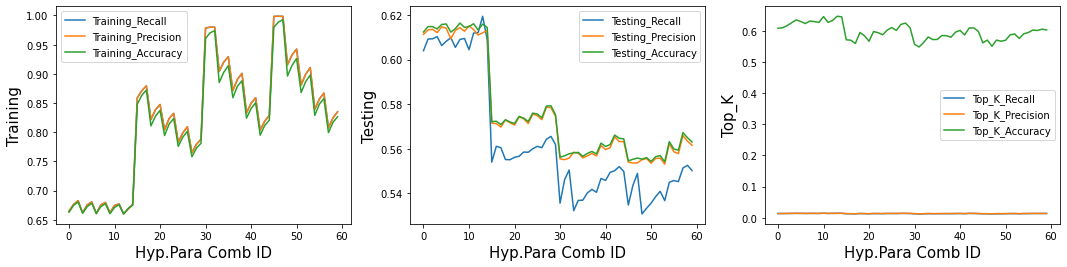

In [11]:
n_cols=3
n_rows=1
fig, axs=plt.subplots(n_rows,n_cols,figsize=(n_cols*6,n_rows*4))

ax = axs[0]
ax.plot(Output["Overall_Training_Recall"],label='Training_Recall')
ax.plot(Output["Overall_Training_Precision"],label='Training_Precision')
ax.plot(Output["Overall_Training_Accuracy"],label='Training_Accuracy')
ax.legend()
ax.set_xlabel("Hyp.Para Comb ID",fontsize=15);
ax.set_ylabel("Training",fontsize=15);

ax = axs[1]
ax.plot(Output["Overall_Testing_Recall"],label='Testing_Recall')
ax.plot(Output["Overall_Testing_Precision"],label='Testing_Precision')
ax.plot(Output["Overall_Testing_Accuracy"],label='Testing_Accuracy')
ax.legend()
ax.set_xlabel("Hyp.Para Comb ID",fontsize=15);
ax.set_ylabel("Testing",fontsize=15);

ax = axs[2]
ax.plot(Output["Top_K_Recall"],label='Top_K_Recall')
ax.plot(Output["Top_K_Precision"],label='Top_K_Precision')
ax.plot(Output["Top_K_Accuracy"],label='Top_K_Accuracy')
ax.legend()
ax.set_xlabel("Hyp.Para Comb ID",fontsize=15);
ax.set_ylabel("Top_K",fontsize=15);



In [12]:
for i in range (len(Output["Overall_Testing_Accuracy"])):
    print("=========================================",i,"==================================================")
    print("TeA=",Output["Overall_Testing_Accuracy"][i],"TeP=",Output["Overall_Testing_Precision"][i],
          "TeR=",Output["Overall_Testing_Recall"][i])
    print("KA=",Output["Top_K_Accuracy"][i],"KP=",Output["Top_K_Precision"][i],
          "KR=",Output["Top_K_Recall"][i])
    print(Output["Classifier"][i])
   

========================================= 0 ==================================================
TeA= 0.612396001232537 TeP= 0.6113360587949835 TeR= 0.6040073072290236
KA= 0.608032786885246 KP= 0.013550008000848952 KR= 0.013291807972248928
DecisionTreeClassifier(criterion='entropy', max_depth=40, max_features=20,
                       min_samples_split=25)
========================================= 1 ==================================================
TeA= 0.6148393100967741 TeP= 0.613294647125346 TeR= 0.6092321737051288
KA= 0.6098360655737706 KP= 0.01340285479604557 KR= 0.013296803115120466
DecisionTreeClassifier(criterion='entropy', max_depth=40, max_features=20,
                       min_samples_split=25)
========================================= 2 ==================================================
TeA= 0.6147938451369924 TeP= 0.6136338632621082 TeR= 0.6093419417633796
KA= 0.6163934426229507 KP= 0.01365195568839518 KR= 0.013448122936856367
DecisionTreeClassifier(criterion='entropy', m